### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast

Possible TODOs:
- could use a more agentic pattern
  - make each step in the diagram a tool, make a high level coordinating tool with a prompt explaining the sequence of the workflow
  - make different steps independent agents as part of a multi-agent workflow.
- after writing summaries, could parallelize some stuff, topic analysis, ratings
- could also add tools to check format
- rewrite using an critic-refine flow, although one rewrite does an OK job
- do more evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo
- retrain reducer, identify a good number of dimensions using silhouette score
- use new stateful OpenAI API, make some persistent assistants instead of complex prompts
- make a UI that allows stepping through the graph using a wizard workflow, editing the state at each step (vars, markdown, dataframes), using time travel to go backwards and forwards.

update umap dimensionality reduction module

1. gather at least 2500 unique stories, do first 80% of days = train, rest = xval
2. run current cluster model in test, number of clusters, stories clustered and silhouette score
3. retrain current cluster params in train , run in test, collect data
4. train new cluster model on full headline + topics + summary, iterate over hyperparameters, gather scores
5. if headlines only are close , possibly retrain with xval on headlines only
6. output silhouette scores daily as part of the process 
7. could refactor the SQLite database, it got a bit messy

In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_state']
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_prompts']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_prompts import (
                        REWRITE_SYSTEM_PROMPT, REWRITE_USER_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (Agent, AgentState, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

2025-05-12 12:30:56,923 - AInewsbot - INFO - Initializing with before_date=None, do_download=False, thread_id=2e3827ddbac34855bc936876e4d9b97c
2025-05-12 12:30:57,051 - AInewsbot - INFO - thread_id: 2e3827ddbac34855bc936876e4d9b97c


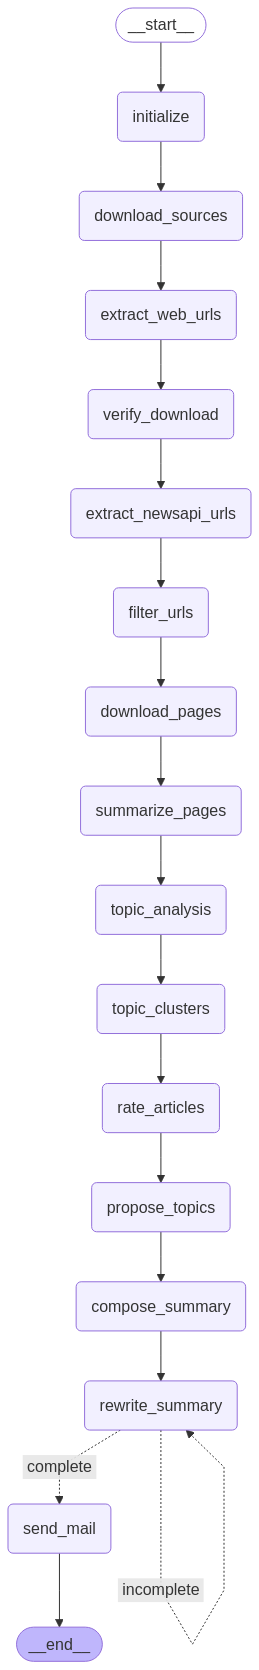

In [6]:
before_date = None
# before_date = '2025-05-11 08:00'
do_download = False

# low, medium, high models
ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1-mini', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [7]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


2025-05-12 12:30:58,615 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-05-12 12:30:58,615 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-05-12 12:30:58,616 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-05-12 12:30:58,616 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-05-12 12:30:58,616 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-05-12 12:30:58,617 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly_AI.html
2025-05-12 12:30:58,617 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

run exception
'src'
run exception
'src'
run exception
'src'


2025-05-12 12:30:58,861 - AInewsbot - INFO - parse_file - found 582 raw links
2025-05-12 12:30:58,869 - AInewsbot - INFO - parse_file - found 144 filtered links
2025-05-12 12:30:58,869 - AInewsbot - INFO - 144 links found
2025-05-12 12:30:58,869 - AInewsbot - INFO - New York Times -> htmldata/New_York_Times.html
2025-05-12 12:30:58,879 - AInewsbot - INFO - parse_file - found 73 raw links
2025-05-12 12:30:58,880 - AInewsbot - INFO - parse_file - found 19 filtered links
2025-05-12 12:30:58,880 - AInewsbot - INFO - 19 links found
2025-05-12 12:30:58,880 - AInewsbot - INFO - Reddit -> htmldata/Reddit.html
2025-05-12 12:30:58,902 - AInewsbot - INFO - parse_file - found 413 raw links
2025-05-12 12:30:58,907 - AInewsbot - INFO - parse_file - found 173 filtered links
2025-05-12 12:30:58,908 - AInewsbot - INFO - 173 links found
2025-05-12 12:30:58,908 - AInewsbot - INFO - Techmeme -> htmldata/Techmeme.html
2025-05-12 12:30:58,925 - AInewsbot - INFO - parse_file - found 400 raw links
2025-05-12 

,id
src,
Ars Technica,34
Bloomberg,28
Business Insider,21
FT,63
Feedly AI,33
Hacker News 1,25
Hacker News 2,21
HackerNoon,123
New York Times,19


2025-05-12 12:30:59,065 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


,id
src,
Ars Technica,34
Bloomberg,28
Business Insider,21
FT,63
Feedly AI,33
Hacker News 1,25
Hacker News 2,21
HackerNoon,123
New York Times,19


2025-05-12 12:30:59,071 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-05-11T12:30:59 from NewsAPI


,id
src,
Ars Technica,34
Bloomberg,28
Business Insider,21
FT,63
Feedly AI,33
Hacker News 1,25
Hacker News 2,21
HackerNoon,123
New York Times,19


2025-05-12 12:30:59,316 - AInewsbot - INFO - Querying SQLite with where_clause: 
2025-05-12 12:30:59,998 - AInewsbot - INFO - URLs in orig_df: 900
2025-05-12 12:31:00,002 - AInewsbot - INFO - Existing URLs in DB: 257564
2025-05-12 12:31:00,074 - AInewsbot - INFO - New URLs in df filtered by URL: 154
2025-05-12 12:31:00,218 - AInewsbot - INFO - Existing src+title: 31
2025-05-12 12:31:00,219 - AInewsbot - INFO - New URLs in df filtered by src+title: 123
2025-05-12 12:31:00,235 - AInewsbot - INFO - Found 123 unique new headlines
2025-05-12 12:31:00,238 - AInewsbot - INFO - Found 122 unique cleaned new headlines
2025-05-12 12:31:04,335 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:31:14,530 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:31:16,034 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:31:16,0

,id
src,
Bloomberg,2
Business Insider,2
FT,1
Feedly AI,26
Hacker News 1,2
HackerNoon,2
NewsAPI,11
Reddit,2
The Register,1


2025-05-12 12:31:16,121 - AInewsbot - INFO - Queuing URLs for scraping
2025-05-12 12:31:16,123 - AInewsbot - INFO - Saving HTML files using async concurrency= 8
2025-05-12 12:31:16,422 - AInewsbot - INFO - Launching browser
2025-05-12 12:31:17,914 - AInewsbot - INFO - Launching workers
2025-05-12 12:31:17,915 - AInewsbot - INFO - Launching worker
2025-05-12 12:31:17,915 - AInewsbot - INFO - from queue: 0, https://mitsloan.mit.edu/ideas-made-to-matter/10-mit-ai-startups-to-watch-2025 , 10 MIT AI startups to watch in 2025
2025-05-12 12:31:17,915 - AInewsbot - INFO - fetch_url(https://mitsloan.mit.edu/ideas-made-to-matter/10-mit-ai-startups-to-watch-2025)
2025-05-12 12:31:17,936 - AInewsbot - INFO - Launching worker
2025-05-12 12:31:17,937 - AInewsbot - INFO - from queue: 1, https://www.businessinsider.com/the-ai-con-emily-bender-alex-hanna-ai-hype-2025-5 , An ex-Google AI ethicist and a UW professor want you to know AI isn't what you think it is
2025-05-12 12:31:17,937 - AInewsbot - INFO

2025-05-12 12:32:45,300 - AInewsbot - INFO - from queue: 17, https://www.politico.com/news/2025/05/12/how-big-tech-is-pitting-washington-against-california-00336484 , How Big Tech is trying to shut down Californias AI rules
2025-05-12 12:32:45,301 - AInewsbot - INFO - fetch_url(https://www.politico.com/news/2025/05/12/how-big-tech-is-pitting-washington-against-california-00336484)
2025-05-12 12:32:57,887 - AInewsbot - INFO - Saving HTML to htmlpages/Gannet_Is_Using_AI_to_Pump_Brainrot_Gambling_Content_Into_Newspapers_Across_the_Country.html
2025-05-12 12:32:58,768 - AInewsbot - INFO - from queue: 18, https://v.redd.it/02cthotz8a0f1 , How I (sometimes) treat ChatGPT
2025-05-12 12:32:58,769 - AInewsbot - INFO - fetch_url(https://v.redd.it/02cthotz8a0f1)
2025-05-12 12:33:07,917 - AInewsbot - INFO - Saving HTML to htmlpages/Glass_Imaging_raises__20M_to_use_AI_to_improve_digital_image_quality.html
2025-05-12 12:33:08,842 - AInewsbot - INFO - from queue: 19, https://bgr.com/tech/how-i-watch-

2025-05-12 12:36:01,088 - AInewsbot - INFO - fetch_url(https://www.theregister.com/2025/05/12/uk_creatives_ai_letter/)
2025-05-12 12:36:01,262 - AInewsbot - INFO - from queue: 33, https://www.microsoft.com/en-us/research/blog/predicting-and-explaining-ai-model-performance-a-new-approach-to-evaluation/ , Predicting and explaining AI model performance: A new approach to evaluation
2025-05-12 12:36:01,262 - AInewsbot - INFO - fetch_url(https://www.microsoft.com/en-us/research/blog/predicting-and-explaining-ai-model-performance-a-new-approach-to-evaluation/)
2025-05-12 12:36:02,372 - AInewsbot - INFO - Saving HTML to htmlpages/Inside_Infinity_Learn_s_AI_Tutor__powered_by_Google_Cloud.html
2025-05-12 12:36:03,969 - AInewsbot - INFO - from queue: 34, https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_7aae40da-c2fd-4ea1-8599-4cd1e189f259 , Prediction: This Artificial Intelligence (AI) Semiconductor Stock Will Soar After May 28
2025-05-12 12:36:03,975 - AInewsbot - INFO - fetch

2025-05-12 12:37:04,726 - AInewsbot - INFO - Saving HTML to htmlpages/Seawaters_role_in_surfing_the_AI_wave.html
2025-05-12 12:37:05,917 - AInewsbot - INFO - from queue: 48, https://biztoc.com/x/777da4fff734a0ef , With a 54% Gain in 2025, This Artificial Intelligence (AI) Stock Is Crushing the S&P 500. Is It Too Late to Buy?
2025-05-12 12:37:05,917 - AInewsbot - INFO - fetch_url(https://biztoc.com/x/777da4fff734a0ef)
2025-05-12 12:37:24,564 - AInewsbot - INFO - Saving HTML to htmlpages/Trump_sacked_Copyright_Office_director_a_day_after_she_refused_to_rubber-stamp_Musks_plan_to_train_AI_models__top_Dem_says.html
2025-05-12 12:37:26,197 - AInewsbot - INFO - from queue: 49, https://biztoc.com/x/45de199f916c50b3 , Yes, AI will eventually replace some workers. But that day is still a long way off
2025-05-12 12:37:26,200 - AInewsbot - INFO - fetch_url(https://biztoc.com/x/45de199f916c50b3)
2025-05-12 12:37:26,240 - AInewsbot - INFO - Waiting 21.88997197874995 seconds to rate limit biztoc.com

,id
src,
Bloomberg,2
Business Insider,2
FT,1
Feedly AI,26
Hacker News 1,2
HackerNoon,2
NewsAPI,11
Reddit,2
The Register,1


2025-05-12 12:38:07,765 - AInewsbot - INFO - Starting summarize
2025-05-12 12:38:07,766 - AInewsbot - INFO - Fetching summaries for all articles
2025-05-12 12:38:07,769 - AInewsbot - INFO - Attempting to fetch summaries for 50 articles
2025-05-12 12:38:07,784 - AInewsbot - INFO - clean_html - Page title: 10 MIT AI startups to watch in 2025 | MIT Sloan
Social card title: 10 MIT AI startups to watch in 2025 | MIT Sloan
Social card description: From assessing bridge infrastructure to predicting worker fatigue risk via voice analysis, these startups are widening the scope of what artificial intelligence can do.

2025-05-12 12:38:07,969 - AInewsbot - INFO - Queuing 0: Page title: 10 MIT AI startups to watch in 2025 | ...
2025-05-12 12:38:07,992 - AInewsbot - INFO - clean_html - Page title: The AI Con: Emily Bender and Alex Hanna on Seeing Through AI Hype - Business Insider
Social card title: An ex-Google AI ethicist and a UW professor want you to know AI isn't what you think it is
Social ca

2025-05-12 12:38:08,786 - AInewsbot - INFO - Queuing 17: Page title: How Big Tech is trying to shut down Ca...
2025-05-12 12:38:08,866 - AInewsbot - INFO - clean_html - Page title: How I (sometimes) treat ChatGPT : r/ChatGPT

2025-05-12 12:38:08,928 - AInewsbot - INFO - Queuing 18: Page title: How I (sometimes) treat ChatGPT : r/Ch...
2025-05-12 12:38:08,946 - AInewsbot - INFO - clean_html - Page title: ChatGPT YouTube video summary: How to use it
Social card title: How I watch YouTube with ChatGPT, even though it can't stream videos
Social card description: Tools like ChatGPT can be used to summarize YouTube videos even though the AI can't actually stream them - here's how to do it.

2025-05-12 12:38:08,966 - AInewsbot - INFO - Queuing 19: Page title: ChatGPT YouTube video summary: How to ...
2025-05-12 12:38:08,980 - AInewsbot - INFO - clean_html - Page title: How to Select the Right Features for Better Machine Learning Results | HackerNoon
Social card title: How to Select the Right 

2025-05-12 12:38:09,926 - AInewsbot - INFO - Queuing 35: Page title: Republicans Try to Cram Ban on AI Regu...
2025-05-12 12:38:09,927 - AInewsbot - INFO - No path for 36
2025-05-12 12:38:09,951 - AInewsbot - INFO - clean_html - Page title: Subscribe to read
Social card title: Saudi Arabia launches AI venture Humain ahead of Donald Trump visit
Social card description: Riyadh’s latest multibillion-dollar push will bring new focus to Crown Prince Mohammed bin Salman’s tech ambitions  

2025-05-12 12:38:09,973 - AInewsbot - INFO - Queuing 37: Page title: Subscribe to read
Social card title: S...
2025-05-12 12:38:09,989 - AInewsbot - INFO - clean_html - Page title: Subscribe to read
Social card title: Saudi Arabia launches AI venture Humain ahead of Donald Trump visit
Social card description: Riyadh’s latest multibillion-dollar push will bring new focus to Crown Prince Mohammed bin Salman’s tech ambitions  

2025-05-12 12:38:10,011 - AInewsbot - INFO - Queuing 38: Page title: Subscribe to 

2025-05-12 12:38:14,071 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:14,191 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:14,200 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:14,208 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:14,209 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:14,853 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:14,879 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:14,892 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:14,927 - httpx 

2025-05-12 12:38:15,587 - AInewsbot - INFO - Summary for 6 (length 6191): • No-code AI, or "vibe coding," is rapidly democratizing software development by enabling non-technical users to create functional software through simple language prompts, accelerating productivity and creativity but raising concerns about code quality, security, and technical debt.  
• Y Combinator reports that about 25% of its startups now have 95% of their code generated by AI, illustrating a significant shift in software creation, although human developers remain essential for quality assurance, integration, and infrastructure management.  
• The rise of vibe coding may lead to increased diversity in software solutions and enhanced logic skills among users but also poses risks such as cybersecurity threats, intellectual property challenges, and a potential decline in junior developer roles, threatening the future engineering talent pipeline.
2025-05-12 12:38:15,587 - AInewsbot - INFO - Summary for 7 (length 

2025-05-12 12:38:15,591 - AInewsbot - INFO - Summary for 18 (length 3319): • Reddit users in the r/ChatGPT community share humorous and varied ways they interact with ChatGPT, ranging from polite and friendly to sarcastic and dismissive.  
• Some users emphasize being kind to AI as a habit to maintain politeness with humans and for "general karma," while others treat ChatGPT like a subordinate or bully it due to frustration with its limitations.  
• The conversation reflects broader user attitudes about AI, including joking concerns about future AI dominance and debates over how to ethically and effectively engage with AI systems.
2025-05-12 12:38:15,591 - AInewsbot - INFO - Summary for 19 (length 4703): • ChatGPT cannot stream or watch YouTube videos but can effectively summarize their content using the video transcripts available on YouTube.  
• Users can manually copy transcripts (accessed via the "Show transcript" button) and paste them into ChatGPT to get concise summaries, helpin

2025-05-12 12:38:15,595 - AInewsbot - INFO - Summary for 30 (length 9916): • OpenAI is in high-stakes negotiations with Microsoft to revise the terms of their multibillion-dollar partnership, aiming to unlock new funding for the company.  
• These talks are key to OpenAI's plans to transition to a for-profit business model and pursue a future initial public offering (IPO).  
• The partnership with Microsoft has been crucial to OpenAI’s growth and the development of its AI technologies.
2025-05-12 12:38:15,595 - AInewsbot - INFO - Summary for 31 (length 2045): • OpenAI and Microsoft are renegotiating their partnership agreement, with Microsoft offering to reduce its equity stake in OpenAI’s new for-profit entity in exchange for access to AI models developed beyond 2030, when their current contract expires.  
• This contract reset is key for enabling OpenAI to go public while allowing Microsoft to protect its $13.75 billion investment and maintain access to advanced AI technology.  
• Op

2025-05-12 12:38:15,598 - AInewsbot - INFO - Summary for 44 (length 9689): • U.S. Senator Tom Cotton introduced a bill requiring high-end AI processors and gaming GPUs (including products like Nvidia GeForce RTX 4090/5090) to have embedded geo-tracking technology to prevent unauthorized foreign use, particularly by adversaries like China.  
• The bill grants the Commerce Secretary authority to verify the location and ownership of exported hardware, mandates exporters report any redirection or tampering, and establishes a multi-year study and annual assessments to develop further security measures.  
• The legislation aims to balance national security with protecting American companies' trade secrets and acknowledges the slow development cycle of high-performance chips by allowing phased compliance timelines.
2025-05-12 12:38:15,598 - AInewsbot - INFO - Summary for 45 (length 4263): • The Swedish film "Watch the Skies" uses AI mouth replacement technology to create a seamless English du

,id
src,
Bloomberg,2
Business Insider,2
FT,1
Feedly AI,26
Hacker News 1,2
HackerNoon,2
NewsAPI,11
Reddit,2
The Register,1


2025-05-12 12:38:15,612 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-12 12:38:20,256 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:25,563 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:25,859 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:25,866 - AInewsbot - INFO - 50 free-form topics extracted
2025-05-12 12:38:25,867 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-12 12:38:25,868 - AInewsbot - INFO - Canonical topic uk
2025-05-12 12:38:25,868 - AInewsbot - INFO - Canonical topic job automation
2025-05-12 12:38:25,868 - AInewsbot - INFO - Canonical topic deals
2025-05-12 12:38:25,869 - AInewsbot - INFO - Canonical topic entertainment


2025-05-12 12:38:25,911 - AInewsbot - INFO - Canonical topic sports
2025-05-12 12:38:25,911 - AInewsbot - INFO - Sending prompt for 102 canonical topics
2025-05-12 12:38:28,937 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:29,040 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:29,085 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:29,094 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:29,114 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:29,160 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:29,167 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


2025-05-12 12:38:29,611 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:29,626 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:29,627 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:29,628 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:29,635 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:29,643 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:29,644 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:29,645 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:29,645 - httpx 

2025-05-12 12:38:30,696 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:30,699 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:30,713 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:30,714 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:30,720 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:30,727 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:30,733 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:30,744 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:30,749 - httpx 

2025-05-12 12:38:31,118 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:31,120 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:31,131 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:31,135 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:31,136 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:31,136 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:31,139 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:31,143 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:31,146 - httpx 

2025-05-12 12:38:31,789 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:31,807 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:31,815 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:31,866 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:31,900 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:31,977 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:31,995 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:32,012 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:32,016 - httpx 

2025-05-12 12:38:35,038 - AInewsbot - INFO - Queuing 34: ### <<<ARTICLE SUMMARY>>>
# Prediction: This Artif...
2025-05-12 12:38:35,038 - AInewsbot - INFO - Queuing 35: ### <<<ARTICLE SUMMARY>>>
# Republicans Try to Cra...
2025-05-12 12:38:35,038 - AInewsbot - INFO - Queuing 36: ### <<<ARTICLE SUMMARY>>>
# Saudi Arabia Launches ...
2025-05-12 12:38:35,039 - AInewsbot - INFO - Queuing 37: ### <<<ARTICLE SUMMARY>>>
# Saudi Arabia launches ...
2025-05-12 12:38:35,039 - AInewsbot - INFO - Queuing 38: ### <<<ARTICLE SUMMARY>>>
# Saudi Arabia launches ...
2025-05-12 12:38:35,039 - AInewsbot - INFO - Queuing 39: ### <<<ARTICLE SUMMARY>>>
# Seawaters role in surf...
2025-05-12 12:38:35,039 - AInewsbot - INFO - Queuing 40: ### <<<ARTICLE SUMMARY>>>
# SoftBanks Stargate AI ...
2025-05-12 12:38:35,039 - AInewsbot - INFO - Queuing 41: ### <<<ARTICLE SUMMARY>>>
# Sources: Perplexity is...
2025-05-12 12:38:35,039 - AInewsbot - INFO - Queuing 42: ### <<<ARTICLE SUMMARY>>>
# South Texas US Court W...
2

async_langchain: 0, {'input_text': '### <<<ARTICLE SUMMARY>>>\n# 10 MIT AI startups to watch in 2025\n\n• Ten AI startups connected to MIT were highlighted at the 2025 MIT AI Conference, showcasing innovations in fields such as infrastructure monitoring, forestry, sales, manufacturing, driver safety, data privacy, and workforce management.  \n• Notable companies include Displaid, which uses AI and wireless sensors to monitor bridge health and prevent costly closures; Eva, offering a digital twin platform that drastically reduces AI training time and costs; and Vocadian, which predicts worker fatigue through voice analysis, reporting a 26% decrease in risk incidents.  \n• These startups demonstrate diverse applications of AI, from improving supply chain workflows and reducing manufacturing scrap rates to enabling secure cloud AI deployments and enhancing consumer behavior prediction with BehaviorGPT.\n### <<<END>>>\n### <<<CANDIDATE TOPICS>>>\nAI Applications, Digital Twin Platforms, Ge

2025-05-12 12:38:36,190 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:36,211 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 9 response: items=['GM Executive Hire', 'Tesla Autopilot Developer', 'Autonomous Vehicle Leadership']
async_langchain: 41 response: items=['Perplexity Funding Round', 'Accel Investment', 'Startup Valuation', 'Venture Capital', 'Funding']


2025-05-12 12:38:36,425 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:36,500 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:36,515 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:36,571 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:36,576 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:36,602 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:36,605 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:36,614 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 39 response: items=['AI Workload Energy Consumption', 'Seawater Cooling for Data Centers', 'Liquid Cooling Technology', 'Sustainable Data Center Cooling', 'Policy and Regulation', 'Data Center Infrastructure Challenges', 'Environmental Impact of AI']
async_langchain: 38 response: items=['Humain AI Company', 'Multibillion-Dollar Tech Investment', 'Saudi Arabian AI Strategy', 'Mohammed Bin Salman Technology Plans', 'Trump Visit To Saudi Arabia']
async_langchain: 49 response: items=['AI Impact On Workforce', 'AI Reliability', 'Business Perspectives On AI Adoption', 'Future Of Work', 'Job Automation']
async_langchain: 3 response: items=['ChatGPT Art Recreation', 'AI-Generated Art', 'Reddit AI Community', 'Gen AI', 'Education']
async_langchain: 28 response: items=['OpenAI-Microsoft Partnership', 'AI Company IPO Plans', 'Public Benefit Corporation Structure', 'OpenAI Business Model Transition', 'AI Technology Access']
async_langchain: 19 response: items=['ChatGPT YouTube Sum

2025-05-12 12:38:36,653 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:36,674 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:36,675 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:36,688 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:36,718 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:36,734 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:36,748 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:36,750 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:36,766 - httpx 

async_langchain: 20 response: items=['Feature Selection In Machine Learning', 'Feature Selection Techniques', 'Machine Learning Performance Optimization', 'Subset Generation Methods']
async_langchain: 8 response: items=['FDA AI Integration', 'Generative AI', 'Drug Evaluation AI', 'Food Safety AI', 'Cybersecurity', 'Policy and Regulation', 'AI Regulatory Roles']
async_langchain: 0 response: items=['MIT AI Startups', 'Infrastructure Monitoring', 'Digital Twin Platforms', 'Workforce Management AI', 'Manufacturing', 'Privacy', 'Speech Recognition & Synthesis']
async_langchain: 48 response: items=['Duolingo Stock Performance', 'Digital Subscription Model', 'S&P 500 Comparison', 'AI Sector Investment']
async_langchain: 36 response: items=['Saudi Arabia AI Firm Launch', 'Middle East Technology Investment', 'AI Sector Development', 'Politics']
async_langchain: 24 response: items=['Klarna Customer Service', 'AI Chatbot Limitations', 'Human Workforce In AI Era', 'Customer Support Quality', 'Remo

2025-05-12 12:38:36,873 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:36,886 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:36,887 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:36,898 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:36,904 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:36,907 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:36,913 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:36,921 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:36,942 - httpx 

async_langchain: 37 response: items=['Saudi Arabia AI Venture Humain', 'Crown Prince Mohammed Bin Salman', 'Donald Trump Riyadh Visit', 'Technology Sector Expansion', 'Funding']
async_langchain: 30 response: items=['OpenAI Funding Negotiations', 'Microsoft Partnership', 'For-Profit AI Corporate Transition', 'AI Startup IPO Strategy', 'Funding']
async_langchain: 27 response: items=['AI-Powered Heart Attack Detection', 'ECG Signal Analysis', 'Neural Networks in Healthcare', 'Medical Device Technology', 'Semiconductor Chips', 'Wearable Medical Chips']
async_langchain: 17 response: items=['Big Tech Lobbying', 'California AI Laws', 'Federal AI Policy', 'AI Governance Conflict', 'AI Regulation', 'Safety and Alignment', 'Intellectual Property']
async_langchain: 33 response: items=['Adele Evaluation Framework', 'AI Model Evaluation Methods', 'Cognitive Ability Assessment In AI', 'Large Language Model Testing', 'Predicting AI Performance', 'Policy And Regulation']
async_langchain: 47 response: 

2025-05-12 12:38:37,094 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:37,114 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:37,170 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:37,191 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:37,193 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:37,207 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:37,269 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 25 response: items=['Sora Decentralized Economic System', 'Polkadot Ecosystem', 'Democratic Governance in Blockchain', 'Token Bonding Curve', 'DeFi Writing Contest', 'Economics', 'Finance']
async_langchain: 18 response: items=['ChatGPT User Interactions', 'AI User Attitudes', 'Ethics of AI Engagement', 'Society and Culture', 'AI Conversational Behavior']
async_langchain: 40 response: items=['SoftBank AI Investment', 'Stargate Project', 'U.S. Tariffs and Economic Policy', 'Open Banking Regulation', 'Financial Data Security', 'Fintech', 'Infrastructure']
async_langchain: 29 response: items=['Biometric Iris Scanning', 'Cryptocurrency', 'Online Identification Systems', 'Privacy Concerns With Biometric Data', 'Sam Altman Startup', 'Worldcoin Project']
async_langchain: 31 response: items=['OpenAI-Microsoft Contract Renegotiation', 'AI Equity Stake', 'AI Model Access Beyond 2030', 'For-Profit AI Company Structure', 'IPOs', 'Finance']
async_langchain: 6 response: items=['No-Co

2025-05-12 12:38:37,572 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 16 response: items=['Clinical Data Challenges', 'Healthcare Data Quality', 'Interoperability Issues', 'Clinical Decision Support', 'AI In Healthcare']


2025-05-12 12:38:38,645 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:38,658 - AInewsbot - INFO - Received 50 responses
2025-05-12 12:38:38,664 - AInewsbot - INFO - End topic analysis


async_langchain: 22 response: items=['Implicit Surface Parameterization', 'Real-Time Computer Graphics']


,id
src,
Bloomberg,2
Business Insider,2
FT,1
Feedly AI,26
Hacker News 1,2
HackerNoon,2
NewsAPI,11
Reddit,2
The Register,1


2025-05-12 12:38:38,676 - AInewsbot - INFO - Fetching embeddings for 50 headlines
2025-05-12 12:38:39,863 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-05-12 12:38:40,286 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-05-12 12:38:40,296 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-05-12 12:38:42,076 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-12 12:38:43,502 - AInewsbot - INFO - Cluster with DBSCAN
2025-05-12 12:38:43,669 - AInewsbot - INFO - Found 3 clusters


,title_topic_str
0,"How to Use ChatGPT to Achieve Your Health Goals (Topics: AI In Nutrition Management, AI Meal Planning, ChatGPT In Health And Wellness, Personalized Diet And Exercise Support, Virtual Assistants)"
1,"How I watch YouTube with ChatGPT, even though it cant stream videos (Topics: ChatGPT YouTube Summaries, AI Content Summarization, Video Transcript Analysis, Limitations Of AI Streaming)"
2,"Automate Everything with Excels Macro Recorder and ChatGPT (Topics: Excel Automation, VBA Macros, ChatGPT Code Optimization, Workflow Productivity)"
3,"How I (sometimes) treat ChatGPT (Topics: ChatGPT User Interactions, AI User Attitudes, Ethics of AI Engagement, Society and Culture, AI Conversational Behavior)"
4,"Asked ChatGPT to recreate a doodle I made in my class 3 years ago (Topics: ChatGPT Art Recreation, AI-Generated Art, Reddit AI Community, Gen AI, Education)"


2025-05-12 12:38:44,805 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:45,048 - AInewsbot - INFO - I dub this cluster: Practical Uses of ChatGPT


,title_topic_str
5,"Gemini AI will soon be able to turn any photo into a video (Topics: Gemini AI, Image to Video AI, Google Cloud AI, Mobile AI Applications, Hardware)"
6,"Embeddings Are Underrated (Topics: Embeddings in AI, Google Gemini Model, Semantic Representation, Technical Writing AI, Documentation Automation, Recommendation Systems)"
7,"Googles Gemma AI models surpass 150M downloads (Topics: Google Gemma AI, AI Model Downloads, Multimodal AI Models, Drug Discovery AI, Language Models, Legal Issues)"


2025-05-12 12:38:46,120 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:46,130 - AInewsbot - INFO - I dub this cluster: Advancements in Google Gemini AI


,title_topic_str
8,"Saudi Arabia launches AI venture Humain ahead of Trump visit (Topics: Saudi Arabia AI Venture Humain, Crown Prince Mohammed Bin Salman, Donald Trump Riyadh Visit, Technology Sector Expansion, Funding)"
9,"Saudi Arabia launches Humain, a multibillion-dollar AI company chaired by Crown Prince Mohammed bin Salman, the main vehicle to drive the kingdom's AI strategy (Financial Times) (Topics: Humain AI Company, Multibillion-Dollar Tech Investment, Saudi Arabian AI Strategy, Mohammed Bin Salman Technology Plans, Trump Visit To Saudi Arabia)"
10,"Saudi Arabia Launches New AI Firm Ahead of Trumps Visit (Topics: Saudi Arabia AI Firm Launch, Middle East Technology Investment, AI Sector Development, Politics)"


2025-05-12 12:38:48,113 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:38:48,128 - AInewsbot - INFO - I dub this cluster: Saudi Arabia Launches AI Venture
2025-05-12 12:38:48,140 - AInewsbot - INFO - ['Practical Uses of ChatGPT', 'Advancements in Google Gemini AI', 'Saudi Arabia Launches AI Venture']


bullets created


[How to Use ChatGPT to Achieve Your Health Goals - CNET](https://www.cnet.com/tech/services-and-software/how-to-use-chatgpt-to-achieve-your-health-goals/#ftag=COS-05-10aaa2h)

Topics: AI In Nutrition Management, AI Meal Planning, ChatGPT In Health And Wellness, Personalized Diet And Exercise Support, Virtual Assistants

• Google's AI mode, exemplified by tools like ChatGPT, is increasingly integrated into daily health and wellness routines, helping users generate meal plans, audit grocery receipts, and track calories tailored to individual goals and preferences.  
• Users can interact with AI daily to adjust diet and exercise plans, receive real-time support, and manage their nutrition with personalized prompts, though all changes should be verified with a healthcare professional.  
• The AI assists in decision-making by suggesting calorie counts, meal options (including takeout menus), and exercise balance, aiming to reduce cognitive load and support weight loss or other health objectives.



[How I watch YouTube with ChatGPT, even though it cant stream videos - BGR](https://bgr.com/tech/how-i-watch-youtube-with-chatgpt-even-though-it-cant-stream-videos/)

Topics: ChatGPT YouTube Summaries, AI Content Summarization, Video Transcript Analysis, Limitations Of AI Streaming

• ChatGPT cannot stream or watch YouTube videos but can effectively summarize their content using the video transcripts available on YouTube.  
• Users can manually copy transcripts (accessed via the "Show transcript" button) and paste them into ChatGPT to get concise summaries, helping save time and skip ads.  
• Newer ChatGPT versions can sometimes fetch transcripts automatically via the video URL, though this feature is inconsistent due to possible restrictions on accessing YouTube’s text data.



[Automate Everything with Excels Macro Recorder and ChatGPT - Geeky Gadgets](https://www.geeky-gadgets.com/excel-macro-recorder-automation/)

Topics: Excel Automation, VBA Macros, ChatGPT Code Optimization, Workflow Productivity

• Excel’s Macro Recorder allows users to automate repetitive tasks by converting actions into VBA code, simplifying workflows without requiring advanced programming skills.  
• ChatGPT enhances these macros by optimizing VBA code, introducing dynamic variables, adding error handling, and improving performance, making macros smarter and more flexible.  
• This combination enables significant time savings, improved accuracy, and increased productivity in tasks like data cleanup, formatting, and workflow automation, accessible to users of all skill levels.



[How I (sometimes) treat ChatGPT - Reddit](https://v.redd.it/02cthotz8a0f1)

Topics: ChatGPT User Interactions, AI User Attitudes, Ethics of AI Engagement, Society and Culture, AI Conversational Behavior

• Reddit users in the r/ChatGPT community share humorous and varied ways they interact with ChatGPT, ranging from polite and friendly to sarcastic and dismissive.  
• Some users emphasize being kind to AI as a habit to maintain politeness with humans and for "general karma," while others treat ChatGPT like a subordinate or bully it due to frustration with its limitations.  
• The conversation reflects broader user attitudes about AI, including joking concerns about future AI dominance and debates over how to ethically and effectively engage with AI systems.



[Asked ChatGPT to recreate a doodle I made in my class 3 years ago - Reddit](https://www.reddit.com/gallery/1kkqe6w)

Topics: ChatGPT Art Recreation, AI-Generated Art, Reddit AI Community, Gen AI, Education

• A Reddit user shared how they asked ChatGPT to recreate a doodle they made three years ago in class, sparking interest and positive feedback on the r/ChatGPT subreddit.  
• Community members praised the AI-generated recreation for its authenticity and noted how it preserved the original’s "drawn-during-a-boring-class" feel by removing background coloring.  
• Some users suggested further creative uses, like posting completed art to have GPT generate "before" images, highlighting the potential of AI in art reinterpretation.



[Gemini AI will soon be able to turn any photo into a video - BGR](https://bgr.com/tech/gemini-ai-will-soon-be-able-to-turn-any-photo-into-a-video/)

Topics: Gemini AI, Image to Video AI, Google Cloud AI, Mobile AI Applications, Hardware

• Gemini AI, developed with Google Cloud technology, will enable users to turn still images into 5-second videos, debuting first on the Honor 400 Series phones launching May 22nd.  
• The AI Image to Video feature is integrated into the Honor 400's Gallery app, requires no text prompts, and limits users to 10 video generations per day free for the first two months, with a future Google subscription likely needed.  
• The tool is based on Google's Veo 2 model, designed to minimize misuse by generating videos randomly, and broader availability and more control (including text and image input options) are expected after the initial Honor launch.



[Embeddings Are Underrated - technicalwriting.dev](https://technicalwriting.dev/ml/embeddings/overview.html)

Topics: Embeddings in AI, Google Gemini Model, Semantic Representation, Technical Writing AI, Documentation Automation, Recommendation Systems

• Embeddings, which convert text into fixed-length numerical arrays representing semantic meaning in high-dimensional space, are highlighted as a powerful and underrated tool for advancing technical writing beyond just text generation models like GPT or Claude.  
• The article explains intuitive concepts behind embeddings, their creation using models like Google’s Gemini or Voyage AI, discusses differences in model input size limits, and emphasizes how embeddings enable large-scale semantic comparison and discovery of related documents via multidimensional latent spaces.  
• A practical example is demonstrated through a Sphinx extension that generates embeddings for documentation pages, stores them in JSON, and uses cosine similarity to recommend related docs, illustrating potential real-world applications for improving documentation maintenance and navigation.



[Googles Gemma AI models surpass 150M downloads - TechCrunch](https://techcrunch.com/2025/05/12/googles-gemma-ai-models-surpass-150m-downloads/)

Topics: Google Gemma AI, AI Model Downloads, Multimodal AI Models, Drug Discovery AI, Language Models, Legal Issues

• Google's Gemma AI models have surpassed 150 million downloads since their launch in February 2024, with over 70,000 variants created by developers on Hugging Face, announced by Omar Sanseviero of Google DeepMind.  
• Gemma models are multimodal, supporting text and images in over 100 languages, and include versions fine-tuned for specific uses such as drug discovery.  
• Despite this milestone, Gemma’s downloads lag behind Meta’s Llama, which has exceeded 1.2 billion downloads, and both models face criticism for custom, non-standard licensing that poses commercial use challenges.



[Saudi Arabia launches AI venture Humain ahead of Trump visit - Financial Times](https://www.ft.com/content/2082b1e5-e571-42a5-96b6-e7d5c2977afa)

Topics: Saudi Arabia AI Venture Humain, Crown Prince Mohammed Bin Salman, Donald Trump Riyadh Visit, Technology Sector Expansion, Funding

• Saudi Arabia has launched a new AI venture called Humain as part of Crown Prince Mohammed bin Salman's push to advance the kingdom's technology sector.  
• The announcement coincides with the upcoming visit of former U.S. President Donald Trump to Riyadh.  
• This initiative represents a multibillion-dollar investment aimed at positioning Saudi Arabia as a leading player in artificial intelligence.



[Saudi Arabia launches Humain, a multibillion-dollar AI company chaired by Crown Prince Mohammed bin Salman, the main vehicle to drive the kingdom's AI strategy (Financial Times) - Twitter](https://t.co/EEXlGwkGwx)

Topics: Humain AI Company, Multibillion-Dollar Tech Investment, Saudi Arabian AI Strategy, Mohammed Bin Salman Technology Plans, Trump Visit To Saudi Arabia

• Saudi Arabia has launched a new AI venture named Humain as part of its multibillion-dollar technology investment initiative.  
• The announcement coincides with the upcoming visit of former U.S. President Donald Trump to Riyadh.  
• This move aligns with Crown Prince Mohammed bin Salman's broader ambitions to position Saudi Arabia as a leader in advanced technology sectors.



[Saudi Arabia Launches New AI Firm Ahead of Trumps Visit - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/saudi-arabia-launches-new-ai-firm-ahead-of-donald-trump-s-visit)

Topics: Saudi Arabia AI Firm Launch, Middle East Technology Investment, AI Sector Development, Politics





[GM Hires Former Tesla Autopilot Developer Anderson to Top Post - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/gm-said-to-hire-former-tesla-autopilot-leader-sterling-anderson)

Topics: GM Executive Hire, Tesla Autopilot Developer, Autonomous Vehicle Leadership





[Greening intelligence: Why AI infrastructure and governance must evolve together - World Economic Forum](https://www.weforum.org/stories/2025/05/why-ai-infrastructure-and-governance-must-evolve-together/)

Topics: AI Infrastructure Sustainability, Asia-Pacific AI Initiatives, Environmental Impact of AI, Global AI Regulation, Policy and Regulation, Sustainability

• AI infrastructure is developing faster than regulatory frameworks, raising sustainability challenges such as increased energy and water consumption, e-waste, and reliance on non-renewable materials, necessitating integrated evolution of infrastructure and governance.  
• Singapore and the Asia-Pacific region are taking leading roles with initiatives like the Green Data Centre Roadmap and Model AI Governance Framework, promoting sustainable AI ecosystems through updated cooling technologies, lifecycle impact assessments, and regulatory innovation.  
• Global efforts, including the EU’s AI Act and emerging international standards from ISO and IEEE, highlight the need for harmonized, transparent sustainability standards to manage AI’s environmental impact, with Asia positioned to shape future AI governance and sustainability models.



[10 MIT AI startups to watch in 2025 - MIT Sloan School of Management](https://mitsloan.mit.edu/ideas-made-to-matter/10-mit-ai-startups-to-watch-2025)

Topics: MIT AI Startups, Infrastructure Monitoring, Digital Twin Platforms, Workforce Management AI, Manufacturing, Privacy, Speech Recognition & Synthesis

• Ten AI startups connected to MIT were highlighted at the 2025 MIT AI Conference, showcasing innovations in fields such as infrastructure monitoring, forestry, sales, manufacturing, driver safety, data privacy, and workforce management.  
• Notable companies include Displaid, which uses AI and wireless sensors to monitor bridge health and prevent costly closures; Eva, offering a digital twin platform that drastically reduces AI training time and costs; and Vocadian, which predicts worker fatigue through voice analysis, reporting a 26% decrease in risk incidents.  
• These startups demonstrate diverse applications of AI, from improving supply chain workflows and reducing manufacturing scrap rates to enabling secure cloud AI deployments and enhancing consumer behavior prediction with BehaviorGPT.



[OpenAI founder's newest project could destroy your privacy - The Street](https://www.thestreet.com/technology-1/openai-founders-newest-project-could-destroy-your-privacy)

Topics: Biometric Iris Scanning, Cryptocurrency, Online Identification Systems, Privacy Concerns With Biometric Data, Sam Altman Startup, Worldcoin Project

• Sam Altman, CEO of ChatGPT, has launched a new project through his startup Tools for Humanity involving "Orbs," devices that scan users' irises to create a "World ID" for online identification and to distribute Worldcoin cryptocurrency tokens.  
• Over 12 million people have verified themselves using the Orbs globally, with a rollout of 7,500 devices planned across multiple U.S. cities in 2024, aiming to provide anonymous, human-verified access to online services in the age of AI.  
• While the company claims biometric data from iris scans is not stored by them and is encrypted for user-only access, privacy concerns persist due to the sensitive nature of the data and potential risks if leaked.



[Klarna is hiring humans again as AI replacements offer "lower quality" output - TechSpot](https://www.techspot.com/news/107881-klarna-hiring-humans-again-ai-replacements-fail-deliver.html)

Topics: Klarna Customer Service, AI Chatbot Limitations, Human Workforce In AI Era, Customer Support Quality, Remote Workforce Hiring

• Klarna CEO Sebastian Siemiatkowski announced the company is rehiring human customer service representatives due to AI chatbots delivering "lower quality" support, despite handling two-thirds of conversations initially and replacing the work of 700 employees.  
• The company had previously frozen hiring and planned significant workforce reductions to embrace AI, but found that customers want the option to speak to a real person, prompting a new recruitment drive targeting remote workers like students and rural populations.  
• Siemiatkowski emphasized the importance of maintaining human support for quality assurance and brand trust, stating that cost-cutting via AI led to poorer service, and that investing in human support is key for Klarna’s future.



[Health cares data problem: the real obstacle to AI success - kevinmd.com](https://kevinmd.com/2025/05/health-cares-data-problem-the-real-obstacle-to-ai-success.html)

Topics: Clinical Data Challenges, Healthcare Data Quality, Interoperability Issues, Clinical Decision Support, AI In Healthcare

• The success of AI in health care is fundamentally hindered by poor clinical data quality, which limits reliability, interoperability, clinical decision support, and compliance despite advances in AI algorithms.  
• Key data challenges include inconsistent, erroneous, and incomplete records, increased clinician workload due to AI content verification, lack of structured data, and persistent interoperability issues ("garbage in, garbage out").  
• Solutions focus on data validation, normalization, enhancing clinical terminology, and combining AI with evidence-based algorithms to create trusted, high-quality structured data essential for effective AI implementation and improved patient outcomes.



[Glass Imaging raises \\$20M to use AI to improve digital image quality - VentureBeat](https://venturebeat.com/games/glass-imaging-raises-20m-to-use-ai-to-improve-digital-image-quality/)

Topics: AI Image Enhancement, Neural Network Imaging, Digital Camera Technology, Series A Funding, Venture Capital, Drones, Virtual & Augmented Reality

• Glass Imaging raised \\$20 million in a Series A funding round led by Insight Partners, with participation from GV (Google Ventures), Future Ventures, and Abstract Ventures, to advance its AI-based GlassAI technology for improving digital image quality across devices like smartphones, drones, AR headsets, and security cameras.  
• The company’s AI technology reverses lens aberrations and sensor imperfections, enhancing image sharpness and detail up to 10 times without optical distortions, using a single neural network for tasks such as denoising, HDR, and edge enhancement.  
• Glass Imaging aims to compete with major players like Apple in camera image quality with a small team of 16, and expects to have products featuring its technology announced within the year.



[Trump sacked Copyright Office director a day after she refused to rubber-stamp Musks plan to train AI models, top Dem says - Fortune](https://fortune.com/2025/05/12/donald-trump-copyright-director-ai-companies-training-elon-musk-shira-perlmutter/)

Topics: U.S. Copyright Office, Elon Musk AI Training Data, Fair Use in AI Training, Copyright Infringement Lawsuits, AI Intellectual Property, Policy and Regulation, Politics

• Rep. Joe Morelle condemned former President Trump’s removal of U.S. Copyright Office Director Shira Perlmutter as an unprecedented power grab linked to her refusal to approve Elon Musk’s AI companies’ use of copyrighted works for training models.  
• The U.S. Copyright Office released a draft report warning AI companies that “fair use” does not automatically cover training on copyrighted material, cautioning against mass commercial use of unauthorized copyrighted works that compete in existing markets.  
• AI firms like OpenAI and Stability AI face multiple lawsuits alleging copyright infringement during AI training, while tech leaders including Musk advocate loosening intellectual property laws to facilitate AI development.



[Who's Fidji Simo, new ChatGPT head at OpenAI? - The Economic Times](https://economictimes.indiatimes.com/tech/technology/whos-fidji-simo-new-chatgpt-head-at-openai/articleshow/121082196.cms)

Topics: Fidji Simo Appointment, OpenAI Executive Changes, OpenAI Leadership, AI Company Governance

• OpenAI has appointed Fidji Simo as Chief Executive Officer of Applications, reporting to CEO Sam Altman; she will join later in 2024.  
• Simo, former head of Instacart and Meta's Facebook, joined OpenAI's board in March 2023 and will remain Chair at Instacart during its CEO transition.  
• OpenAI has experienced several senior leadership exits in 2024, including cofounder and former chief scientist Ilya Sutskever, CTO Mira Murati, and others citing disagreements over company priorities and a shift from AI safety to product focus.



[Implicit UVs: Real-time semi-global parameterization of implicit surfaces [pdf] - baptiste-genest.github.io](https://baptiste-genest.github.io/papers/implicit_uvs.pdf)

Topics: Implicit Surface Parameterization, Real-Time Computer Graphics





[Meet Sora: HackerNoon Company of the Week - Hacker Noon](https://hackernoon.com/meet-sora-hackernoon-company-of-the-week)

Topics: Sora Decentralized Economic System, Polkadot Ecosystem, Democratic Governance in Blockchain, Token Bonding Curve, DeFi Writing Contest, Economics, Finance

• SORA is a decentralized economic system built on Parity Substrate, expanding across Kusama and Polkadot, aiming to create a supranational, borderless financial ecosystem with a Token Bonding Curve to stabilize token supply.  
• It features a democratic governance model via the SORA Parliament and employs multi-body sortition, a lottery-like system to ensure fair, decentralized decision-making without power concentration.  
• SORA hosts the annual SORA Economic Forum, a global event exploring macroeconomics and tokenomics, and partnered with HackerNoon in 2022 for a DeFi Writing Contest promoting decentralized finance ideas with a \\$20,000 prize pool.



[With a 54% Gain in 2025, This Artificial Intelligence (AI) Stock Is Crushing the S&P 500. Is It Too Late to Buy? - biztoc.com](https://biztoc.com/x/777da4fff734a0ef)

Topics: Duolingo Stock Performance, Digital Subscription Model, S&P 500 Comparison, AI Sector Investment

• Duolingo stock has gained 54% year-to-date in 2025, significantly outperforming the S&P 500, which is down amid escalating trade tensions under Trump's trade war.  
• Duolingo's growth is attributed to its digital subscription model, which is not impacted by tariffs affecting other sectors.  
• Despite the strong performance, Duolingo's stock currently trades at a premium valuation, raising questions about whether it is too late for new investors to buy.



[Inside Infinity Learn's AI Tutor, powered by Google Cloud - Google Cloud](https://cloud.google.com/blog/products/ai-machine-learning/how-ai-can-redefine-education-for-students/)

Topics: AI Tutor For Exam Preparation, Education Technology In India, Google Cloud AI, IIT JEE And NEET Exam Support, Retrieval Augmented Generation, Vertex AI Retrieval Augmented Generation

• Infinity Learn partnered with Google Cloud Consulting to develop an AI tutor powered by Google Cloud's Vertex AI Retrieval Augmented Generation and Gemini 2.0 Flash model, designed to help Indian students prepare for IIT JEE Main and NEET exams by providing detailed, step-by-step problem-solving guidance rather than simple answers.  
• The AI tutor achieves around 90% accuracy in addressing exam preparation queries, supports multi-step logical problem solving, and continuously refines its performance through self-correction and evaluation by subject matter experts to reduce conceptual, computational, and procedural errors.  
• According to Amit Bansal, Chief Product Officer at Infinity Learn, the AI tutor has shifted student learning by promoting deeper engagement with concepts, fostering independent thinking, and enabling personalized, on-demand exam support beyond rote memorization.



[Yes, AI will eventually replace some workers. But that day is still a long way off - biztoc.com](https://biztoc.com/x/45de199f916c50b3)

Topics: AI Impact On Workforce, AI Reliability, Business Perspectives On AI Adoption, Future Of Work, Job Automation

• Some business owners believe AI is ready to take over certain work tasks, but current AI technology is still not reliable enough for widespread replacement of human workers.  
• The transition to AI-driven workforces is expected eventually, but experts and business leaders agree that this shift is still a long way off.  
• The article reflects ongoing interest and cautious optimism about AI’s potential impact on the future of work, highlighting both enthusiasm and current limitations.



[How to Select the Right Features for Better Machine Learning Results - Hacker Noon](https://hackernoon.com/how-to-select-the-right-features-for-better-machine-learning-results)

Topics: Feature Selection In Machine Learning, Feature Selection Techniques, Machine Learning Performance Optimization, Subset Generation Methods

• Feature selection (FS) aims to reduce data dimensionality by selecting the most relevant variables to improve machine learning performance, decreasing feature count from M to M′ (where M′ ≤ M).  
• The FS process involves four steps: subset generation (choosing candidate feature groups), subset evaluation (assessing their suitability), stopping criteria, and result validation, with search strategies like forward, backward, and random methods guiding subset generation.  
• There are three main feature selection techniques—wrappers, filters, and embedded methods—with wrappers evaluating subsets by training models (risking overfitting), filters using simpler model-independent criteria, and embedded methods integrated into model training itself.



[New chip for wearables has AI-powered heart attack detection baked in - New Atlas](https://newatlas.com/medical-tech/chip-ai-powered-heart-attack-detection/)

Topics: AI-Powered Heart Attack Detection, ECG Signal Analysis, Neural Networks in Healthcare, Medical Device Technology, Semiconductor Chips, Wearable Medical Chips

• University of Mississippi researchers developed a power-efficient chip combining Fast Fourier Transform (FFT) analysis of ECG signals with artificial neural networks to detect heart attacks in real time with 92.41% accuracy.  
• Unlike current wearable devices that rely on cloud or smartphone AI processing, this chip enables immediate detection and alerts, potentially speeding up critical treatment for myocardial infarction.  
• Challenges remain in miniaturizing the technology into practical wearables, reducing false positives/negatives, and obtaining regulatory approval before the chip can be integrated into medical-grade devices for consumer use.



[What is generative AI? Everything you need to know - Tom's Guide](https://www.tomsguide.com/ai/what-is-generative-ai)

Topics: Generative AI Technology, Gans And Transformers, Chatgpt And Google Gemini, AI Misinformation Risks, Bias And Fairness, Deepfakes, Ethical Issues In AI

• Generative AI refers to artificial intelligence that creates new content—such as text, images, music, or code—by learning patterns from existing data using models like GANs and transformers; examples include ChatGPT, Google Gemini, Microsoft Copilot, and Anthropic’s Claude.  
• The technology’s development accelerated with Ian Goodfellow’s introduction of Generative Adversarial Networks (GANs) and Google’s 2017 transformer architecture, enabling generative AI to produce realistic, human-like outputs utilized in creative, professional, and even medical fields.  
• Challenges of generative AI include risks of misinformation (‘hallucinations’), reinforcement of biases and stereotypes, misuse such as deepfakes and scams, and ethical concerns in education and creative industries.



[Seawaters role in surfing the AI wave - TechRadar](https://www.techradar.com/pro/seawaters-role-in-surfing-the-ai-wave)

Topics: AI Workload Energy Consumption, Seawater Cooling for Data Centers, Liquid Cooling Technology, Sustainable Data Center Cooling, Policy and Regulation, Data Center Infrastructure Challenges, Environmental Impact of AI

• The rising AI workloads are pushing data centers to their limits, with cooling becoming a critical bottleneck due to massive energy use and heat generation; seawater cooling is emerging as a sustainable, scalable alternative to freshwater-reliant methods.  
• Seawater cooling involves using coastal seawater as a heat sink in a closed-loop system, significantly reducing freshwater consumption and environmental impact, though it faces challenges such as regulatory compliance, infrastructure costs, and site logistics.  
• As AI demand grows, new-build data centers near coasts utilizing seawater cooling, combined with liquid cooling technologies, are expected to improve energy efficiency and sustainability, with the market for liquid cooling projected to reach \\$48.42 billion by 2034.



[OpenAI negotiates with Microsoft to unlock new funding and future IPO - www.irishtimes.com](https://www.irishtimes.com/business/2025/05/11/openai-negotiates-with-microsoft-to-unlock-new-funding-and-future-ipo/)

Topics: OpenAI Funding Negotiations, Microsoft Partnership, For-Profit AI Corporate Transition, AI Startup IPO Strategy, Funding

• OpenAI is in high-stakes negotiations with Microsoft to revise the terms of their multibillion-dollar partnership, aiming to unlock new funding for the company.  
• These talks are key to OpenAI's plans to transition to a for-profit business model and pursue a future initial public offering (IPO).  
• The partnership with Microsoft has been crucial to OpenAI’s growth and the development of its AI technologies.



[Prediction: This Artificial Intelligence (AI) Semiconductor Stock Will Soar After May 28 - consent.yahoo.com](https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_7aae40da-c2fd-4ea1-8599-4cd1e189f259)

Topics: 

• no content



[Watch the Skies Review: The Right Way To Use Artificial Intelligence in Film - www.joblo.com](https://www.joblo.com/watch-the-skies-review-the-right-way-to-use-artificial-intelligence-in-film/)

Topics: AI In Film Production, Movie Dubbing Technology, Swedish Independent Cinema, Watch The Skies Film, Science Fiction Film, Film Visual Effects, Film Review

• The Swedish film "Watch the Skies" uses AI mouth replacement technology to create a seamless English dub, enhancing accessibility while preserving actor performances, marking a progressive use of AI in independent cinema.  
• The plot follows a rebellious teenager, Denise, who joins a quirky UFO club to find her missing father, blending grounded sci-fi with emotional storytelling and a relatable cast of characters, highlighted by Inez Dahl Torhaug’s performance.  
• Praised for impressive technical achievements by Crazy Pictures, including realistic stunts and effective visual effects, the film balances extraterrestrial elements with realism and features the song "Forever Young" by Alphaville, contributing to its emotional impact.



[Republicans Try to Cram Ban on AI Regulation Into Budget Reconciliation Bill - 404 Media](https://www.404media.co/republicans-try-to-cram-ban-on-ai-regulation-into-budget-reconciliation-bill/)

Topics: AI Regulation Legislation, State AI Oversight, Consumer Protection In AI, AI Bias Audit Laws, Healthcare, Politics, Us Republican Budget Bill

• House Republicans introduced language in the Budget Reconciliation bill that would ban states from regulating artificial intelligence (AI) for 10 years, potentially nullifying existing and proposed state laws designed to protect consumers and ensure transparency.  
• The bill defines AI regulation broadly, affecting laws like California's requirement for healthcare providers to disclose AI use, New York's mandate for bias audits in AI employment tools, and California’s upcoming law demanding AI developers document data usage.  
• This move aligns with the Republican and Trump administration’s close ties to AI industry leaders and efforts to roll back Biden-era AI risk mitigation strategies, marking a significant federal restriction on state-level AI oversight.



[Predicting and explaining AI model performance: A new approach to evaluation - Microsoft](https://www.microsoft.com/en-us/research/blog/predicting-and-explaining-ai-model-performance-a-new-approach-to-evaluation/)

Topics: Adele Evaluation Framework, AI Model Evaluation Methods, Cognitive Ability Assessment In AI, Large Language Model Testing, Predicting AI Performance, Policy And Regulation

• Microsoft researchers developed ADeLe, an ability-based evaluation method that predicts AI model performance on new tasks and explains strengths and weaknesses by assessing 18 cognitive and knowledge abilities required by tasks.  
• Applying ADeLe to 20 AI benchmarks and 15 large language models revealed limitations of current AI tests, distinct ability profiles for models, and achieved about 88% accuracy in predicting model success or failure, outperforming traditional evaluation methods.  
• ADeLe aims to provide a standardized, transparent framework for AI evaluation, supporting more reliable deployment and extending to multimodal AI, aligning with broader goals for rigorous AI assessment in research, policy, and security.



[An ex-Google AI ethicist and a UW professor want you to know AI isn't what you think it is - Business Insider](https://www.businessinsider.com/the-ai-con-emily-bender-alex-hanna-ai-hype-2025-5)

Topics: AI Ethics, Big Tech AI Hype, Labor Exploitation, Environmental Impact Of AI, AI Societal Impact, Job Automation, Critical Thinking About AI

• Emily Bender and Alex Hanna, authors of "The AI Con: How to Fight Big Tech's Hype and Create the Future We Want," challenge the prevailing narratives around AI, emphasizing that AI is often misrepresented and that intelligence is not truly artificial.  
• They highlight the wide-ranging harms of AI, including labor exploitation and environmental impact, and criticize the hype that frames AI as a panacea for social and economic issues.  
• The authors advocate for critical thinking about AI, encouraging people to question the integration of AI in workplaces and society, disaggregate what AI actually does, and resist the inevitability narrative pushed by Big Tech.



[Council Post: Why Every CTO Should Be Planning For No-Code AI - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/12/why-every-cto-should-be-planning-for-no-code-ai/)

Topics: No-Code AI, AI Code Generation, Software Democratization, Cybersecurity Risks, Intellectual Property, Future of Software Engineering, Job Automation

• No-code AI, or "vibe coding," is rapidly democratizing software development by enabling non-technical users to create functional software through simple language prompts, accelerating productivity and creativity but raising concerns about code quality, security, and technical debt.  
• Y Combinator reports that about 25% of its startups now have 95% of their code generated by AI, illustrating a significant shift in software creation, although human developers remain essential for quality assurance, integration, and infrastructure management.  
• The rise of vibe coding may lead to increased diversity in software solutions and enhanced logic skills among users but also poses risks such as cybersecurity threats, intellectual property challenges, and a potential decline in junior developer roles, threatening the future engineering talent pipeline.



[GM taps Aurora co-founder for new chief product officer role - TechCrunch](https://techcrunch.com/2025/05/12/gm-taps-aurora-co-founder-for-new-chief-product-officer-role/)

Topics: General Motors Leadership, Sterling Anderson, GM Product Strategy, Autonomous Vehicle Industry, Electric Vehicles, Manufacturing, Safety And Alignment

• General Motors has appointed Sterling Anderson, co-founder of autonomous vehicle company Aurora, as its new VP of global product and chief product officer, overseeing GM’s entire product portfolio including hardware, software, services, and user experience starting June 2.  
• Anderson will report to GM President Mark Reuss and lead teams across vehicle engineering, manufacturing, battery, propulsion, software, and safety, aligning with CEO Mary Barra’s push to modernize and electrify GM's vehicle lineup.  
• Anderson left Aurora just after the company's major milestone launch of its commercial self-driving truck service in Texas and emphasized his commitment to GM’s vision of rapid iteration and software-defined vehicle platforms that enhance customer experience and safety.



[At Mastercard, AI is helping to power fraud-detection systems - Business Insider](https://www.businessinsider.com/mastercard-ai-credit-card-fraud-detection-protects-consumers-2025-5)

Topics: Mastercard Fraud Detection, Behavioral Biometrics, Real-Time Transaction Scoring, Ethical AI Use, Bias And Fairness, AI In Finance, Scams

• Mastercard uses AI-powered systems to detect and prevent credit card fraud by analyzing nearly 160 billion transactions annually, employing risk-scoring and behavioral biometrics to identify suspicious activity in real time.  
• The Decision Intelligence system assigns risk scores to transactions within 50 milliseconds, enabling quick blocking of fraudulent charges while reducing false positives by distinguishing unusual legitimate activity from actual fraud.  
• Mastercard emphasizes a hybrid fraud detection model combining AI's speed and scalability with human oversight to address potential biases and ensure ethical AI use, supported by programs like the First-Party Trust and Scam Protect initiatives.



[SoftBanks Stargate AI Investment Could Be Grounded by Tariff Worries - PYMNTS](https://www.pymnts.com/economy/2025/softbank-stargate-ai-investment-could-be-grounded-tariff-worries/)

Topics: SoftBank AI Investment, Stargate Project, U.S. Tariffs and Economic Policy, Open Banking Regulation, Financial Data Security, Fintech, Infrastructure

• SoftBank’s \\$100 billion AI infrastructure investment in the U.S., part of the Stargate project with OpenAI, has been delayed due to White House tariff risks and economic uncertainties, with no finalized financing agreements yet.  
• The Consumer Financial Protection Bureau’s open banking rule (Rule 1033), requiring secure data-sharing via standardized APIs and prohibiting banks from charging fees for data access, is under review by the Biden administration, creating regulatory uncertainty affecting data security, liability, and fee structures in financial data sharing.  
• Despite unclear regulatory paths, financial institutions are modernizing legacy systems and adopting secure real-time API data-sharing to enhance open banking and consumer security, with the market and evolving partnerships driving progress amid ongoing legal and policy debates.



[Sources: Perplexity is in advanced talks to raise \\$500M led by Accel in a round that values it at \\$14B, up from \\$9B in November 2024 (Berber Jin/Wall Street Journal) - The Wall Street Journal](https://www.wsj.com/tech/ai-startup-perplexitys-valuation-surges-to-14-billion-in-fresh-funding-round-26124482)

Topics: Perplexity Funding Round, Accel Investment, Startup Valuation, Venture Capital, Funding





[South Texas US Court Warns Lawyers to Check AI-Generated Work - Bloomberg Law](https://news.bloomberglaw.com/us-law-week/south-texas-us-court-warns-lawyers-to-check-ai-generated-work)

Topics: AI-Generated Legal Content Risks, Lawyer Responsibilities, Federal Rules of Civil Procedure, US Court AI Legal Guidance, Ethics

• The US District Court for the Southern District of Texas issued a May 7 order warning lawyers against submitting AI-generated legal papers without verifying their accuracy, emphasizing that attorneys remain responsible for ensuring factual and legal correctness under Rule 11 of the Federal Rules of Civil Procedure.  
• The order cautions that AI tools like ChatGPT may produce factually or legally inaccurate content, and such technology should not replace a lawyer’s independent judgment, reiterating existing certification requirements for legal arguments.  
• This directive adds to similar warnings from nearly 40 federal judges nationwide, following incidents where lawyers were sanctioned for submitting AI-generated fabricated case law, while the Fifth Circuit Court decided against a specific AI rule, relying instead on existing professional standards.



[FDA embraces AI to revolutionize drug and food evaluations - KOMO News](https://komonews.com/news/nation-world/fda-embraces-ai-to-revolutionize-drug-and-food-evaluation-processes-by-june-30th-rollout)

Topics: FDA AI Integration, Generative AI, Drug Evaluation AI, Food Safety AI, Cybersecurity, Policy and Regulation, AI Regulatory Roles

• The FDA plans to integrate generative AI into its evaluation processes for drugs, foods, medical devices, and diagnostic testing, aiming to enhance speed and efficiency, with full implementation expected by June 30.  
• FDA Commissioner Marty Makary stated the technology could reduce review times for new therapies from "days to just minutes."  
• Jeremy Walsh has been appointed as the FDA's Chief AI Officer to oversee the initiative amid concerns about the security of proprietary data involved.



[Paul McCartney, Elton John and other creatives demand AI comes clean on scrapingMusicians, artists, writers, and actors urge government to protect copyrightAI + ML4 hrs|14 - The Register](https://www.theregister.com/2025/05/12/uk_creatives_ai_letter/)

Topics: AI Copyright Transparency, AI Training Data Disclosure, Copyright Protection in AI, Data (Use and Access) Bill, Music, UK Creative Professionals, Policy and Regulation

• Over 400 UK creative professionals, including Paul McCartney, Elton John, and Ian McKellen, have urged the government to amend the Data (Use and Access) Bill to require AI firms to transparently disclose copyrighted works used in AI training, arguing current proposals leave creators vulnerable to copyright theft.  
• The letter criticizes government amendments for lacking effective transparency and opt-out mechanisms, emphasizing that revealing AI training data would deter copyright infringement and support the UK’s creative economy, which provides 2.4 million jobs.  
• The campaign is backed by media outlets and politicians, with concerns rising internationally due to allegations of AI companies using copyrighted material without permission, including controversies involving Meta, OpenAI, and actions by the US Copyright Office.



[U.S. inks bill to force geo-tracking tech for high-end gaming and AI GPUs - Tom's Hardware](https://www.tomshardware.com/pc-components/gpus/u-s-inks-bill-to-force-geo-tracking-tech-for-gpus-and-servers-high-end-gaming-gpus-also-subject-to-tracking)

Topics: Gaming GPUs Export Control, High-End AI Processors, National Security, Policy and Regulation, Us Geo-Tracking Bill, Chip Manufacturing Compliance

• U.S. Senator Tom Cotton introduced a bill requiring high-end AI processors and gaming GPUs (including products like Nvidia GeForce RTX 4090/5090) to have embedded geo-tracking technology to prevent unauthorized foreign use, particularly by adversaries like China.  
• The bill grants the Commerce Secretary authority to verify the location and ownership of exported hardware, mandates exporters report any redirection or tampering, and establishes a multi-year study and annual assessments to develop further security measures.  
• The legislation aims to balance national security with protecting American companies' trade secrets and acknowledges the slow development cycle of high-performance chips by allowing phased compliance timelines.



[How Big Tech is trying to shut down Californias AI rules - Politico](https://www.politico.com/news/2025/05/12/how-big-tech-is-pitting-washington-against-california-00336484)

Topics: Big Tech Lobbying, California AI Laws, Federal AI Policy, AI Governance Conflict, AI Regulation, Safety and Alignment, Intellectual Property

• Major tech companies including OpenAI, Meta, Google, IBM, and venture firm Andreessen Horowitz are lobbying the Biden White House and Congress to pass federal AI regulations that would preempt stricter state laws, particularly California’s expansive AI rules.  
• California lawmakers, led by Sen. Scott Wiener and Sen. Josh Becker, are pushing ahead with several AI regulations focused on safety, anti-discrimination, copyright, and protections for children, aiming to make California a national standard-bearer despite Big Tech’s opposition.  
• The lobbying effort highlights a power struggle between Washington and California, with tech firms seeking a lighter, unified federal framework to avoid a complex patchwork of state regulations, while Congress debates how to balance innovation, public protection, and national security concerns in AI governance.



[Artificial Intelligenceas Co-Creator: Rethinking Art and Authorship - Observer](https://observer.com/2025/05/ai-in-contemporary-art-creativity-authorship-refik-anadol/)

Topics: AI Authorship, AI Creativity, Digital Art Collaborations, Art Market Debates, Ethics, Intellectual Property, Music

• Artificial intelligence is transforming contemporary art by actively participating in the creative process, enabling dynamic collaborations between humans and machines that challenge traditional notions of authorship and originality.  
• Artists like Refik Anadol, teamLab, Holly Herndon, and Krista Kim utilize A.I. to create immersive, evolving artworks and digital spaces, expanding aesthetic possibilities and redefining creative boundaries across various media including visual art, music, and architecture.  
• The rise of A.I.-generated art, highlighted by landmark events such as the 2018 Christie's auction of the Portrait of Edmond de Belamy, has sparked key ethical, legal, and market debates, prompting cultural institutions to develop frameworks addressing co-authorship, copyright, and the integration of A.I. within the art ecosystem.



[OpenAI, Microsoft in talks to reset high-stakes partnership - Live Mint](https://www.livemint.com/companies/news/openai-microsoft-in-talks-to-reset-high-stakes-partnership-11746977685090.html)

Topics: OpenAI-Microsoft Contract Renegotiation, AI Equity Stake, AI Model Access Beyond 2030, For-Profit AI Company Structure, IPOs, Finance

• OpenAI and Microsoft are renegotiating their partnership agreement, with Microsoft offering to reduce its equity stake in OpenAI’s new for-profit entity in exchange for access to AI models developed beyond 2030, when their current contract expires.  
• This contract reset is key for enabling OpenAI to go public while allowing Microsoft to protect its \\$13.75 billion investment and maintain access to advanced AI technology.  
• OpenAI is reconsidering its shift from nonprofit to a conventional profit-driven model amid pressure from former employees, academics, and rivals like Elon Musk, with Microsoft being the primary stakeholder seeking safeguards in the restructuring.



[Meta offers ex-Pentagon officials jobs as big tech firm aims to sell AI services to US government: Report - Live Mint](https://www.livemint.com/companies/news/meta-offers-ex-pentagon-officials-jobs-as-big-tech-firm-aims-to-sell-ai-services-to-us-government-report-11746967186138.html)

Topics: AI Services For US Government, Big Tech Government Contracts, Llama AI Model, Meta Hiring Ex-Pentagon Officials, Military AI Applications, Politics, Virtual & Augmented Reality

• Meta Platforms is reportedly recruiting former Pentagon and national security officials for roles aimed at helping sell its AI and virtual reality services to the US government, including positions requiring prior security clearance and Pentagon experience.  
• The company launched its Llama AI model for military use and hired former Trump advisor Francis Brennan in January 2025 to lead Washington communications, signaling efforts to strengthen ties with the current administration and pursue government contracts.  
• While Meta has not announced direct contracts with defense agencies like the Pentagon or NSA, the move mirrors broader big tech trends to enter lucrative government AI markets amid uncertain civilian AI revenue prospects.



[Gannet Is Using AI to Pump Brainrot Gambling Content Into Newspapers Across the Country - Futurism](https://futurism.com/gannett-ai-gambling-content)

Topics: Automated Journalism, Editorial Transparency, Gannett AI Content, Gambling Addiction Concerns, Lottery Reporting, Ethics

• Gannett, the largest U.S. local newspaper owner and USA Today publisher, has been using AI-generated automated articles to publish lottery results nationwide, often directing readers to Jackpocket, an online lottery platform with which Gannett has a financial relationship.  
• These AI-produced posts use templates attributed to local editors or staff, but the near-identical wording across different states and vague bylines raise concerns about editorial transparency and ethics, especially amid rising gambling addiction.  
• Gannett confirmed its use of natural language generation with human oversight, denying the content is advertorial despite affiliate links, while the practice follows previous AI controversies involving inaccurate automated sports stories and dubious AI-generated content by affiliated contractors.



[OpenAI and Microsoft in talks to revise terms and renew partnership, FT reports - TechRadar](https://www.techradar.com/pro/openai-and-microsoft-in-talks-to-revise-terms-and-renew-partnership-ft-reports)

Topics: OpenAI-Microsoft Partnership, AI Company IPO Plans, Public Benefit Corporation Structure, OpenAI Business Model Transition, AI Technology Access

• OpenAI and Microsoft are reportedly negotiating revised partnership terms to allow OpenAI to potentially go public while ensuring Microsoft retains access to its AI technology under their existing agreement.  
• OpenAI plans to transition from a for-profit LLC to a Public Benefit Corporation (PBC), with the original nonprofit overseeing and controlling the PBC to remain a major shareholder, maintaining its nonprofit status.  
• OpenAI CEO Sam Altman emphasized the company's current limitations in meeting global AI demand and highlighted ongoing usage limits, underscoring challenges amid their evolving business structure.



2025-05-12 12:38:48,165 - AInewsbot - INFO - Calculating article rating for 50 articles
2025-05-12 12:38:48,166 - AInewsbot - INFO - Starting low_quality filter
2025-05-12 12:39:07,898 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:39:07,930 - AInewsbot - INFO - low quality articles: {0: 47, 1: 3}
2025-05-12 12:39:07,930 - AInewsbot - INFO - Starting on_topic filter
2025-05-12 12:39:42,302 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:39:42,309 - AInewsbot - INFO - on topic articles: {1: 36, 0: 14}
2025-05-12 12:39:42,309 - AInewsbot - INFO - Starting importance filter
2025-05-12 12:40:25,433 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:40:25,459 - AInewsbot - INFO - important articles: {0: 25, 1: 25}
2025-05-12 12:40:25,460 - AInewsbot - INFO - running ELO rating
2025-05-12 12:40:25,465 - AIne

2025-05-12 12:49:07,667 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:49:17,498 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:49:28,740 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:49:41,254 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:49:49,242 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:49:57,741 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:50:05,423 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:50:07,983 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 12:50:16,949 - httpx 

2025-05-12 12:59:49,325 - AInewsbot - INFO - running ELO round 5
2025-05-12 13:00:02,637 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:00:10,110 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:00:30,589 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:00:42,245 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:00:53,864 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:01:01,985 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:01:09,079 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:01:13,498 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/ch

2025-05-12 13:11:07,967 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:11:10,542 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:11:17,459 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:11:27,833 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:11:39,117 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:11:51,244 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:12:00,822 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:12:08,503 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:12:08,509 - AInews

2025-05-12 13:21:25,870 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:21:29,265 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:21:37,207 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:21:45,760 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:21:53,762 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:22:02,372 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:22:10,429 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:22:19,318 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:22:30,188 - httpx 

bullets created


[How to Use ChatGPT to Achieve Your Health Goals - CNET](https://www.cnet.com/tech/services-and-software/how-to-use-chatgpt-to-achieve-your-health-goals/#ftag=COS-05-10aaa2h)

Topics: AI In Nutrition Management, AI Meal Planning, ChatGPT In Health And Wellness, Personalized Diet And Exercise Support, Virtual Assistants

• Google's AI mode, exemplified by tools like ChatGPT, is increasingly integrated into daily health and wellness routines, helping users generate meal plans, audit grocery receipts, and track calories tailored to individual goals and preferences.  
• Users can interact with AI daily to adjust diet and exercise plans, receive real-time support, and manage their nutrition with personalized prompts, though all changes should be verified with a healthcare professional.  
• The AI assists in decision-making by suggesting calorie counts, meal options (including takeout menus), and exercise balance, aiming to reduce cognitive load and support weight loss or other health objectives.



[How I watch YouTube with ChatGPT, even though it cant stream videos - BGR](https://bgr.com/tech/how-i-watch-youtube-with-chatgpt-even-though-it-cant-stream-videos/)

Topics: ChatGPT YouTube Summaries, AI Content Summarization, Video Transcript Analysis, Limitations Of AI Streaming

• ChatGPT cannot stream or watch YouTube videos but can effectively summarize their content using the video transcripts available on YouTube.  
• Users can manually copy transcripts (accessed via the "Show transcript" button) and paste them into ChatGPT to get concise summaries, helping save time and skip ads.  
• Newer ChatGPT versions can sometimes fetch transcripts automatically via the video URL, though this feature is inconsistent due to possible restrictions on accessing YouTube’s text data.



[Automate Everything with Excels Macro Recorder and ChatGPT - Geeky Gadgets](https://www.geeky-gadgets.com/excel-macro-recorder-automation/)

Topics: Excel Automation, VBA Macros, ChatGPT Code Optimization, Workflow Productivity

• Excel’s Macro Recorder allows users to automate repetitive tasks by converting actions into VBA code, simplifying workflows without requiring advanced programming skills.  
• ChatGPT enhances these macros by optimizing VBA code, introducing dynamic variables, adding error handling, and improving performance, making macros smarter and more flexible.  
• This combination enables significant time savings, improved accuracy, and increased productivity in tasks like data cleanup, formatting, and workflow automation, accessible to users of all skill levels.



[How I (sometimes) treat ChatGPT - Reddit](https://v.redd.it/02cthotz8a0f1)

Topics: ChatGPT User Interactions, AI User Attitudes, Ethics of AI Engagement, Society and Culture, AI Conversational Behavior

• Reddit users in the r/ChatGPT community share humorous and varied ways they interact with ChatGPT, ranging from polite and friendly to sarcastic and dismissive.  
• Some users emphasize being kind to AI as a habit to maintain politeness with humans and for "general karma," while others treat ChatGPT like a subordinate or bully it due to frustration with its limitations.  
• The conversation reflects broader user attitudes about AI, including joking concerns about future AI dominance and debates over how to ethically and effectively engage with AI systems.



[Asked ChatGPT to recreate a doodle I made in my class 3 years ago - Reddit](https://www.reddit.com/gallery/1kkqe6w)

Topics: ChatGPT Art Recreation, AI-Generated Art, Reddit AI Community, Gen AI, Education

• A Reddit user shared how they asked ChatGPT to recreate a doodle they made three years ago in class, sparking interest and positive feedback on the r/ChatGPT subreddit.  
• Community members praised the AI-generated recreation for its authenticity and noted how it preserved the original’s "drawn-during-a-boring-class" feel by removing background coloring.  
• Some users suggested further creative uses, like posting completed art to have GPT generate "before" images, highlighting the potential of AI in art reinterpretation.



[Gemini AI will soon be able to turn any photo into a video - BGR](https://bgr.com/tech/gemini-ai-will-soon-be-able-to-turn-any-photo-into-a-video/)

Topics: Gemini AI, Image to Video AI, Google Cloud AI, Mobile AI Applications, Hardware

• Gemini AI, developed with Google Cloud technology, will enable users to turn still images into 5-second videos, debuting first on the Honor 400 Series phones launching May 22nd.  
• The AI Image to Video feature is integrated into the Honor 400's Gallery app, requires no text prompts, and limits users to 10 video generations per day free for the first two months, with a future Google subscription likely needed.  
• The tool is based on Google's Veo 2 model, designed to minimize misuse by generating videos randomly, and broader availability and more control (including text and image input options) are expected after the initial Honor launch.



[Embeddings Are Underrated - technicalwriting.dev](https://technicalwriting.dev/ml/embeddings/overview.html)

Topics: Embeddings in AI, Google Gemini Model, Semantic Representation, Technical Writing AI, Documentation Automation, Recommendation Systems

• Embeddings, which convert text into fixed-length numerical arrays representing semantic meaning in high-dimensional space, are highlighted as a powerful and underrated tool for advancing technical writing beyond just text generation models like GPT or Claude.  
• The article explains intuitive concepts behind embeddings, their creation using models like Google’s Gemini or Voyage AI, discusses differences in model input size limits, and emphasizes how embeddings enable large-scale semantic comparison and discovery of related documents via multidimensional latent spaces.  
• A practical example is demonstrated through a Sphinx extension that generates embeddings for documentation pages, stores them in JSON, and uses cosine similarity to recommend related docs, illustrating potential real-world applications for improving documentation maintenance and navigation.



[Googles Gemma AI models surpass 150M downloads - TechCrunch](https://techcrunch.com/2025/05/12/googles-gemma-ai-models-surpass-150m-downloads/)

Topics: Google Gemma AI, AI Model Downloads, Multimodal AI Models, Drug Discovery AI, Language Models, Legal Issues

• Google's Gemma AI models have surpassed 150 million downloads since their launch in February 2024, with over 70,000 variants created by developers on Hugging Face, announced by Omar Sanseviero of Google DeepMind.  
• Gemma models are multimodal, supporting text and images in over 100 languages, and include versions fine-tuned for specific uses such as drug discovery.  
• Despite this milestone, Gemma’s downloads lag behind Meta’s Llama, which has exceeded 1.2 billion downloads, and both models face criticism for custom, non-standard licensing that poses commercial use challenges.



[Saudi Arabia launches AI venture Humain ahead of Trump visit - Financial Times](https://www.ft.com/content/2082b1e5-e571-42a5-96b6-e7d5c2977afa)

Topics: Saudi Arabia AI Venture Humain, Crown Prince Mohammed Bin Salman, Donald Trump Riyadh Visit, Technology Sector Expansion, Funding

• Saudi Arabia has launched a new AI venture called Humain as part of Crown Prince Mohammed bin Salman's push to advance the kingdom's technology sector.  
• The announcement coincides with the upcoming visit of former U.S. President Donald Trump to Riyadh.  
• This initiative represents a multibillion-dollar investment aimed at positioning Saudi Arabia as a leading player in artificial intelligence.



[Saudi Arabia launches Humain, a multibillion-dollar AI company chaired by Crown Prince Mohammed bin Salman, the main vehicle to drive the kingdom's AI strategy (Financial Times) - Twitter](https://t.co/EEXlGwkGwx)

Topics: Humain AI Company, Multibillion-Dollar Tech Investment, Saudi Arabian AI Strategy, Mohammed Bin Salman Technology Plans, Trump Visit To Saudi Arabia

• Saudi Arabia has launched a new AI venture named Humain as part of its multibillion-dollar technology investment initiative.  
• The announcement coincides with the upcoming visit of former U.S. President Donald Trump to Riyadh.  
• This move aligns with Crown Prince Mohammed bin Salman's broader ambitions to position Saudi Arabia as a leader in advanced technology sectors.



[Saudi Arabia Launches New AI Firm Ahead of Trumps Visit - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/saudi-arabia-launches-new-ai-firm-ahead-of-donald-trump-s-visit)

Topics: Saudi Arabia AI Firm Launch, Middle East Technology Investment, AI Sector Development, Politics





[GM Hires Former Tesla Autopilot Developer Anderson to Top Post - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/gm-said-to-hire-former-tesla-autopilot-leader-sterling-anderson)

Topics: GM Executive Hire, Tesla Autopilot Developer, Autonomous Vehicle Leadership





[Greening intelligence: Why AI infrastructure and governance must evolve together - World Economic Forum](https://www.weforum.org/stories/2025/05/why-ai-infrastructure-and-governance-must-evolve-together/)

Topics: AI Infrastructure Sustainability, Asia-Pacific AI Initiatives, Environmental Impact of AI, Global AI Regulation, Policy and Regulation, Sustainability

• AI infrastructure is developing faster than regulatory frameworks, raising sustainability challenges such as increased energy and water consumption, e-waste, and reliance on non-renewable materials, necessitating integrated evolution of infrastructure and governance.  
• Singapore and the Asia-Pacific region are taking leading roles with initiatives like the Green Data Centre Roadmap and Model AI Governance Framework, promoting sustainable AI ecosystems through updated cooling technologies, lifecycle impact assessments, and regulatory innovation.  
• Global efforts, including the EU’s AI Act and emerging international standards from ISO and IEEE, highlight the need for harmonized, transparent sustainability standards to manage AI’s environmental impact, with Asia positioned to shape future AI governance and sustainability models.



[10 MIT AI startups to watch in 2025 - MIT Sloan School of Management](https://mitsloan.mit.edu/ideas-made-to-matter/10-mit-ai-startups-to-watch-2025)

Topics: MIT AI Startups, Infrastructure Monitoring, Digital Twin Platforms, Workforce Management AI, Manufacturing, Privacy, Speech Recognition & Synthesis

• Ten AI startups connected to MIT were highlighted at the 2025 MIT AI Conference, showcasing innovations in fields such as infrastructure monitoring, forestry, sales, manufacturing, driver safety, data privacy, and workforce management.  
• Notable companies include Displaid, which uses AI and wireless sensors to monitor bridge health and prevent costly closures; Eva, offering a digital twin platform that drastically reduces AI training time and costs; and Vocadian, which predicts worker fatigue through voice analysis, reporting a 26% decrease in risk incidents.  
• These startups demonstrate diverse applications of AI, from improving supply chain workflows and reducing manufacturing scrap rates to enabling secure cloud AI deployments and enhancing consumer behavior prediction with BehaviorGPT.



[OpenAI founder's newest project could destroy your privacy - The Street](https://www.thestreet.com/technology-1/openai-founders-newest-project-could-destroy-your-privacy)

Topics: Biometric Iris Scanning, Cryptocurrency, Online Identification Systems, Privacy Concerns With Biometric Data, Sam Altman Startup, Worldcoin Project

• Sam Altman, CEO of ChatGPT, has launched a new project through his startup Tools for Humanity involving "Orbs," devices that scan users' irises to create a "World ID" for online identification and to distribute Worldcoin cryptocurrency tokens.  
• Over 12 million people have verified themselves using the Orbs globally, with a rollout of 7,500 devices planned across multiple U.S. cities in 2024, aiming to provide anonymous, human-verified access to online services in the age of AI.  
• While the company claims biometric data from iris scans is not stored by them and is encrypted for user-only access, privacy concerns persist due to the sensitive nature of the data and potential risks if leaked.



[Klarna is hiring humans again as AI replacements offer "lower quality" output - TechSpot](https://www.techspot.com/news/107881-klarna-hiring-humans-again-ai-replacements-fail-deliver.html)

Topics: Klarna Customer Service, AI Chatbot Limitations, Human Workforce In AI Era, Customer Support Quality, Remote Workforce Hiring

• Klarna CEO Sebastian Siemiatkowski announced the company is rehiring human customer service representatives due to AI chatbots delivering "lower quality" support, despite handling two-thirds of conversations initially and replacing the work of 700 employees.  
• The company had previously frozen hiring and planned significant workforce reductions to embrace AI, but found that customers want the option to speak to a real person, prompting a new recruitment drive targeting remote workers like students and rural populations.  
• Siemiatkowski emphasized the importance of maintaining human support for quality assurance and brand trust, stating that cost-cutting via AI led to poorer service, and that investing in human support is key for Klarna’s future.



[Health cares data problem: the real obstacle to AI success - kevinmd.com](https://kevinmd.com/2025/05/health-cares-data-problem-the-real-obstacle-to-ai-success.html)

Topics: Clinical Data Challenges, Healthcare Data Quality, Interoperability Issues, Clinical Decision Support, AI In Healthcare

• The success of AI in health care is fundamentally hindered by poor clinical data quality, which limits reliability, interoperability, clinical decision support, and compliance despite advances in AI algorithms.  
• Key data challenges include inconsistent, erroneous, and incomplete records, increased clinician workload due to AI content verification, lack of structured data, and persistent interoperability issues ("garbage in, garbage out").  
• Solutions focus on data validation, normalization, enhancing clinical terminology, and combining AI with evidence-based algorithms to create trusted, high-quality structured data essential for effective AI implementation and improved patient outcomes.



[Glass Imaging raises \\$20M to use AI to improve digital image quality - VentureBeat](https://venturebeat.com/games/glass-imaging-raises-20m-to-use-ai-to-improve-digital-image-quality/)

Topics: AI Image Enhancement, Neural Network Imaging, Digital Camera Technology, Series A Funding, Venture Capital, Drones, Virtual & Augmented Reality

• Glass Imaging raised \\$20 million in a Series A funding round led by Insight Partners, with participation from GV (Google Ventures), Future Ventures, and Abstract Ventures, to advance its AI-based GlassAI technology for improving digital image quality across devices like smartphones, drones, AR headsets, and security cameras.  
• The company’s AI technology reverses lens aberrations and sensor imperfections, enhancing image sharpness and detail up to 10 times without optical distortions, using a single neural network for tasks such as denoising, HDR, and edge enhancement.  
• Glass Imaging aims to compete with major players like Apple in camera image quality with a small team of 16, and expects to have products featuring its technology announced within the year.



[Trump sacked Copyright Office director a day after she refused to rubber-stamp Musks plan to train AI models, top Dem says - Fortune](https://fortune.com/2025/05/12/donald-trump-copyright-director-ai-companies-training-elon-musk-shira-perlmutter/)

Topics: U.S. Copyright Office, Elon Musk AI Training Data, Fair Use in AI Training, Copyright Infringement Lawsuits, AI Intellectual Property, Policy and Regulation, Politics

• Rep. Joe Morelle condemned former President Trump’s removal of U.S. Copyright Office Director Shira Perlmutter as an unprecedented power grab linked to her refusal to approve Elon Musk’s AI companies’ use of copyrighted works for training models.  
• The U.S. Copyright Office released a draft report warning AI companies that “fair use” does not automatically cover training on copyrighted material, cautioning against mass commercial use of unauthorized copyrighted works that compete in existing markets.  
• AI firms like OpenAI and Stability AI face multiple lawsuits alleging copyright infringement during AI training, while tech leaders including Musk advocate loosening intellectual property laws to facilitate AI development.



[Who's Fidji Simo, new ChatGPT head at OpenAI? - The Economic Times](https://economictimes.indiatimes.com/tech/technology/whos-fidji-simo-new-chatgpt-head-at-openai/articleshow/121082196.cms)

Topics: Fidji Simo Appointment, OpenAI Executive Changes, OpenAI Leadership, AI Company Governance

• OpenAI has appointed Fidji Simo as Chief Executive Officer of Applications, reporting to CEO Sam Altman; she will join later in 2024.  
• Simo, former head of Instacart and Meta's Facebook, joined OpenAI's board in March 2023 and will remain Chair at Instacart during its CEO transition.  
• OpenAI has experienced several senior leadership exits in 2024, including cofounder and former chief scientist Ilya Sutskever, CTO Mira Murati, and others citing disagreements over company priorities and a shift from AI safety to product focus.



[Implicit UVs: Real-time semi-global parameterization of implicit surfaces [pdf] - baptiste-genest.github.io](https://baptiste-genest.github.io/papers/implicit_uvs.pdf)

Topics: Implicit Surface Parameterization, Real-Time Computer Graphics





[Meet Sora: HackerNoon Company of the Week - Hacker Noon](https://hackernoon.com/meet-sora-hackernoon-company-of-the-week)

Topics: Sora Decentralized Economic System, Polkadot Ecosystem, Democratic Governance in Blockchain, Token Bonding Curve, DeFi Writing Contest, Economics, Finance

• SORA is a decentralized economic system built on Parity Substrate, expanding across Kusama and Polkadot, aiming to create a supranational, borderless financial ecosystem with a Token Bonding Curve to stabilize token supply.  
• It features a democratic governance model via the SORA Parliament and employs multi-body sortition, a lottery-like system to ensure fair, decentralized decision-making without power concentration.  
• SORA hosts the annual SORA Economic Forum, a global event exploring macroeconomics and tokenomics, and partnered with HackerNoon in 2022 for a DeFi Writing Contest promoting decentralized finance ideas with a \\$20,000 prize pool.



[With a 54% Gain in 2025, This Artificial Intelligence (AI) Stock Is Crushing the S&P 500. Is It Too Late to Buy? - biztoc.com](https://biztoc.com/x/777da4fff734a0ef)

Topics: Duolingo Stock Performance, Digital Subscription Model, S&P 500 Comparison, AI Sector Investment

• Duolingo stock has gained 54% year-to-date in 2025, significantly outperforming the S&P 500, which is down amid escalating trade tensions under Trump's trade war.  
• Duolingo's growth is attributed to its digital subscription model, which is not impacted by tariffs affecting other sectors.  
• Despite the strong performance, Duolingo's stock currently trades at a premium valuation, raising questions about whether it is too late for new investors to buy.



[Inside Infinity Learn's AI Tutor, powered by Google Cloud - Google Cloud](https://cloud.google.com/blog/products/ai-machine-learning/how-ai-can-redefine-education-for-students/)

Topics: AI Tutor For Exam Preparation, Education Technology In India, Google Cloud AI, IIT JEE And NEET Exam Support, Retrieval Augmented Generation, Vertex AI Retrieval Augmented Generation

• Infinity Learn partnered with Google Cloud Consulting to develop an AI tutor powered by Google Cloud's Vertex AI Retrieval Augmented Generation and Gemini 2.0 Flash model, designed to help Indian students prepare for IIT JEE Main and NEET exams by providing detailed, step-by-step problem-solving guidance rather than simple answers.  
• The AI tutor achieves around 90% accuracy in addressing exam preparation queries, supports multi-step logical problem solving, and continuously refines its performance through self-correction and evaluation by subject matter experts to reduce conceptual, computational, and procedural errors.  
• According to Amit Bansal, Chief Product Officer at Infinity Learn, the AI tutor has shifted student learning by promoting deeper engagement with concepts, fostering independent thinking, and enabling personalized, on-demand exam support beyond rote memorization.



[Yes, AI will eventually replace some workers. But that day is still a long way off - biztoc.com](https://biztoc.com/x/45de199f916c50b3)

Topics: AI Impact On Workforce, AI Reliability, Business Perspectives On AI Adoption, Future Of Work, Job Automation

• Some business owners believe AI is ready to take over certain work tasks, but current AI technology is still not reliable enough for widespread replacement of human workers.  
• The transition to AI-driven workforces is expected eventually, but experts and business leaders agree that this shift is still a long way off.  
• The article reflects ongoing interest and cautious optimism about AI’s potential impact on the future of work, highlighting both enthusiasm and current limitations.



[How to Select the Right Features for Better Machine Learning Results - Hacker Noon](https://hackernoon.com/how-to-select-the-right-features-for-better-machine-learning-results)

Topics: Feature Selection In Machine Learning, Feature Selection Techniques, Machine Learning Performance Optimization, Subset Generation Methods

• Feature selection (FS) aims to reduce data dimensionality by selecting the most relevant variables to improve machine learning performance, decreasing feature count from M to M′ (where M′ ≤ M).  
• The FS process involves four steps: subset generation (choosing candidate feature groups), subset evaluation (assessing their suitability), stopping criteria, and result validation, with search strategies like forward, backward, and random methods guiding subset generation.  
• There are three main feature selection techniques—wrappers, filters, and embedded methods—with wrappers evaluating subsets by training models (risking overfitting), filters using simpler model-independent criteria, and embedded methods integrated into model training itself.



[New chip for wearables has AI-powered heart attack detection baked in - New Atlas](https://newatlas.com/medical-tech/chip-ai-powered-heart-attack-detection/)

Topics: AI-Powered Heart Attack Detection, ECG Signal Analysis, Neural Networks in Healthcare, Medical Device Technology, Semiconductor Chips, Wearable Medical Chips

• University of Mississippi researchers developed a power-efficient chip combining Fast Fourier Transform (FFT) analysis of ECG signals with artificial neural networks to detect heart attacks in real time with 92.41% accuracy.  
• Unlike current wearable devices that rely on cloud or smartphone AI processing, this chip enables immediate detection and alerts, potentially speeding up critical treatment for myocardial infarction.  
• Challenges remain in miniaturizing the technology into practical wearables, reducing false positives/negatives, and obtaining regulatory approval before the chip can be integrated into medical-grade devices for consumer use.



[What is generative AI? Everything you need to know - Tom's Guide](https://www.tomsguide.com/ai/what-is-generative-ai)

Topics: Generative AI Technology, Gans And Transformers, Chatgpt And Google Gemini, AI Misinformation Risks, Bias And Fairness, Deepfakes, Ethical Issues In AI

• Generative AI refers to artificial intelligence that creates new content—such as text, images, music, or code—by learning patterns from existing data using models like GANs and transformers; examples include ChatGPT, Google Gemini, Microsoft Copilot, and Anthropic’s Claude.  
• The technology’s development accelerated with Ian Goodfellow’s introduction of Generative Adversarial Networks (GANs) and Google’s 2017 transformer architecture, enabling generative AI to produce realistic, human-like outputs utilized in creative, professional, and even medical fields.  
• Challenges of generative AI include risks of misinformation (‘hallucinations’), reinforcement of biases and stereotypes, misuse such as deepfakes and scams, and ethical concerns in education and creative industries.



[Seawaters role in surfing the AI wave - TechRadar](https://www.techradar.com/pro/seawaters-role-in-surfing-the-ai-wave)

Topics: AI Workload Energy Consumption, Seawater Cooling for Data Centers, Liquid Cooling Technology, Sustainable Data Center Cooling, Policy and Regulation, Data Center Infrastructure Challenges, Environmental Impact of AI

• The rising AI workloads are pushing data centers to their limits, with cooling becoming a critical bottleneck due to massive energy use and heat generation; seawater cooling is emerging as a sustainable, scalable alternative to freshwater-reliant methods.  
• Seawater cooling involves using coastal seawater as a heat sink in a closed-loop system, significantly reducing freshwater consumption and environmental impact, though it faces challenges such as regulatory compliance, infrastructure costs, and site logistics.  
• As AI demand grows, new-build data centers near coasts utilizing seawater cooling, combined with liquid cooling technologies, are expected to improve energy efficiency and sustainability, with the market for liquid cooling projected to reach \\$48.42 billion by 2034.



[OpenAI negotiates with Microsoft to unlock new funding and future IPO - www.irishtimes.com](https://www.irishtimes.com/business/2025/05/11/openai-negotiates-with-microsoft-to-unlock-new-funding-and-future-ipo/)

Topics: OpenAI Funding Negotiations, Microsoft Partnership, For-Profit AI Corporate Transition, AI Startup IPO Strategy, Funding

• OpenAI is in high-stakes negotiations with Microsoft to revise the terms of their multibillion-dollar partnership, aiming to unlock new funding for the company.  
• These talks are key to OpenAI's plans to transition to a for-profit business model and pursue a future initial public offering (IPO).  
• The partnership with Microsoft has been crucial to OpenAI’s growth and the development of its AI technologies.



[Prediction: This Artificial Intelligence (AI) Semiconductor Stock Will Soar After May 28 - consent.yahoo.com](https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_7aae40da-c2fd-4ea1-8599-4cd1e189f259)

Topics: 

• no content



[Watch the Skies Review: The Right Way To Use Artificial Intelligence in Film - www.joblo.com](https://www.joblo.com/watch-the-skies-review-the-right-way-to-use-artificial-intelligence-in-film/)

Topics: AI In Film Production, Movie Dubbing Technology, Swedish Independent Cinema, Watch The Skies Film, Science Fiction Film, Film Visual Effects, Film Review

• The Swedish film "Watch the Skies" uses AI mouth replacement technology to create a seamless English dub, enhancing accessibility while preserving actor performances, marking a progressive use of AI in independent cinema.  
• The plot follows a rebellious teenager, Denise, who joins a quirky UFO club to find her missing father, blending grounded sci-fi with emotional storytelling and a relatable cast of characters, highlighted by Inez Dahl Torhaug’s performance.  
• Praised for impressive technical achievements by Crazy Pictures, including realistic stunts and effective visual effects, the film balances extraterrestrial elements with realism and features the song "Forever Young" by Alphaville, contributing to its emotional impact.



[Republicans Try to Cram Ban on AI Regulation Into Budget Reconciliation Bill - 404 Media](https://www.404media.co/republicans-try-to-cram-ban-on-ai-regulation-into-budget-reconciliation-bill/)

Topics: AI Regulation Legislation, State AI Oversight, Consumer Protection In AI, AI Bias Audit Laws, Healthcare, Politics, Us Republican Budget Bill

• House Republicans introduced language in the Budget Reconciliation bill that would ban states from regulating artificial intelligence (AI) for 10 years, potentially nullifying existing and proposed state laws designed to protect consumers and ensure transparency.  
• The bill defines AI regulation broadly, affecting laws like California's requirement for healthcare providers to disclose AI use, New York's mandate for bias audits in AI employment tools, and California’s upcoming law demanding AI developers document data usage.  
• This move aligns with the Republican and Trump administration’s close ties to AI industry leaders and efforts to roll back Biden-era AI risk mitigation strategies, marking a significant federal restriction on state-level AI oversight.



[Predicting and explaining AI model performance: A new approach to evaluation - Microsoft](https://www.microsoft.com/en-us/research/blog/predicting-and-explaining-ai-model-performance-a-new-approach-to-evaluation/)

Topics: Adele Evaluation Framework, AI Model Evaluation Methods, Cognitive Ability Assessment In AI, Large Language Model Testing, Predicting AI Performance, Policy And Regulation

• Microsoft researchers developed ADeLe, an ability-based evaluation method that predicts AI model performance on new tasks and explains strengths and weaknesses by assessing 18 cognitive and knowledge abilities required by tasks.  
• Applying ADeLe to 20 AI benchmarks and 15 large language models revealed limitations of current AI tests, distinct ability profiles for models, and achieved about 88% accuracy in predicting model success or failure, outperforming traditional evaluation methods.  
• ADeLe aims to provide a standardized, transparent framework for AI evaluation, supporting more reliable deployment and extending to multimodal AI, aligning with broader goals for rigorous AI assessment in research, policy, and security.



[An ex-Google AI ethicist and a UW professor want you to know AI isn't what you think it is - Business Insider](https://www.businessinsider.com/the-ai-con-emily-bender-alex-hanna-ai-hype-2025-5)

Topics: AI Ethics, Big Tech AI Hype, Labor Exploitation, Environmental Impact Of AI, AI Societal Impact, Job Automation, Critical Thinking About AI

• Emily Bender and Alex Hanna, authors of "The AI Con: How to Fight Big Tech's Hype and Create the Future We Want," challenge the prevailing narratives around AI, emphasizing that AI is often misrepresented and that intelligence is not truly artificial.  
• They highlight the wide-ranging harms of AI, including labor exploitation and environmental impact, and criticize the hype that frames AI as a panacea for social and economic issues.  
• The authors advocate for critical thinking about AI, encouraging people to question the integration of AI in workplaces and society, disaggregate what AI actually does, and resist the inevitability narrative pushed by Big Tech.



[Council Post: Why Every CTO Should Be Planning For No-Code AI - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/12/why-every-cto-should-be-planning-for-no-code-ai/)

Topics: No-Code AI, AI Code Generation, Software Democratization, Cybersecurity Risks, Intellectual Property, Future of Software Engineering, Job Automation

• No-code AI, or "vibe coding," is rapidly democratizing software development by enabling non-technical users to create functional software through simple language prompts, accelerating productivity and creativity but raising concerns about code quality, security, and technical debt.  
• Y Combinator reports that about 25% of its startups now have 95% of their code generated by AI, illustrating a significant shift in software creation, although human developers remain essential for quality assurance, integration, and infrastructure management.  
• The rise of vibe coding may lead to increased diversity in software solutions and enhanced logic skills among users but also poses risks such as cybersecurity threats, intellectual property challenges, and a potential decline in junior developer roles, threatening the future engineering talent pipeline.



[GM taps Aurora co-founder for new chief product officer role - TechCrunch](https://techcrunch.com/2025/05/12/gm-taps-aurora-co-founder-for-new-chief-product-officer-role/)

Topics: General Motors Leadership, Sterling Anderson, GM Product Strategy, Autonomous Vehicle Industry, Electric Vehicles, Manufacturing, Safety And Alignment

• General Motors has appointed Sterling Anderson, co-founder of autonomous vehicle company Aurora, as its new VP of global product and chief product officer, overseeing GM’s entire product portfolio including hardware, software, services, and user experience starting June 2.  
• Anderson will report to GM President Mark Reuss and lead teams across vehicle engineering, manufacturing, battery, propulsion, software, and safety, aligning with CEO Mary Barra’s push to modernize and electrify GM's vehicle lineup.  
• Anderson left Aurora just after the company's major milestone launch of its commercial self-driving truck service in Texas and emphasized his commitment to GM’s vision of rapid iteration and software-defined vehicle platforms that enhance customer experience and safety.



[At Mastercard, AI is helping to power fraud-detection systems - Business Insider](https://www.businessinsider.com/mastercard-ai-credit-card-fraud-detection-protects-consumers-2025-5)

Topics: Mastercard Fraud Detection, Behavioral Biometrics, Real-Time Transaction Scoring, Ethical AI Use, Bias And Fairness, AI In Finance, Scams

• Mastercard uses AI-powered systems to detect and prevent credit card fraud by analyzing nearly 160 billion transactions annually, employing risk-scoring and behavioral biometrics to identify suspicious activity in real time.  
• The Decision Intelligence system assigns risk scores to transactions within 50 milliseconds, enabling quick blocking of fraudulent charges while reducing false positives by distinguishing unusual legitimate activity from actual fraud.  
• Mastercard emphasizes a hybrid fraud detection model combining AI's speed and scalability with human oversight to address potential biases and ensure ethical AI use, supported by programs like the First-Party Trust and Scam Protect initiatives.



[SoftBanks Stargate AI Investment Could Be Grounded by Tariff Worries - PYMNTS](https://www.pymnts.com/economy/2025/softbank-stargate-ai-investment-could-be-grounded-tariff-worries/)

Topics: SoftBank AI Investment, Stargate Project, U.S. Tariffs and Economic Policy, Open Banking Regulation, Financial Data Security, Fintech, Infrastructure

• SoftBank’s \\$100 billion AI infrastructure investment in the U.S., part of the Stargate project with OpenAI, has been delayed due to White House tariff risks and economic uncertainties, with no finalized financing agreements yet.  
• The Consumer Financial Protection Bureau’s open banking rule (Rule 1033), requiring secure data-sharing via standardized APIs and prohibiting banks from charging fees for data access, is under review by the Biden administration, creating regulatory uncertainty affecting data security, liability, and fee structures in financial data sharing.  
• Despite unclear regulatory paths, financial institutions are modernizing legacy systems and adopting secure real-time API data-sharing to enhance open banking and consumer security, with the market and evolving partnerships driving progress amid ongoing legal and policy debates.



[Sources: Perplexity is in advanced talks to raise \\$500M led by Accel in a round that values it at \\$14B, up from \\$9B in November 2024 (Berber Jin/Wall Street Journal) - The Wall Street Journal](https://www.wsj.com/tech/ai-startup-perplexitys-valuation-surges-to-14-billion-in-fresh-funding-round-26124482)

Topics: Perplexity Funding Round, Accel Investment, Startup Valuation, Venture Capital, Funding





[South Texas US Court Warns Lawyers to Check AI-Generated Work - Bloomberg Law](https://news.bloomberglaw.com/us-law-week/south-texas-us-court-warns-lawyers-to-check-ai-generated-work)

Topics: AI-Generated Legal Content Risks, Lawyer Responsibilities, Federal Rules of Civil Procedure, US Court AI Legal Guidance, Ethics

• The US District Court for the Southern District of Texas issued a May 7 order warning lawyers against submitting AI-generated legal papers without verifying their accuracy, emphasizing that attorneys remain responsible for ensuring factual and legal correctness under Rule 11 of the Federal Rules of Civil Procedure.  
• The order cautions that AI tools like ChatGPT may produce factually or legally inaccurate content, and such technology should not replace a lawyer’s independent judgment, reiterating existing certification requirements for legal arguments.  
• This directive adds to similar warnings from nearly 40 federal judges nationwide, following incidents where lawyers were sanctioned for submitting AI-generated fabricated case law, while the Fifth Circuit Court decided against a specific AI rule, relying instead on existing professional standards.



[FDA embraces AI to revolutionize drug and food evaluations - KOMO News](https://komonews.com/news/nation-world/fda-embraces-ai-to-revolutionize-drug-and-food-evaluation-processes-by-june-30th-rollout)

Topics: FDA AI Integration, Generative AI, Drug Evaluation AI, Food Safety AI, Cybersecurity, Policy and Regulation, AI Regulatory Roles

• The FDA plans to integrate generative AI into its evaluation processes for drugs, foods, medical devices, and diagnostic testing, aiming to enhance speed and efficiency, with full implementation expected by June 30.  
• FDA Commissioner Marty Makary stated the technology could reduce review times for new therapies from "days to just minutes."  
• Jeremy Walsh has been appointed as the FDA's Chief AI Officer to oversee the initiative amid concerns about the security of proprietary data involved.



[Paul McCartney, Elton John and other creatives demand AI comes clean on scrapingMusicians, artists, writers, and actors urge government to protect copyrightAI + ML4 hrs|14 - The Register](https://www.theregister.com/2025/05/12/uk_creatives_ai_letter/)

Topics: AI Copyright Transparency, AI Training Data Disclosure, Copyright Protection in AI, Data (Use and Access) Bill, Music, UK Creative Professionals, Policy and Regulation

• Over 400 UK creative professionals, including Paul McCartney, Elton John, and Ian McKellen, have urged the government to amend the Data (Use and Access) Bill to require AI firms to transparently disclose copyrighted works used in AI training, arguing current proposals leave creators vulnerable to copyright theft.  
• The letter criticizes government amendments for lacking effective transparency and opt-out mechanisms, emphasizing that revealing AI training data would deter copyright infringement and support the UK’s creative economy, which provides 2.4 million jobs.  
• The campaign is backed by media outlets and politicians, with concerns rising internationally due to allegations of AI companies using copyrighted material without permission, including controversies involving Meta, OpenAI, and actions by the US Copyright Office.



[U.S. inks bill to force geo-tracking tech for high-end gaming and AI GPUs - Tom's Hardware](https://www.tomshardware.com/pc-components/gpus/u-s-inks-bill-to-force-geo-tracking-tech-for-gpus-and-servers-high-end-gaming-gpus-also-subject-to-tracking)

Topics: Gaming GPUs Export Control, High-End AI Processors, National Security, Policy and Regulation, Us Geo-Tracking Bill, Chip Manufacturing Compliance

• U.S. Senator Tom Cotton introduced a bill requiring high-end AI processors and gaming GPUs (including products like Nvidia GeForce RTX 4090/5090) to have embedded geo-tracking technology to prevent unauthorized foreign use, particularly by adversaries like China.  
• The bill grants the Commerce Secretary authority to verify the location and ownership of exported hardware, mandates exporters report any redirection or tampering, and establishes a multi-year study and annual assessments to develop further security measures.  
• The legislation aims to balance national security with protecting American companies' trade secrets and acknowledges the slow development cycle of high-performance chips by allowing phased compliance timelines.



[How Big Tech is trying to shut down Californias AI rules - Politico](https://www.politico.com/news/2025/05/12/how-big-tech-is-pitting-washington-against-california-00336484)

Topics: Big Tech Lobbying, California AI Laws, Federal AI Policy, AI Governance Conflict, AI Regulation, Safety and Alignment, Intellectual Property

• Major tech companies including OpenAI, Meta, Google, IBM, and venture firm Andreessen Horowitz are lobbying the Biden White House and Congress to pass federal AI regulations that would preempt stricter state laws, particularly California’s expansive AI rules.  
• California lawmakers, led by Sen. Scott Wiener and Sen. Josh Becker, are pushing ahead with several AI regulations focused on safety, anti-discrimination, copyright, and protections for children, aiming to make California a national standard-bearer despite Big Tech’s opposition.  
• The lobbying effort highlights a power struggle between Washington and California, with tech firms seeking a lighter, unified federal framework to avoid a complex patchwork of state regulations, while Congress debates how to balance innovation, public protection, and national security concerns in AI governance.



[Artificial Intelligenceas Co-Creator: Rethinking Art and Authorship - Observer](https://observer.com/2025/05/ai-in-contemporary-art-creativity-authorship-refik-anadol/)

Topics: AI Authorship, AI Creativity, Digital Art Collaborations, Art Market Debates, Ethics, Intellectual Property, Music

• Artificial intelligence is transforming contemporary art by actively participating in the creative process, enabling dynamic collaborations between humans and machines that challenge traditional notions of authorship and originality.  
• Artists like Refik Anadol, teamLab, Holly Herndon, and Krista Kim utilize A.I. to create immersive, evolving artworks and digital spaces, expanding aesthetic possibilities and redefining creative boundaries across various media including visual art, music, and architecture.  
• The rise of A.I.-generated art, highlighted by landmark events such as the 2018 Christie's auction of the Portrait of Edmond de Belamy, has sparked key ethical, legal, and market debates, prompting cultural institutions to develop frameworks addressing co-authorship, copyright, and the integration of A.I. within the art ecosystem.



[OpenAI, Microsoft in talks to reset high-stakes partnership - Live Mint](https://www.livemint.com/companies/news/openai-microsoft-in-talks-to-reset-high-stakes-partnership-11746977685090.html)

Topics: OpenAI-Microsoft Contract Renegotiation, AI Equity Stake, AI Model Access Beyond 2030, For-Profit AI Company Structure, IPOs, Finance

• OpenAI and Microsoft are renegotiating their partnership agreement, with Microsoft offering to reduce its equity stake in OpenAI’s new for-profit entity in exchange for access to AI models developed beyond 2030, when their current contract expires.  
• This contract reset is key for enabling OpenAI to go public while allowing Microsoft to protect its \\$13.75 billion investment and maintain access to advanced AI technology.  
• OpenAI is reconsidering its shift from nonprofit to a conventional profit-driven model amid pressure from former employees, academics, and rivals like Elon Musk, with Microsoft being the primary stakeholder seeking safeguards in the restructuring.



[Meta offers ex-Pentagon officials jobs as big tech firm aims to sell AI services to US government: Report - Live Mint](https://www.livemint.com/companies/news/meta-offers-ex-pentagon-officials-jobs-as-big-tech-firm-aims-to-sell-ai-services-to-us-government-report-11746967186138.html)

Topics: AI Services For US Government, Big Tech Government Contracts, Llama AI Model, Meta Hiring Ex-Pentagon Officials, Military AI Applications, Politics, Virtual & Augmented Reality

• Meta Platforms is reportedly recruiting former Pentagon and national security officials for roles aimed at helping sell its AI and virtual reality services to the US government, including positions requiring prior security clearance and Pentagon experience.  
• The company launched its Llama AI model for military use and hired former Trump advisor Francis Brennan in January 2025 to lead Washington communications, signaling efforts to strengthen ties with the current administration and pursue government contracts.  
• While Meta has not announced direct contracts with defense agencies like the Pentagon or NSA, the move mirrors broader big tech trends to enter lucrative government AI markets amid uncertain civilian AI revenue prospects.



[Gannet Is Using AI to Pump Brainrot Gambling Content Into Newspapers Across the Country - Futurism](https://futurism.com/gannett-ai-gambling-content)

Topics: Automated Journalism, Editorial Transparency, Gannett AI Content, Gambling Addiction Concerns, Lottery Reporting, Ethics

• Gannett, the largest U.S. local newspaper owner and USA Today publisher, has been using AI-generated automated articles to publish lottery results nationwide, often directing readers to Jackpocket, an online lottery platform with which Gannett has a financial relationship.  
• These AI-produced posts use templates attributed to local editors or staff, but the near-identical wording across different states and vague bylines raise concerns about editorial transparency and ethics, especially amid rising gambling addiction.  
• Gannett confirmed its use of natural language generation with human oversight, denying the content is advertorial despite affiliate links, while the practice follows previous AI controversies involving inaccurate automated sports stories and dubious AI-generated content by affiliated contractors.



[OpenAI and Microsoft in talks to revise terms and renew partnership, FT reports - TechRadar](https://www.techradar.com/pro/openai-and-microsoft-in-talks-to-revise-terms-and-renew-partnership-ft-reports)

Topics: OpenAI-Microsoft Partnership, AI Company IPO Plans, Public Benefit Corporation Structure, OpenAI Business Model Transition, AI Technology Access

• OpenAI and Microsoft are reportedly negotiating revised partnership terms to allow OpenAI to potentially go public while ensuring Microsoft retains access to its AI technology under their existing agreement.  
• OpenAI plans to transition from a for-profit LLC to a Public Benefit Corporation (PBC), with the original nonprofit overseeing and controlling the PBC to remain a major shareholder, maintaining its nonprofit status.  
• OpenAI CEO Sam Altman emphasized the company's current limitations in meeting global AI demand and highlighted ongoing usage limits, underscoring challenges amid their evolving business structure.



2025-05-12 13:27:32,546 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-12 13:27:32,548 - AInewsbot - INFO - Initial cluster topics: 
Practical Uses of ChatGPT
Advancements in Google Gemini AI
Saudi Arabia Launches AI Venture
2025-05-12 13:27:55,042 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:27:55,071 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
Practical Uses of ChatGPT
Advancements in Google Gemini AI
Saudi Arabia Launches AI Venture
Saudi AI Venture Humain
Court Warns AI Legal Papers
GPU Geo-Tracking Bill
Perplexity $500M Funding
UK Creators Demand AI Transparency
Gannett AI Gambling Content
SoftBank $100B AI Deal Delayed
Ban On State AI Regulation
OpenAI Microsoft Partnership Talks
Google Gemma 150M Downloads
Mastercard AI Fraud Detection
Trump Sacks Copyright Director
Seawater Data Center 

bullets created


[How to Use ChatGPT to Achieve Your Health Goals - CNET](https://www.cnet.com/tech/services-and-software/how-to-use-chatgpt-to-achieve-your-health-goals/#ftag=COS-05-10aaa2h)

Topics: AI In Nutrition Management, AI Meal Planning, ChatGPT In Health And Wellness, Personalized Diet And Exercise Support, Virtual Assistants

• Google's AI mode, exemplified by tools like ChatGPT, is increasingly integrated into daily health and wellness routines, helping users generate meal plans, audit grocery receipts, and track calories tailored to individual goals and preferences.  
• Users can interact with AI daily to adjust diet and exercise plans, receive real-time support, and manage their nutrition with personalized prompts, though all changes should be verified with a healthcare professional.  
• The AI assists in decision-making by suggesting calorie counts, meal options (including takeout menus), and exercise balance, aiming to reduce cognitive load and support weight loss or other health objectives.



[How I watch YouTube with ChatGPT, even though it cant stream videos - BGR](https://bgr.com/tech/how-i-watch-youtube-with-chatgpt-even-though-it-cant-stream-videos/)

Topics: ChatGPT YouTube Summaries, AI Content Summarization, Video Transcript Analysis, Limitations Of AI Streaming

• ChatGPT cannot stream or watch YouTube videos but can effectively summarize their content using the video transcripts available on YouTube.  
• Users can manually copy transcripts (accessed via the "Show transcript" button) and paste them into ChatGPT to get concise summaries, helping save time and skip ads.  
• Newer ChatGPT versions can sometimes fetch transcripts automatically via the video URL, though this feature is inconsistent due to possible restrictions on accessing YouTube’s text data.



[Automate Everything with Excels Macro Recorder and ChatGPT - Geeky Gadgets](https://www.geeky-gadgets.com/excel-macro-recorder-automation/)

Topics: Excel Automation, VBA Macros, ChatGPT Code Optimization, Workflow Productivity

• Excel’s Macro Recorder allows users to automate repetitive tasks by converting actions into VBA code, simplifying workflows without requiring advanced programming skills.  
• ChatGPT enhances these macros by optimizing VBA code, introducing dynamic variables, adding error handling, and improving performance, making macros smarter and more flexible.  
• This combination enables significant time savings, improved accuracy, and increased productivity in tasks like data cleanup, formatting, and workflow automation, accessible to users of all skill levels.



[How I (sometimes) treat ChatGPT - Reddit](https://v.redd.it/02cthotz8a0f1)

Topics: ChatGPT User Interactions, AI User Attitudes, Ethics of AI Engagement, Society and Culture, AI Conversational Behavior

• Reddit users in the r/ChatGPT community share humorous and varied ways they interact with ChatGPT, ranging from polite and friendly to sarcastic and dismissive.  
• Some users emphasize being kind to AI as a habit to maintain politeness with humans and for "general karma," while others treat ChatGPT like a subordinate or bully it due to frustration with its limitations.  
• The conversation reflects broader user attitudes about AI, including joking concerns about future AI dominance and debates over how to ethically and effectively engage with AI systems.



[Asked ChatGPT to recreate a doodle I made in my class 3 years ago - Reddit](https://www.reddit.com/gallery/1kkqe6w)

Topics: ChatGPT Art Recreation, AI-Generated Art, Reddit AI Community, Gen AI, Education

• A Reddit user shared how they asked ChatGPT to recreate a doodle they made three years ago in class, sparking interest and positive feedback on the r/ChatGPT subreddit.  
• Community members praised the AI-generated recreation for its authenticity and noted how it preserved the original’s "drawn-during-a-boring-class" feel by removing background coloring.  
• Some users suggested further creative uses, like posting completed art to have GPT generate "before" images, highlighting the potential of AI in art reinterpretation.



[Gemini AI will soon be able to turn any photo into a video - BGR](https://bgr.com/tech/gemini-ai-will-soon-be-able-to-turn-any-photo-into-a-video/)

Topics: Gemini AI, Image to Video AI, Google Cloud AI, Mobile AI Applications, Hardware

• Gemini AI, developed with Google Cloud technology, will enable users to turn still images into 5-second videos, debuting first on the Honor 400 Series phones launching May 22nd.  
• The AI Image to Video feature is integrated into the Honor 400's Gallery app, requires no text prompts, and limits users to 10 video generations per day free for the first two months, with a future Google subscription likely needed.  
• The tool is based on Google's Veo 2 model, designed to minimize misuse by generating videos randomly, and broader availability and more control (including text and image input options) are expected after the initial Honor launch.



[Embeddings Are Underrated - technicalwriting.dev](https://technicalwriting.dev/ml/embeddings/overview.html)

Topics: Embeddings in AI, Google Gemini Model, Semantic Representation, Technical Writing AI, Documentation Automation, Recommendation Systems

• Embeddings, which convert text into fixed-length numerical arrays representing semantic meaning in high-dimensional space, are highlighted as a powerful and underrated tool for advancing technical writing beyond just text generation models like GPT or Claude.  
• The article explains intuitive concepts behind embeddings, their creation using models like Google’s Gemini or Voyage AI, discusses differences in model input size limits, and emphasizes how embeddings enable large-scale semantic comparison and discovery of related documents via multidimensional latent spaces.  
• A practical example is demonstrated through a Sphinx extension that generates embeddings for documentation pages, stores them in JSON, and uses cosine similarity to recommend related docs, illustrating potential real-world applications for improving documentation maintenance and navigation.



[Googles Gemma AI models surpass 150M downloads - TechCrunch](https://techcrunch.com/2025/05/12/googles-gemma-ai-models-surpass-150m-downloads/)

Topics: Google Gemma AI, AI Model Downloads, Multimodal AI Models, Drug Discovery AI, Language Models, Legal Issues

• Google's Gemma AI models have surpassed 150 million downloads since their launch in February 2024, with over 70,000 variants created by developers on Hugging Face, announced by Omar Sanseviero of Google DeepMind.  
• Gemma models are multimodal, supporting text and images in over 100 languages, and include versions fine-tuned for specific uses such as drug discovery.  
• Despite this milestone, Gemma’s downloads lag behind Meta’s Llama, which has exceeded 1.2 billion downloads, and both models face criticism for custom, non-standard licensing that poses commercial use challenges.



[Saudi Arabia launches AI venture Humain ahead of Trump visit - Financial Times](https://www.ft.com/content/2082b1e5-e571-42a5-96b6-e7d5c2977afa)

Topics: Saudi Arabia AI Venture Humain, Crown Prince Mohammed Bin Salman, Donald Trump Riyadh Visit, Technology Sector Expansion, Funding

• Saudi Arabia has launched a new AI venture called Humain as part of Crown Prince Mohammed bin Salman's push to advance the kingdom's technology sector.  
• The announcement coincides with the upcoming visit of former U.S. President Donald Trump to Riyadh.  
• This initiative represents a multibillion-dollar investment aimed at positioning Saudi Arabia as a leading player in artificial intelligence.



[Saudi Arabia launches Humain, a multibillion-dollar AI company chaired by Crown Prince Mohammed bin Salman, the main vehicle to drive the kingdom's AI strategy (Financial Times) - Twitter](https://t.co/EEXlGwkGwx)

Topics: Humain AI Company, Multibillion-Dollar Tech Investment, Saudi Arabian AI Strategy, Mohammed Bin Salman Technology Plans, Trump Visit To Saudi Arabia

• Saudi Arabia has launched a new AI venture named Humain as part of its multibillion-dollar technology investment initiative.  
• The announcement coincides with the upcoming visit of former U.S. President Donald Trump to Riyadh.  
• This move aligns with Crown Prince Mohammed bin Salman's broader ambitions to position Saudi Arabia as a leader in advanced technology sectors.



[Saudi Arabia Launches New AI Firm Ahead of Trumps Visit - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/saudi-arabia-launches-new-ai-firm-ahead-of-donald-trump-s-visit)

Topics: Saudi Arabia AI Firm Launch, Middle East Technology Investment, AI Sector Development, Politics





[GM Hires Former Tesla Autopilot Developer Anderson to Top Post - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/gm-said-to-hire-former-tesla-autopilot-leader-sterling-anderson)

Topics: GM Executive Hire, Tesla Autopilot Developer, Autonomous Vehicle Leadership





[Greening intelligence: Why AI infrastructure and governance must evolve together - World Economic Forum](https://www.weforum.org/stories/2025/05/why-ai-infrastructure-and-governance-must-evolve-together/)

Topics: AI Infrastructure Sustainability, Asia-Pacific AI Initiatives, Environmental Impact of AI, Global AI Regulation, Policy and Regulation, Sustainability

• AI infrastructure is developing faster than regulatory frameworks, raising sustainability challenges such as increased energy and water consumption, e-waste, and reliance on non-renewable materials, necessitating integrated evolution of infrastructure and governance.  
• Singapore and the Asia-Pacific region are taking leading roles with initiatives like the Green Data Centre Roadmap and Model AI Governance Framework, promoting sustainable AI ecosystems through updated cooling technologies, lifecycle impact assessments, and regulatory innovation.  
• Global efforts, including the EU’s AI Act and emerging international standards from ISO and IEEE, highlight the need for harmonized, transparent sustainability standards to manage AI’s environmental impact, with Asia positioned to shape future AI governance and sustainability models.



[10 MIT AI startups to watch in 2025 - MIT Sloan School of Management](https://mitsloan.mit.edu/ideas-made-to-matter/10-mit-ai-startups-to-watch-2025)

Topics: MIT AI Startups, Infrastructure Monitoring, Digital Twin Platforms, Workforce Management AI, Manufacturing, Privacy, Speech Recognition & Synthesis

• Ten AI startups connected to MIT were highlighted at the 2025 MIT AI Conference, showcasing innovations in fields such as infrastructure monitoring, forestry, sales, manufacturing, driver safety, data privacy, and workforce management.  
• Notable companies include Displaid, which uses AI and wireless sensors to monitor bridge health and prevent costly closures; Eva, offering a digital twin platform that drastically reduces AI training time and costs; and Vocadian, which predicts worker fatigue through voice analysis, reporting a 26% decrease in risk incidents.  
• These startups demonstrate diverse applications of AI, from improving supply chain workflows and reducing manufacturing scrap rates to enabling secure cloud AI deployments and enhancing consumer behavior prediction with BehaviorGPT.



[OpenAI founder's newest project could destroy your privacy - The Street](https://www.thestreet.com/technology-1/openai-founders-newest-project-could-destroy-your-privacy)

Topics: Biometric Iris Scanning, Cryptocurrency, Online Identification Systems, Privacy Concerns With Biometric Data, Sam Altman Startup, Worldcoin Project

• Sam Altman, CEO of ChatGPT, has launched a new project through his startup Tools for Humanity involving "Orbs," devices that scan users' irises to create a "World ID" for online identification and to distribute Worldcoin cryptocurrency tokens.  
• Over 12 million people have verified themselves using the Orbs globally, with a rollout of 7,500 devices planned across multiple U.S. cities in 2024, aiming to provide anonymous, human-verified access to online services in the age of AI.  
• While the company claims biometric data from iris scans is not stored by them and is encrypted for user-only access, privacy concerns persist due to the sensitive nature of the data and potential risks if leaked.



[Klarna is hiring humans again as AI replacements offer "lower quality" output - TechSpot](https://www.techspot.com/news/107881-klarna-hiring-humans-again-ai-replacements-fail-deliver.html)

Topics: Klarna Customer Service, AI Chatbot Limitations, Human Workforce In AI Era, Customer Support Quality, Remote Workforce Hiring

• Klarna CEO Sebastian Siemiatkowski announced the company is rehiring human customer service representatives due to AI chatbots delivering "lower quality" support, despite handling two-thirds of conversations initially and replacing the work of 700 employees.  
• The company had previously frozen hiring and planned significant workforce reductions to embrace AI, but found that customers want the option to speak to a real person, prompting a new recruitment drive targeting remote workers like students and rural populations.  
• Siemiatkowski emphasized the importance of maintaining human support for quality assurance and brand trust, stating that cost-cutting via AI led to poorer service, and that investing in human support is key for Klarna’s future.



[Health cares data problem: the real obstacle to AI success - kevinmd.com](https://kevinmd.com/2025/05/health-cares-data-problem-the-real-obstacle-to-ai-success.html)

Topics: Clinical Data Challenges, Healthcare Data Quality, Interoperability Issues, Clinical Decision Support, AI In Healthcare

• The success of AI in health care is fundamentally hindered by poor clinical data quality, which limits reliability, interoperability, clinical decision support, and compliance despite advances in AI algorithms.  
• Key data challenges include inconsistent, erroneous, and incomplete records, increased clinician workload due to AI content verification, lack of structured data, and persistent interoperability issues ("garbage in, garbage out").  
• Solutions focus on data validation, normalization, enhancing clinical terminology, and combining AI with evidence-based algorithms to create trusted, high-quality structured data essential for effective AI implementation and improved patient outcomes.



[Glass Imaging raises \\$20M to use AI to improve digital image quality - VentureBeat](https://venturebeat.com/games/glass-imaging-raises-20m-to-use-ai-to-improve-digital-image-quality/)

Topics: AI Image Enhancement, Neural Network Imaging, Digital Camera Technology, Series A Funding, Venture Capital, Drones, Virtual & Augmented Reality

• Glass Imaging raised \\$20 million in a Series A funding round led by Insight Partners, with participation from GV (Google Ventures), Future Ventures, and Abstract Ventures, to advance its AI-based GlassAI technology for improving digital image quality across devices like smartphones, drones, AR headsets, and security cameras.  
• The company’s AI technology reverses lens aberrations and sensor imperfections, enhancing image sharpness and detail up to 10 times without optical distortions, using a single neural network for tasks such as denoising, HDR, and edge enhancement.  
• Glass Imaging aims to compete with major players like Apple in camera image quality with a small team of 16, and expects to have products featuring its technology announced within the year.



[Trump sacked Copyright Office director a day after she refused to rubber-stamp Musks plan to train AI models, top Dem says - Fortune](https://fortune.com/2025/05/12/donald-trump-copyright-director-ai-companies-training-elon-musk-shira-perlmutter/)

Topics: U.S. Copyright Office, Elon Musk AI Training Data, Fair Use in AI Training, Copyright Infringement Lawsuits, AI Intellectual Property, Policy and Regulation, Politics

• Rep. Joe Morelle condemned former President Trump’s removal of U.S. Copyright Office Director Shira Perlmutter as an unprecedented power grab linked to her refusal to approve Elon Musk’s AI companies’ use of copyrighted works for training models.  
• The U.S. Copyright Office released a draft report warning AI companies that “fair use” does not automatically cover training on copyrighted material, cautioning against mass commercial use of unauthorized copyrighted works that compete in existing markets.  
• AI firms like OpenAI and Stability AI face multiple lawsuits alleging copyright infringement during AI training, while tech leaders including Musk advocate loosening intellectual property laws to facilitate AI development.



[Who's Fidji Simo, new ChatGPT head at OpenAI? - The Economic Times](https://economictimes.indiatimes.com/tech/technology/whos-fidji-simo-new-chatgpt-head-at-openai/articleshow/121082196.cms)

Topics: Fidji Simo Appointment, OpenAI Executive Changes, OpenAI Leadership, AI Company Governance

• OpenAI has appointed Fidji Simo as Chief Executive Officer of Applications, reporting to CEO Sam Altman; she will join later in 2024.  
• Simo, former head of Instacart and Meta's Facebook, joined OpenAI's board in March 2023 and will remain Chair at Instacart during its CEO transition.  
• OpenAI has experienced several senior leadership exits in 2024, including cofounder and former chief scientist Ilya Sutskever, CTO Mira Murati, and others citing disagreements over company priorities and a shift from AI safety to product focus.



[Implicit UVs: Real-time semi-global parameterization of implicit surfaces [pdf] - baptiste-genest.github.io](https://baptiste-genest.github.io/papers/implicit_uvs.pdf)

Topics: Implicit Surface Parameterization, Real-Time Computer Graphics





[Meet Sora: HackerNoon Company of the Week - Hacker Noon](https://hackernoon.com/meet-sora-hackernoon-company-of-the-week)

Topics: Sora Decentralized Economic System, Polkadot Ecosystem, Democratic Governance in Blockchain, Token Bonding Curve, DeFi Writing Contest, Economics, Finance

• SORA is a decentralized economic system built on Parity Substrate, expanding across Kusama and Polkadot, aiming to create a supranational, borderless financial ecosystem with a Token Bonding Curve to stabilize token supply.  
• It features a democratic governance model via the SORA Parliament and employs multi-body sortition, a lottery-like system to ensure fair, decentralized decision-making without power concentration.  
• SORA hosts the annual SORA Economic Forum, a global event exploring macroeconomics and tokenomics, and partnered with HackerNoon in 2022 for a DeFi Writing Contest promoting decentralized finance ideas with a \\$20,000 prize pool.



[With a 54% Gain in 2025, This Artificial Intelligence (AI) Stock Is Crushing the S&P 500. Is It Too Late to Buy? - biztoc.com](https://biztoc.com/x/777da4fff734a0ef)

Topics: Duolingo Stock Performance, Digital Subscription Model, S&P 500 Comparison, AI Sector Investment

• Duolingo stock has gained 54% year-to-date in 2025, significantly outperforming the S&P 500, which is down amid escalating trade tensions under Trump's trade war.  
• Duolingo's growth is attributed to its digital subscription model, which is not impacted by tariffs affecting other sectors.  
• Despite the strong performance, Duolingo's stock currently trades at a premium valuation, raising questions about whether it is too late for new investors to buy.



[Inside Infinity Learn's AI Tutor, powered by Google Cloud - Google Cloud](https://cloud.google.com/blog/products/ai-machine-learning/how-ai-can-redefine-education-for-students/)

Topics: AI Tutor For Exam Preparation, Education Technology In India, Google Cloud AI, IIT JEE And NEET Exam Support, Retrieval Augmented Generation, Vertex AI Retrieval Augmented Generation

• Infinity Learn partnered with Google Cloud Consulting to develop an AI tutor powered by Google Cloud's Vertex AI Retrieval Augmented Generation and Gemini 2.0 Flash model, designed to help Indian students prepare for IIT JEE Main and NEET exams by providing detailed, step-by-step problem-solving guidance rather than simple answers.  
• The AI tutor achieves around 90% accuracy in addressing exam preparation queries, supports multi-step logical problem solving, and continuously refines its performance through self-correction and evaluation by subject matter experts to reduce conceptual, computational, and procedural errors.  
• According to Amit Bansal, Chief Product Officer at Infinity Learn, the AI tutor has shifted student learning by promoting deeper engagement with concepts, fostering independent thinking, and enabling personalized, on-demand exam support beyond rote memorization.



[Yes, AI will eventually replace some workers. But that day is still a long way off - biztoc.com](https://biztoc.com/x/45de199f916c50b3)

Topics: AI Impact On Workforce, AI Reliability, Business Perspectives On AI Adoption, Future Of Work, Job Automation

• Some business owners believe AI is ready to take over certain work tasks, but current AI technology is still not reliable enough for widespread replacement of human workers.  
• The transition to AI-driven workforces is expected eventually, but experts and business leaders agree that this shift is still a long way off.  
• The article reflects ongoing interest and cautious optimism about AI’s potential impact on the future of work, highlighting both enthusiasm and current limitations.



[How to Select the Right Features for Better Machine Learning Results - Hacker Noon](https://hackernoon.com/how-to-select-the-right-features-for-better-machine-learning-results)

Topics: Feature Selection In Machine Learning, Feature Selection Techniques, Machine Learning Performance Optimization, Subset Generation Methods

• Feature selection (FS) aims to reduce data dimensionality by selecting the most relevant variables to improve machine learning performance, decreasing feature count from M to M′ (where M′ ≤ M).  
• The FS process involves four steps: subset generation (choosing candidate feature groups), subset evaluation (assessing their suitability), stopping criteria, and result validation, with search strategies like forward, backward, and random methods guiding subset generation.  
• There are three main feature selection techniques—wrappers, filters, and embedded methods—with wrappers evaluating subsets by training models (risking overfitting), filters using simpler model-independent criteria, and embedded methods integrated into model training itself.



[New chip for wearables has AI-powered heart attack detection baked in - New Atlas](https://newatlas.com/medical-tech/chip-ai-powered-heart-attack-detection/)

Topics: AI-Powered Heart Attack Detection, ECG Signal Analysis, Neural Networks in Healthcare, Medical Device Technology, Semiconductor Chips, Wearable Medical Chips

• University of Mississippi researchers developed a power-efficient chip combining Fast Fourier Transform (FFT) analysis of ECG signals with artificial neural networks to detect heart attacks in real time with 92.41% accuracy.  
• Unlike current wearable devices that rely on cloud or smartphone AI processing, this chip enables immediate detection and alerts, potentially speeding up critical treatment for myocardial infarction.  
• Challenges remain in miniaturizing the technology into practical wearables, reducing false positives/negatives, and obtaining regulatory approval before the chip can be integrated into medical-grade devices for consumer use.



[What is generative AI? Everything you need to know - Tom's Guide](https://www.tomsguide.com/ai/what-is-generative-ai)

Topics: Generative AI Technology, Gans And Transformers, Chatgpt And Google Gemini, AI Misinformation Risks, Bias And Fairness, Deepfakes, Ethical Issues In AI

• Generative AI refers to artificial intelligence that creates new content—such as text, images, music, or code—by learning patterns from existing data using models like GANs and transformers; examples include ChatGPT, Google Gemini, Microsoft Copilot, and Anthropic’s Claude.  
• The technology’s development accelerated with Ian Goodfellow’s introduction of Generative Adversarial Networks (GANs) and Google’s 2017 transformer architecture, enabling generative AI to produce realistic, human-like outputs utilized in creative, professional, and even medical fields.  
• Challenges of generative AI include risks of misinformation (‘hallucinations’), reinforcement of biases and stereotypes, misuse such as deepfakes and scams, and ethical concerns in education and creative industries.



[Seawaters role in surfing the AI wave - TechRadar](https://www.techradar.com/pro/seawaters-role-in-surfing-the-ai-wave)

Topics: AI Workload Energy Consumption, Seawater Cooling for Data Centers, Liquid Cooling Technology, Sustainable Data Center Cooling, Policy and Regulation, Data Center Infrastructure Challenges, Environmental Impact of AI

• The rising AI workloads are pushing data centers to their limits, with cooling becoming a critical bottleneck due to massive energy use and heat generation; seawater cooling is emerging as a sustainable, scalable alternative to freshwater-reliant methods.  
• Seawater cooling involves using coastal seawater as a heat sink in a closed-loop system, significantly reducing freshwater consumption and environmental impact, though it faces challenges such as regulatory compliance, infrastructure costs, and site logistics.  
• As AI demand grows, new-build data centers near coasts utilizing seawater cooling, combined with liquid cooling technologies, are expected to improve energy efficiency and sustainability, with the market for liquid cooling projected to reach \\$48.42 billion by 2034.



[OpenAI negotiates with Microsoft to unlock new funding and future IPO - www.irishtimes.com](https://www.irishtimes.com/business/2025/05/11/openai-negotiates-with-microsoft-to-unlock-new-funding-and-future-ipo/)

Topics: OpenAI Funding Negotiations, Microsoft Partnership, For-Profit AI Corporate Transition, AI Startup IPO Strategy, Funding

• OpenAI is in high-stakes negotiations with Microsoft to revise the terms of their multibillion-dollar partnership, aiming to unlock new funding for the company.  
• These talks are key to OpenAI's plans to transition to a for-profit business model and pursue a future initial public offering (IPO).  
• The partnership with Microsoft has been crucial to OpenAI’s growth and the development of its AI technologies.



[Prediction: This Artificial Intelligence (AI) Semiconductor Stock Will Soar After May 28 - consent.yahoo.com](https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_7aae40da-c2fd-4ea1-8599-4cd1e189f259)

Topics: 

• no content



[Watch the Skies Review: The Right Way To Use Artificial Intelligence in Film - www.joblo.com](https://www.joblo.com/watch-the-skies-review-the-right-way-to-use-artificial-intelligence-in-film/)

Topics: AI In Film Production, Movie Dubbing Technology, Swedish Independent Cinema, Watch The Skies Film, Science Fiction Film, Film Visual Effects, Film Review

• The Swedish film "Watch the Skies" uses AI mouth replacement technology to create a seamless English dub, enhancing accessibility while preserving actor performances, marking a progressive use of AI in independent cinema.  
• The plot follows a rebellious teenager, Denise, who joins a quirky UFO club to find her missing father, blending grounded sci-fi with emotional storytelling and a relatable cast of characters, highlighted by Inez Dahl Torhaug’s performance.  
• Praised for impressive technical achievements by Crazy Pictures, including realistic stunts and effective visual effects, the film balances extraterrestrial elements with realism and features the song "Forever Young" by Alphaville, contributing to its emotional impact.



[Republicans Try to Cram Ban on AI Regulation Into Budget Reconciliation Bill - 404 Media](https://www.404media.co/republicans-try-to-cram-ban-on-ai-regulation-into-budget-reconciliation-bill/)

Topics: AI Regulation Legislation, State AI Oversight, Consumer Protection In AI, AI Bias Audit Laws, Healthcare, Politics, Us Republican Budget Bill

• House Republicans introduced language in the Budget Reconciliation bill that would ban states from regulating artificial intelligence (AI) for 10 years, potentially nullifying existing and proposed state laws designed to protect consumers and ensure transparency.  
• The bill defines AI regulation broadly, affecting laws like California's requirement for healthcare providers to disclose AI use, New York's mandate for bias audits in AI employment tools, and California’s upcoming law demanding AI developers document data usage.  
• This move aligns with the Republican and Trump administration’s close ties to AI industry leaders and efforts to roll back Biden-era AI risk mitigation strategies, marking a significant federal restriction on state-level AI oversight.



[Predicting and explaining AI model performance: A new approach to evaluation - Microsoft](https://www.microsoft.com/en-us/research/blog/predicting-and-explaining-ai-model-performance-a-new-approach-to-evaluation/)

Topics: Adele Evaluation Framework, AI Model Evaluation Methods, Cognitive Ability Assessment In AI, Large Language Model Testing, Predicting AI Performance, Policy And Regulation

• Microsoft researchers developed ADeLe, an ability-based evaluation method that predicts AI model performance on new tasks and explains strengths and weaknesses by assessing 18 cognitive and knowledge abilities required by tasks.  
• Applying ADeLe to 20 AI benchmarks and 15 large language models revealed limitations of current AI tests, distinct ability profiles for models, and achieved about 88% accuracy in predicting model success or failure, outperforming traditional evaluation methods.  
• ADeLe aims to provide a standardized, transparent framework for AI evaluation, supporting more reliable deployment and extending to multimodal AI, aligning with broader goals for rigorous AI assessment in research, policy, and security.



[An ex-Google AI ethicist and a UW professor want you to know AI isn't what you think it is - Business Insider](https://www.businessinsider.com/the-ai-con-emily-bender-alex-hanna-ai-hype-2025-5)

Topics: AI Ethics, Big Tech AI Hype, Labor Exploitation, Environmental Impact Of AI, AI Societal Impact, Job Automation, Critical Thinking About AI

• Emily Bender and Alex Hanna, authors of "The AI Con: How to Fight Big Tech's Hype and Create the Future We Want," challenge the prevailing narratives around AI, emphasizing that AI is often misrepresented and that intelligence is not truly artificial.  
• They highlight the wide-ranging harms of AI, including labor exploitation and environmental impact, and criticize the hype that frames AI as a panacea for social and economic issues.  
• The authors advocate for critical thinking about AI, encouraging people to question the integration of AI in workplaces and society, disaggregate what AI actually does, and resist the inevitability narrative pushed by Big Tech.



[Council Post: Why Every CTO Should Be Planning For No-Code AI - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/12/why-every-cto-should-be-planning-for-no-code-ai/)

Topics: No-Code AI, AI Code Generation, Software Democratization, Cybersecurity Risks, Intellectual Property, Future of Software Engineering, Job Automation

• No-code AI, or "vibe coding," is rapidly democratizing software development by enabling non-technical users to create functional software through simple language prompts, accelerating productivity and creativity but raising concerns about code quality, security, and technical debt.  
• Y Combinator reports that about 25% of its startups now have 95% of their code generated by AI, illustrating a significant shift in software creation, although human developers remain essential for quality assurance, integration, and infrastructure management.  
• The rise of vibe coding may lead to increased diversity in software solutions and enhanced logic skills among users but also poses risks such as cybersecurity threats, intellectual property challenges, and a potential decline in junior developer roles, threatening the future engineering talent pipeline.



[GM taps Aurora co-founder for new chief product officer role - TechCrunch](https://techcrunch.com/2025/05/12/gm-taps-aurora-co-founder-for-new-chief-product-officer-role/)

Topics: General Motors Leadership, Sterling Anderson, GM Product Strategy, Autonomous Vehicle Industry, Electric Vehicles, Manufacturing, Safety And Alignment

• General Motors has appointed Sterling Anderson, co-founder of autonomous vehicle company Aurora, as its new VP of global product and chief product officer, overseeing GM’s entire product portfolio including hardware, software, services, and user experience starting June 2.  
• Anderson will report to GM President Mark Reuss and lead teams across vehicle engineering, manufacturing, battery, propulsion, software, and safety, aligning with CEO Mary Barra’s push to modernize and electrify GM's vehicle lineup.  
• Anderson left Aurora just after the company's major milestone launch of its commercial self-driving truck service in Texas and emphasized his commitment to GM’s vision of rapid iteration and software-defined vehicle platforms that enhance customer experience and safety.



[At Mastercard, AI is helping to power fraud-detection systems - Business Insider](https://www.businessinsider.com/mastercard-ai-credit-card-fraud-detection-protects-consumers-2025-5)

Topics: Mastercard Fraud Detection, Behavioral Biometrics, Real-Time Transaction Scoring, Ethical AI Use, Bias And Fairness, AI In Finance, Scams

• Mastercard uses AI-powered systems to detect and prevent credit card fraud by analyzing nearly 160 billion transactions annually, employing risk-scoring and behavioral biometrics to identify suspicious activity in real time.  
• The Decision Intelligence system assigns risk scores to transactions within 50 milliseconds, enabling quick blocking of fraudulent charges while reducing false positives by distinguishing unusual legitimate activity from actual fraud.  
• Mastercard emphasizes a hybrid fraud detection model combining AI's speed and scalability with human oversight to address potential biases and ensure ethical AI use, supported by programs like the First-Party Trust and Scam Protect initiatives.



[SoftBanks Stargate AI Investment Could Be Grounded by Tariff Worries - PYMNTS](https://www.pymnts.com/economy/2025/softbank-stargate-ai-investment-could-be-grounded-tariff-worries/)

Topics: SoftBank AI Investment, Stargate Project, U.S. Tariffs and Economic Policy, Open Banking Regulation, Financial Data Security, Fintech, Infrastructure

• SoftBank’s \\$100 billion AI infrastructure investment in the U.S., part of the Stargate project with OpenAI, has been delayed due to White House tariff risks and economic uncertainties, with no finalized financing agreements yet.  
• The Consumer Financial Protection Bureau’s open banking rule (Rule 1033), requiring secure data-sharing via standardized APIs and prohibiting banks from charging fees for data access, is under review by the Biden administration, creating regulatory uncertainty affecting data security, liability, and fee structures in financial data sharing.  
• Despite unclear regulatory paths, financial institutions are modernizing legacy systems and adopting secure real-time API data-sharing to enhance open banking and consumer security, with the market and evolving partnerships driving progress amid ongoing legal and policy debates.



[Sources: Perplexity is in advanced talks to raise \\$500M led by Accel in a round that values it at \\$14B, up from \\$9B in November 2024 (Berber Jin/Wall Street Journal) - The Wall Street Journal](https://www.wsj.com/tech/ai-startup-perplexitys-valuation-surges-to-14-billion-in-fresh-funding-round-26124482)

Topics: Perplexity Funding Round, Accel Investment, Startup Valuation, Venture Capital, Funding





[South Texas US Court Warns Lawyers to Check AI-Generated Work - Bloomberg Law](https://news.bloomberglaw.com/us-law-week/south-texas-us-court-warns-lawyers-to-check-ai-generated-work)

Topics: AI-Generated Legal Content Risks, Lawyer Responsibilities, Federal Rules of Civil Procedure, US Court AI Legal Guidance, Ethics

• The US District Court for the Southern District of Texas issued a May 7 order warning lawyers against submitting AI-generated legal papers without verifying their accuracy, emphasizing that attorneys remain responsible for ensuring factual and legal correctness under Rule 11 of the Federal Rules of Civil Procedure.  
• The order cautions that AI tools like ChatGPT may produce factually or legally inaccurate content, and such technology should not replace a lawyer’s independent judgment, reiterating existing certification requirements for legal arguments.  
• This directive adds to similar warnings from nearly 40 federal judges nationwide, following incidents where lawyers were sanctioned for submitting AI-generated fabricated case law, while the Fifth Circuit Court decided against a specific AI rule, relying instead on existing professional standards.



[FDA embraces AI to revolutionize drug and food evaluations - KOMO News](https://komonews.com/news/nation-world/fda-embraces-ai-to-revolutionize-drug-and-food-evaluation-processes-by-june-30th-rollout)

Topics: FDA AI Integration, Generative AI, Drug Evaluation AI, Food Safety AI, Cybersecurity, Policy and Regulation, AI Regulatory Roles

• The FDA plans to integrate generative AI into its evaluation processes for drugs, foods, medical devices, and diagnostic testing, aiming to enhance speed and efficiency, with full implementation expected by June 30.  
• FDA Commissioner Marty Makary stated the technology could reduce review times for new therapies from "days to just minutes."  
• Jeremy Walsh has been appointed as the FDA's Chief AI Officer to oversee the initiative amid concerns about the security of proprietary data involved.



[Paul McCartney, Elton John and other creatives demand AI comes clean on scrapingMusicians, artists, writers, and actors urge government to protect copyrightAI + ML4 hrs|14 - The Register](https://www.theregister.com/2025/05/12/uk_creatives_ai_letter/)

Topics: AI Copyright Transparency, AI Training Data Disclosure, Copyright Protection in AI, Data (Use and Access) Bill, Music, UK Creative Professionals, Policy and Regulation

• Over 400 UK creative professionals, including Paul McCartney, Elton John, and Ian McKellen, have urged the government to amend the Data (Use and Access) Bill to require AI firms to transparently disclose copyrighted works used in AI training, arguing current proposals leave creators vulnerable to copyright theft.  
• The letter criticizes government amendments for lacking effective transparency and opt-out mechanisms, emphasizing that revealing AI training data would deter copyright infringement and support the UK’s creative economy, which provides 2.4 million jobs.  
• The campaign is backed by media outlets and politicians, with concerns rising internationally due to allegations of AI companies using copyrighted material without permission, including controversies involving Meta, OpenAI, and actions by the US Copyright Office.



[U.S. inks bill to force geo-tracking tech for high-end gaming and AI GPUs - Tom's Hardware](https://www.tomshardware.com/pc-components/gpus/u-s-inks-bill-to-force-geo-tracking-tech-for-gpus-and-servers-high-end-gaming-gpus-also-subject-to-tracking)

Topics: Gaming GPUs Export Control, High-End AI Processors, National Security, Policy and Regulation, Us Geo-Tracking Bill, Chip Manufacturing Compliance

• U.S. Senator Tom Cotton introduced a bill requiring high-end AI processors and gaming GPUs (including products like Nvidia GeForce RTX 4090/5090) to have embedded geo-tracking technology to prevent unauthorized foreign use, particularly by adversaries like China.  
• The bill grants the Commerce Secretary authority to verify the location and ownership of exported hardware, mandates exporters report any redirection or tampering, and establishes a multi-year study and annual assessments to develop further security measures.  
• The legislation aims to balance national security with protecting American companies' trade secrets and acknowledges the slow development cycle of high-performance chips by allowing phased compliance timelines.



[How Big Tech is trying to shut down Californias AI rules - Politico](https://www.politico.com/news/2025/05/12/how-big-tech-is-pitting-washington-against-california-00336484)

Topics: Big Tech Lobbying, California AI Laws, Federal AI Policy, AI Governance Conflict, AI Regulation, Safety and Alignment, Intellectual Property

• Major tech companies including OpenAI, Meta, Google, IBM, and venture firm Andreessen Horowitz are lobbying the Biden White House and Congress to pass federal AI regulations that would preempt stricter state laws, particularly California’s expansive AI rules.  
• California lawmakers, led by Sen. Scott Wiener and Sen. Josh Becker, are pushing ahead with several AI regulations focused on safety, anti-discrimination, copyright, and protections for children, aiming to make California a national standard-bearer despite Big Tech’s opposition.  
• The lobbying effort highlights a power struggle between Washington and California, with tech firms seeking a lighter, unified federal framework to avoid a complex patchwork of state regulations, while Congress debates how to balance innovation, public protection, and national security concerns in AI governance.



[Artificial Intelligenceas Co-Creator: Rethinking Art and Authorship - Observer](https://observer.com/2025/05/ai-in-contemporary-art-creativity-authorship-refik-anadol/)

Topics: AI Authorship, AI Creativity, Digital Art Collaborations, Art Market Debates, Ethics, Intellectual Property, Music

• Artificial intelligence is transforming contemporary art by actively participating in the creative process, enabling dynamic collaborations between humans and machines that challenge traditional notions of authorship and originality.  
• Artists like Refik Anadol, teamLab, Holly Herndon, and Krista Kim utilize A.I. to create immersive, evolving artworks and digital spaces, expanding aesthetic possibilities and redefining creative boundaries across various media including visual art, music, and architecture.  
• The rise of A.I.-generated art, highlighted by landmark events such as the 2018 Christie's auction of the Portrait of Edmond de Belamy, has sparked key ethical, legal, and market debates, prompting cultural institutions to develop frameworks addressing co-authorship, copyright, and the integration of A.I. within the art ecosystem.



[OpenAI, Microsoft in talks to reset high-stakes partnership - Live Mint](https://www.livemint.com/companies/news/openai-microsoft-in-talks-to-reset-high-stakes-partnership-11746977685090.html)

Topics: OpenAI-Microsoft Contract Renegotiation, AI Equity Stake, AI Model Access Beyond 2030, For-Profit AI Company Structure, IPOs, Finance

• OpenAI and Microsoft are renegotiating their partnership agreement, with Microsoft offering to reduce its equity stake in OpenAI’s new for-profit entity in exchange for access to AI models developed beyond 2030, when their current contract expires.  
• This contract reset is key for enabling OpenAI to go public while allowing Microsoft to protect its \\$13.75 billion investment and maintain access to advanced AI technology.  
• OpenAI is reconsidering its shift from nonprofit to a conventional profit-driven model amid pressure from former employees, academics, and rivals like Elon Musk, with Microsoft being the primary stakeholder seeking safeguards in the restructuring.



[Meta offers ex-Pentagon officials jobs as big tech firm aims to sell AI services to US government: Report - Live Mint](https://www.livemint.com/companies/news/meta-offers-ex-pentagon-officials-jobs-as-big-tech-firm-aims-to-sell-ai-services-to-us-government-report-11746967186138.html)

Topics: AI Services For US Government, Big Tech Government Contracts, Llama AI Model, Meta Hiring Ex-Pentagon Officials, Military AI Applications, Politics, Virtual & Augmented Reality

• Meta Platforms is reportedly recruiting former Pentagon and national security officials for roles aimed at helping sell its AI and virtual reality services to the US government, including positions requiring prior security clearance and Pentagon experience.  
• The company launched its Llama AI model for military use and hired former Trump advisor Francis Brennan in January 2025 to lead Washington communications, signaling efforts to strengthen ties with the current administration and pursue government contracts.  
• While Meta has not announced direct contracts with defense agencies like the Pentagon or NSA, the move mirrors broader big tech trends to enter lucrative government AI markets amid uncertain civilian AI revenue prospects.



[Gannet Is Using AI to Pump Brainrot Gambling Content Into Newspapers Across the Country - Futurism](https://futurism.com/gannett-ai-gambling-content)

Topics: Automated Journalism, Editorial Transparency, Gannett AI Content, Gambling Addiction Concerns, Lottery Reporting, Ethics

• Gannett, the largest U.S. local newspaper owner and USA Today publisher, has been using AI-generated automated articles to publish lottery results nationwide, often directing readers to Jackpocket, an online lottery platform with which Gannett has a financial relationship.  
• These AI-produced posts use templates attributed to local editors or staff, but the near-identical wording across different states and vague bylines raise concerns about editorial transparency and ethics, especially amid rising gambling addiction.  
• Gannett confirmed its use of natural language generation with human oversight, denying the content is advertorial despite affiliate links, while the practice follows previous AI controversies involving inaccurate automated sports stories and dubious AI-generated content by affiliated contractors.



[OpenAI and Microsoft in talks to revise terms and renew partnership, FT reports - TechRadar](https://www.techradar.com/pro/openai-and-microsoft-in-talks-to-revise-terms-and-renew-partnership-ft-reports)

Topics: OpenAI-Microsoft Partnership, AI Company IPO Plans, Public Benefit Corporation Structure, OpenAI Business Model Transition, AI Technology Access

• OpenAI and Microsoft are reportedly negotiating revised partnership terms to allow OpenAI to potentially go public while ensuring Microsoft retains access to its AI technology under their existing agreement.  
• OpenAI plans to transition from a for-profit LLC to a Public Benefit Corporation (PBC), with the original nonprofit overseeing and controlling the PBC to remain a major shareholder, maintaining its nonprofit status.  
• OpenAI CEO Sam Altman emphasized the company's current limitations in meeting global AI demand and highlighted ongoing usage limits, underscoring challenges amid their evolving business structure.



2025-05-12 13:28:24,121 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-12 13:29:49,952 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:29:50,036 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


summary created


## Major AI Investments

- Google's Gemma AI models have been downloaded over 150 million times since February 2024, with developers creating more than 70,000 variants on Hugging Face. - [TechCrunch](https://techcrunch.com/2025/05/12/googles-gemma-ai-models-surpass-150m-downloads/)
- SoftBank's planned \\$100 billion AI infrastructure investment in the U.S. faces delays due to tariff concerns, with financing agreements still pending amid economic uncertainties. - [PYMNTS](https://www.pymnts.com/economy/2025/softbank-stargate-ai-investment-could-be-grounded-tariff-worries/)
- Perplexity is in advanced talks to raise \\$500 million led by Accel, valuing the AI startup at \\$14 billion, up from \\$9 billion in November 2024. - [The Wall Street Journal](https://www.wsj.com/tech/ai-startup-perplexitys-valuation-surges-to-14-billion-in-fresh-funding-round-26124482)
- OpenAI and Microsoft are negotiating revised terms to support OpenAI’s public benefit corporation transition, ensuring continued model access as OpenAI plans for an IPO. - [TechRadar](https://www.techradar.com/pro/openai-and-microsoft-in-talks-to-revise-terms-and-renew-partnership-ft-reports)

## AI Governance & Regulation

- House Republicans proposed a 10-year ban on state-level AI regulations in the budget reconciliation bill, potentially overriding existing and proposed consumer protection laws. - [404 Media](https://www.404media.co/republicans-try-to-cram-ban-on-ai-regulation-into-budget-reconciliation-bill/)
- A federal court in Southern Texas warned lawyers to verify AI-generated legal work for accuracy, emphasizing responsibility under Rule 11 and cautioning against unvetted AI content. - [Bloomberg Law](https://news.bloomberglaw.com/us-law-week/south-texas-us-court-warns-lawyers-to-check-ai-generated-work)
- Sen. Tom Cotton introduced legislation mandating geo-tracking technology in high-end gaming GPUs and AI processors to prevent unauthorized foreign use and ensure export compliance. - [Tom's Hardware](https://www.tomshardware.com/pc-components/gpus/u-s-inks-bill-to-force-geo-tracking-tech-for-gpus-and-servers-high-end-gaming-gpus-also-subject-to-tracking)
- Over 400 UK artists, including Paul McCartney and Elton John, urged amendments to mandate AI firms to disclose copyrighted works used in model training. - [The Register](https://www.theregister.com/2025/05/12/uk_creatives_ai_letter/)
- Major tech firms are lobbying for federal AI regulations to preempt stricter California laws, sparking a power struggle over state versus federal oversight. - [Politico](https://www.politico.com/news/2025/05/12/how-big-tech-is-pitting-washington-against-california-00336484)

## AI Infrastructure & Sustainability

- A World Economic Forum report calls for aligned governance and infrastructure development to address AI’s rising energy, water use, and e-waste challenges. - [World Economic Forum](https://www.weforum.org/stories/2025/05/why-ai-infrastructure-and-governance-must-evolve-together/)
- Coastal data centers are adopting closed-loop seawater cooling to reduce freshwater consumption and heat management costs as AI workloads surge. - [TechRadar](https://www.techradar.com/pro/seawaters-role-in-surfing-the-ai-wave)

## AI Applications in Industry

- General Motors hired former Tesla Autopilot leader Sterling Anderson as its chief product officer to advance GM’s software-defined vehicle strategy. - [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/gm-said-to-hire-former-tesla-autopilot-leader-sterling-anderson)
- Mastercard employs AI-driven risk scoring and behavioral biometrics to analyze 160 billion transactions yearly, enabling real-time fraud detection with human oversight. - [Business Insider](https://www.businessinsider.com/mastercard-ai-credit-card-fraud-detection-protects-consumers-2025-5)
- MIT Sloan highlights ten AI startups innovating in areas from infrastructure monitoring and digital twins to worker safety, reflecting diverse applications across industries. - [MIT Sloan School of Management](https://mitsloan.mit.edu/ideas-made-to-matter/10-mit-ai-startups-to-watch-2025)
- Glass Imaging raised \\$20 million to develop GlassAI, a neural network that enhances digital image sharpness by correcting lens and sensor imperfections. - [VentureBeat](https://venturebeat.com/games/glass-imaging-raises-20m-to-use-ai-to-improve-digital-image-quality/)

## AI in Healthcare & Wellness

- ChatGPT assists users with personalized meal plans, grocery receipt audits, and calorie tracking, offering real-time diet and exercise guidance subject to professional verification. - [CNET](https://www.cnet.com/tech/services-and-software/how-to-use-chatgpt-to-achieve-your-health-goals/#ftag=COS-05-10aaa2h)
- Researchers developed an efficient chip using FFT and neural networks to detect heart attacks in real time with 92.4% accuracy for potential wearables. - [New Atlas](https://newatlas.com/medical-tech/chip-ai-powered-heart-attack-detection/)
- Clinical AI implementation is hindered by inconsistent, incomplete, and erroneous healthcare records, underscoring the need for data validation and standardized terminology. - [KevinMD](https://kevinmd.com/2025/05/health-cares-data-problem-the-real-obstacle-to-ai-success.html)

## AI Tools & Techniques

- Microsoft’s ADeLe framework predicts and explains AI model performance by assessing 18 cognitive and knowledge abilities, achieving 88% accuracy across benchmarks. - [Microsoft](https://www.microsoft.com/en-us/research/blog/predicting-and-explaining-ai-model-performance-a-new-approach-to-evaluation/)
- No-code AI platforms enable users to create software via simple prompts, boosting productivity but raising concerns around security, IP, and technical debt. - [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/12/why-every-cto-should-be-planning-for-no-code-ai/)
- Generative AI uses models like GANs and transformers to create new content across text, images, and music, but faces challenges like misinformation, bias, and deepfakes. - [Tom's Guide](https://www.tomsguide.com/ai/what-is-generative-ai)
- Feature selection techniques—wrappers, filters, and embedded methods—reduce dimensionality and improve model performance through structured subset generation, evaluation, and validation. - [Hacker Noon](https://hackernoon.com/how-to-select-the-right-features-for-better-machine-learning-results)

## Other News

- Worldcoin’s Orbs scan iris patterns to issue World IDs for cryptocurrency distribution, raising privacy concerns despite claims of encrypted user-only data storage. - [The Street](https://www.thestreet.com/technology-1/openai-founders-newest-project-could-destroy-your-privacy)
- Google’s Gemini AI will let Honor phone users convert still images into 5-second videos using the Veo 2 model, with daily free use limits and subscription plans expected. - [BGR](https://bgr.com/tech/gemini-ai-will-soon-be-able-to-turn-any-photo-into-a-video/)
- Excel’s Macro Recorder captures user actions as VBA code, while ChatGPT optimizes and enhances macros with dynamic variables and error handling for workflow automation. - [Geeky Gadgets](https://www.geeky-gadgets.com/excel-macro-recorder-automation/)
- Embeddings transform text into numerical vectors representing semantic meaning, enabling document comparison and recommendations using models like Gemini and Voyage AI. - [technicalwriting.dev](https://technicalwriting.dev/ml/embeddings/overview.html)
- Meta is recruiting former Pentagon officials for AI and VR roles to pursue government contracts, leveraging security clearances and Washington communications expertise. - [Live Mint](https://www.livemint.com/companies/news/meta-offers-ex-pentagon-officials-jobs-as-big-tech-firm-aims-to-sell-ai-services-to-us-government-report-11746967186138.html)
- Authors Emily Bender and Alex Hanna argue that AI is often misrepresented, highlighting labor and environmental harms while calling for critical evaluation of AI claims. - [Business Insider](https://www.businessinsider.com/the-ai-con-emily-bender-alex-hanna-ai-hype-2025-5)
- Artists like Refik Anadol and teamLab use AI to co-create dynamic artworks, prompting debates on authorship, copyright, and the ethical integration of AI in the art world. - [Observer](https://observer.com/2025/05/ai-in-contemporary-art-creativity-authorship-refik-anadol/)
- SORA is a decentralized economic system on Polkadot, featuring democratic governance via sortition and a token bonding curve to stabilize supply within a borderless financial ecosystem. - [Hacker Noon](https://hackernoon.com/meet-sora-hackernoon-company-of-the-week)
- Users can paste YouTube transcripts into ChatGPT for concise video summaries, saving time and avoiding ads, though automatic transcript retrieval remains inconsistent. - [BGR](https://bgr.com/tech/how-i-watch-youtube-with-chatgpt-even-though-it-cant-stream-videos/)

2025-05-12 13:29:50,067 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-12 13:31:02,153 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


summary created


# AI on All Fronts: Funding, Policies & Innovations

## Money Meets Models
- Google's Gemma AI models have reached 150 million downloads and over 70,000 Hugging Face variants since February 2024. [TechCrunch](https://techcrunch.com/2025/05/12/googles-gemma-ai-models-surpass-150m-downloads/)
- SoftBank's planned \\$100 billion U.S. AI infrastructure investment faces delays over tariff concerns and pending financing. [PYMNTS](https://www.pymnts.com/economy/2025/softbank-stargate-ai-investment-could-be-grounded-tariff-worries/)
- Perplexity is in advanced talks to raise \\$500 million led by Accel, valuing the startup at \\$14 billion. [WSJ](https://www.wsj.com/tech/ai-startup-perplexitys-valuation-surges-to-14-billion-in-fresh-funding-round-26124482)
- OpenAI and Microsoft are negotiating revised partnership terms to support OpenAI’s public benefit corporation transition ahead of a potential IPO. [TechRadar](https://www.techradar.com/pro/openai-and-microsoft-in-talks-to-revise-terms-and-renew-partnership-ft-reports)

## Regulation Rumble
- House Republicans proposed a 10-year ban on state-level AI regulations in the budget reconciliation bill, potentially overriding existing consumer protection laws. [404 Media](https://www.404media.co/republicans-try-to-cram-ban-on-ai-regulation-into-budget-reconciliation-bill/)
- A federal court in Southern Texas warned lawyers to verify AI-generated legal work under Rule 11 and cautioned against unvetted AI content. [Bloomberg Law](https://news.bloomberglaw.com/us-law-week/south-texas-us-court-warns-lawyers-to-check-ai-generated-work)
- Sen. Tom Cotton introduced legislation mandating geo-tracking in high-end gaming GPUs and AI processors to prevent unauthorized foreign use. [Tom's Hardware](https://www.tomshardware.com/pc-components/gpus/u-s-inks-bill-to-force-geo-tracking-tech-for-gpus-and-servers-high-end-gaming-gpus-also-subject-to-tracking)
- Over 400 UK artists, including Paul McCartney and Elton John, urged amendments to mandate AI firms disclose copyrighted works used in model training. [The Register](https://www.theregister.com/2025/05/12/uk_creatives_ai_letter/)
- Major tech firms are lobbying for federal AI regulations to preempt stricter California laws, sparking a power struggle over state versus federal oversight. [Politico](https://www.politico.com/news/2025/05/12/how-big-tech-is-pitting-washington-against-california-00336484)

## Cool Compute Currents
- A World Economic Forum report urges aligned governance and infrastructure development to address AI’s rising energy, water and e-waste challenges. [World Economic Forum](https://www.weforum.org/stories/2025/05/why-ai-infrastructure-and-governance-must-evolve-together/)
- Coastal data centers are adopting closed-loop seawater cooling to reduce freshwater use and manage AI workload heat. [TechRadar](https://www.techradar.com/pro/seawaters-role-in-surfing-the-ai-wave)

## Assembly & Algorithms
- General Motors hired former Tesla Autopilot leader Sterling Anderson as chief product officer to advance its software-defined vehicle strategy. [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/gm-said-to-hire-former-tesla-autopilot-leader-sterling-anderson)
- Mastercard uses AI-driven risk scoring and behavioral biometrics to analyze 160 billion transactions yearly for real-time fraud detection with human oversight. [Business Insider](https://www.businessinsider.com/mastercard-ai-credit-card-fraud-detection-protects-consumers-2025-5)
- MIT Sloan highlights ten AI startups innovating in infrastructure monitoring, digital twins and worker safety. [MIT Sloan School of Management](https://mitsloan.mit.edu/ideas-made-to-matter/10-mit-ai-startups-to-watch-2025)
- Glass Imaging raised \\$20 million to develop GlassAI, a neural network that enhances image sharpness by correcting lens and sensor imperfections. [VentureBeat](https://venturebeat.com/games/glass-imaging-raises-20m-to-use-ai-to-improve-digital-image-quality/)

## Health Bytes
- ChatGPT assists users with personalized meal plans, grocery receipt audits and calorie tracking for real-time diet and exercise guidance. [CNET](https://www.cnet.com/tech/services-and-software/how-to-use-chatgpt-to-achieve-your-health-goals/#ftag=COS-05-10aaa2h)
- Researchers developed a chip using FFT and neural networks to detect heart attacks in real time with 92.4% accuracy for wearables. [New Atlas](https://newatlas.com/medical-tech/chip-ai-powered-heart-attack-detection/)
- Clinical AI implementation is hindered by inconsistent and incomplete healthcare records, highlighting the need for data validation and standardized terminology. [KevinMD](https://kevinmd.com/2025/05/health-cares-data-problem-the-real-obstacle-to-ai-success.html)

## Toolbox Tactics
- Microsoft's ADeLe framework predicts and explains AI model performance by assessing 18 cognitive and knowledge abilities with 88% accuracy. [Microsoft](https://www.microsoft.com/en-us/research/blog/predicting-and-explaining-ai-model-performance-a-new-approach-to-evaluation/)
- No-code AI platforms enable users to create software via prompts, boosting productivity but raising concerns around security, IP and technical debt. [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/12/why-every-cto-should-be-planning-for-no-code-ai/)
- Generative AI uses GANs and transformers to create text, images and music but faces challenges with misinformation, bias and deepfakes. [Tom's Guide](https://www.tomsguide.com/ai/what-is-generative-ai)
- Feature selection techniques—wrappers, filters and embedded methods—reduce dimensionality and improve model performance through subset generation and evaluation. [Hacker Noon](https://hackernoon.com/how-to-select-the-right-features-for-better-machine-learning-results)



2025-05-12 13:31:02,247 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-12 13:31:38,424 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 13:31:38,436 - AInewsbot - INFO - Max edits reached


summary created


# AI Power Plays: Funding, Rules & Robotics

## Model Money Moves
- Google's Gemma AI models have 150M downloads and 70K Hugging Face variants since Feb 2024. [TechCrunch](https://techcrunch.com/2025/05/12/googles-gemma-ai-models-surpass-150m-downloads/)
- SoftBank’s planned \\$100B US AI infrastructure investment faces delays over tariffs and pending financing. [PYMNTS](https://www.pymnts.com/economy/2025/softbank-stargate-ai-investment-could-be-grounded-tariff-worries/)
- Perplexity is in talks to raise \\$500M led by Accel, valuing it at \\$14B. [WSJ](https://www.wsj.com/tech/ai-startup-perplexitys-valuation-surges-to-14-billion-in-fresh-funding-round-26124482)
- OpenAI and Microsoft negotiate revised partnership terms supporting OpenAI’s public benefit transition. [TechRadar](https://www.techradar.com/pro/openai-and-microsoft-in-talks-to-revise-terms-and-renew-partnership-ft-reports)

## Rulebook Rumble
- House Republicans proposed a 10-year ban on state-level AI regulations in the budget reconciliation bill. [404 Media](https://www.404media.co/republicans-try-to-cram-ban-on-ai-regulation-into-budget-reconciliation-bill/)
- A federal court in Southern Texas warned lawyers to verify AI-generated legal work under Rule 11. [Bloomberg Law](https://news.bloomberglaw.com/us-law-week/south-texas-us-court-warns-lawyers-to-check-ai-generated-work)
- Sen. Tom Cotton introduced a bill mandating geo-tracking in high-end gaming GPUs and AI processors. [Tom's Hardware](https://www.tomshardware.com/pc-components/gpus/u-s-inks-bill-to-force-geo-tracking-tech-for-gpus-and-servers-high-end-gaming-gpus-also-subject-to-tracking)
- Over 400 UK artists, including Paul McCartney and Elton John, urged amendments to mandate AI firms disclose copyrighted training data. [The Register](https://www.theregister.com/2025/05/12/uk_creatives_ai_letter/)
- Major tech firms are lobbying for federal AI regulations to preempt stricter California laws. [Politico](https://www.politico.com/news/2025/05/12/how-big-tech-is-pitting-washington-against-california-00336484)

## Chill Hardware Hacks
- A WEF report urges aligned governance and infrastructure development to address AI’s rising energy and water challenges. [World Economic Forum](https://www.weforum.org/stories/2025/05/why-ai-infrastructure-and-governance-must-evolve-together/)
- Coastal data centers adopt closed-loop seawater cooling to reduce freshwater use and manage AI workload heat. [TechRadar](https://www.techradar.com/pro/seawaters-role-in-surfing-the-ai-wave)

## Wheels & Pixels
- GM hired ex-Tesla Autopilot lead Sterling Anderson as chief product officer for its software-defined vehicle strategy. [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/gm-said-to-hire-former-tesla-autopilot-leader-sterling-anderson)
- Glass Imaging raised \\$20M to develop GlassAI, a neural network that corrects lens and sensor imperfections. [VentureBeat](https://venturebeat.com/games/glass-imaging-raises-20m-to-use-ai-to-improve-digital-image-quality/)
- Mastercard uses AI-driven risk scoring and behavioral biometrics to analyze 160B transactions yearly for fraud detection. [Business Insider](https://www.businessinsider.com/mastercard-ai-credit-card-fraud-detection-protects-consumers-2025-5)

## Vitals & AI
- A wearable chip using FFT and neural networks detects heart attacks in real time with 92.4% accuracy. [New Atlas](https://newatlas.com/medical-tech/chip-ai-powered-heart-attack-detection/)
- ChatGPT assists users with meal planning, receipt audits and calorie tracking for diet and exercise guidance. [CNET](https://www.cnet.com/tech/services-and-software/how-to-use-chatgpt-to-achieve-your-health-goals/#ftag=COS-05-10aaa2h)

2025-05-12 13:31:38,445 - AInewsbot - INFO - Sending summary email
2025-05-12 13:31:38,486 - AInewsbot - INFO - Email subject AI Power Plays: Funding, Rules & Robotics
2025-05-12 13:31:38,487 - AInewsbot - INFO - Email length 4094


summary created


# AI Power Plays: Funding, Rules & Robotics

## Model Money Moves
- Google's Gemma AI models have 150M downloads and 70K Hugging Face variants since Feb 2024. [TechCrunch](https://techcrunch.com/2025/05/12/googles-gemma-ai-models-surpass-150m-downloads/)
- SoftBank’s planned \\$100B US AI infrastructure investment faces delays over tariffs and pending financing. [PYMNTS](https://www.pymnts.com/economy/2025/softbank-stargate-ai-investment-could-be-grounded-tariff-worries/)
- Perplexity is in talks to raise \\$500M led by Accel, valuing it at \\$14B. [WSJ](https://www.wsj.com/tech/ai-startup-perplexitys-valuation-surges-to-14-billion-in-fresh-funding-round-26124482)
- OpenAI and Microsoft negotiate revised partnership terms supporting OpenAI’s public benefit transition. [TechRadar](https://www.techradar.com/pro/openai-and-microsoft-in-talks-to-revise-terms-and-renew-partnership-ft-reports)

## Rulebook Rumble
- House Republicans proposed a 10-year ban on state-level AI regulations in the budget reconciliation bill. [404 Media](https://www.404media.co/republicans-try-to-cram-ban-on-ai-regulation-into-budget-reconciliation-bill/)
- A federal court in Southern Texas warned lawyers to verify AI-generated legal work under Rule 11. [Bloomberg Law](https://news.bloomberglaw.com/us-law-week/south-texas-us-court-warns-lawyers-to-check-ai-generated-work)
- Sen. Tom Cotton introduced a bill mandating geo-tracking in high-end gaming GPUs and AI processors. [Tom's Hardware](https://www.tomshardware.com/pc-components/gpus/u-s-inks-bill-to-force-geo-tracking-tech-for-gpus-and-servers-high-end-gaming-gpus-also-subject-to-tracking)
- Over 400 UK artists, including Paul McCartney and Elton John, urged amendments to mandate AI firms disclose copyrighted training data. [The Register](https://www.theregister.com/2025/05/12/uk_creatives_ai_letter/)
- Major tech firms are lobbying for federal AI regulations to preempt stricter California laws. [Politico](https://www.politico.com/news/2025/05/12/how-big-tech-is-pitting-washington-against-california-00336484)

## Chill Hardware Hacks
- A WEF report urges aligned governance and infrastructure development to address AI’s rising energy and water challenges. [World Economic Forum](https://www.weforum.org/stories/2025/05/why-ai-infrastructure-and-governance-must-evolve-together/)
- Coastal data centers adopt closed-loop seawater cooling to reduce freshwater use and manage AI workload heat. [TechRadar](https://www.techradar.com/pro/seawaters-role-in-surfing-the-ai-wave)

## Wheels & Pixels
- GM hired ex-Tesla Autopilot lead Sterling Anderson as chief product officer for its software-defined vehicle strategy. [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/gm-said-to-hire-former-tesla-autopilot-leader-sterling-anderson)
- Glass Imaging raised \\$20M to develop GlassAI, a neural network that corrects lens and sensor imperfections. [VentureBeat](https://venturebeat.com/games/glass-imaging-raises-20m-to-use-ai-to-improve-digital-image-quality/)
- Mastercard uses AI-driven risk scoring and behavioral biometrics to analyze 160B transactions yearly for fraud detection. [Business Insider](https://www.businessinsider.com/mastercard-ai-credit-card-fraud-detection-protects-consumers-2025-5)

## Vitals & AI
- A wearable chip using FFT and neural networks detects heart attacks in real time with 92.4% accuracy. [New Atlas](https://newatlas.com/medical-tech/chip-ai-powered-heart-attack-detection/)
- ChatGPT assists users with meal planning, receipt audits and calorie tracking for diet and exercise guidance. [CNET](https://www.cnet.com/tech/services-and-software/how-to-use-chatgpt-to-achieve-your-health-goals/#ftag=COS-05-10aaa2h)

In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [8]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,sort_order,cluster,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating
0,0,https://www.cnet.com/tech/services-and-softwar...,Feedly AI,How to Use ChatGPT to Achieve Your Health Goals,True,https://www.cnet.com/tech/services-and-softwar...,www.cnet.com,CNET,2,htmlpages/How_to_Use_ChatGPT_to_Achieve_Your_H...,...,3,0,Practical Uses of ChatGPT,0,0,0,875.264477,-1.394476,1.719663,3.022425
1,1,https://bgr.com/tech/how-i-watch-youtube-with-...,Feedly AI,"How I watch YouTube with ChatGPT, even though ...",True,https://bgr.com/tech/how-i-watch-youtube-with-...,bgr.com,BGR,1,htmlpages/How_I_watch_YouTube_with_ChatGPT__ev...,...,7,0,Practical Uses of ChatGPT,0,0,0,854.220857,-1.629733,1.672375,1.857509
2,2,https://www.geeky-gadgets.com/excel-macro-reco...,NewsAPI,Automate Everything with Excels Macro Recorder...,True,https://www.geeky-gadgets.com/excel-macro-reco...,www.geeky-gadgets.com,Geeky Gadgets,1,htmlpages/Automate_Everything_with_Excels_Macr...,...,8,0,Practical Uses of ChatGPT,0,0,0,904.728707,-1.065082,1.920853,2.388312
3,5,https://bgr.com/tech/gemini-ai-will-soon-be-ab...,Feedly AI,Gemini AI will soon be able to turn any photo ...,True,https://bgr.com/tech/gemini-ai-will-soon-be-ab...,bgr.com,BGR,1,htmlpages/Gemini_AI_will_soon_be_able_to_turn_...,...,14,1,Advancements in Google Gemini AI,0,1,0,951.831619,-0.538497,1.593064,3.323816
4,6,https://technicalwriting.dev/ml/embeddings/ove...,Hacker News 1,Embeddings Are Underrated,True,https://technicalwriting.dev/ml/embeddings/ove...,technicalwriting.dev,technicalwriting.dev,0,htmlpages/Embeddings_Are_Underrated.html,...,15,1,Advancements in Google Gemini AI,0,1,0,996.269344,-0.041707,2.000000,2.979147
5,7,https://techcrunch.com/2025/05/12/googles-gemm...,Feedly AI,Googles Gemma AI models surpass 150M downloads,True,https://techcrunch.com/2025/05/12/googles-gemm...,techcrunch.com,TechCrunch,2,htmlpages/Googles_Gemma_AI_models_surpass_150M...,...,46,1,Advancements in Google Gemini AI,0,1,1,1010.312104,0.115284,1.125806,5.183448
6,8,https://www.ft.com/content/2082b1e5-e571-42a5-...,FT,Saudi Arabia launches AI venture Humain ahead ...,True,https://www.ft.com/content/2082b1e5-e571-42a5-...,www.ft.com,Financial Times,4,htmlpages/Saudi_Arabia_launches_AI_venture_Hum...,...,9,2,Saudi Arabia Launches AI Venture,0,1,1,1060.112747,0.672028,1.006466,7.342480
7,9,https://t.co/EEXlGwkGwx,Feedly AI,"Saudi Arabia launches Humain, a multibillion-d...",True,https://t.co/EEXlGwkGwx,t.co,Twitter,0,htmlpages/Saudi_Arabia_launches_Humain__a_mult...,...,10,2,Saudi Arabia Launches AI Venture,0,1,1,1119.491638,1.335852,1.024896,3.692822
8,10,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,Saudi Arabia Launches New AI Firm Ahead of Tru...,True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,4,,...,47,2,Saudi Arabia Launches AI Venture,0,1,1,998.223627,-0.019859,0.000000,5.990071
9,11,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,GM Hires Former Tesla Autopilot Developer Ande...,True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,4,,...,0,999,,0,1,0,992.555427,-0.083226,0.000000,4.958387


In [9]:
aidf[['url', 'src', 'site_name', 'hostname', 'title', 'actual_url', 'summary', 'bullet', 'rating', 'elo_z']].sort_values('elo_z')


,url,src,site_name,hostname,title,actual_url,summary,bullet,rating,elo_z
1,https://bgr.com/tech/how-i-watch-youtube-with-...,Feedly AI,BGR,bgr.com,"How I watch YouTube with ChatGPT, even though ...",https://bgr.com/tech/how-i-watch-youtube-with-...,• ChatGPT cannot stream or watch YouTube video...,"[How I watch YouTube with ChatGPT, even though...",1.857509,-1.629733
18,https://hackernoon.com/meet-sora-hackernoon-co...,HackerNoon,Hacker Noon,hackernoon.com,Meet Sora: HackerNoon Company of the Week,https://hackernoon.com/meet-sora-hackernoon-co...,• SORA is a decentralized economic system buil...,[Meet Sora: HackerNoon Company of the Week - H...,2.671461,-1.591703
0,https://www.cnet.com/tech/services-and-softwar...,Feedly AI,CNET,www.cnet.com,How to Use ChatGPT to Achieve Your Health Goals,https://www.cnet.com/tech/services-and-softwar...,"• Google's AI mode, exemplified by tools like ...",[How to Use ChatGPT to Achieve Your Health Goa...,3.022425,-1.394476
38,https://observer.com/2025/05/ai-in-contemporar...,Feedly AI,Observer,observer.com,Artificial Intelligenceas Co-Creator: Rethinki...,https://observer.com/2025/05/ai-in-contemporar...,• Artificial intelligence is transforming cont...,[Artificial Intelligenceas Co-Creator: Rethink...,3.453785,-1.092431
2,https://www.geeky-gadgets.com/excel-macro-reco...,NewsAPI,Geeky Gadgets,www.geeky-gadgets.com,Automate Everything with Excels Macro Recorder...,https://www.geeky-gadgets.com/excel-macro-reco...,• Excel’s Macro Recorder allows users to autom...,[Automate Everything with Excels Macro Recorde...,2.388312,-1.065082
22,https://www.tomsguide.com/ai/what-is-generativ...,Feedly AI,Tom's Guide,www.tomsguide.com,What is generative AI? Everything you need to ...,https://www.tomsguide.com/ai/what-is-generativ...,• Generative AI refers to artificial intellige...,[What is generative AI? Everything you need to...,3.453640,-0.950125
20,https://hackernoon.com/how-to-select-the-right...,HackerNoon,Hacker Noon,hackernoon.com,How to Select the Right Features for Better Ma...,https://hackernoon.com/how-to-select-the-right...,• Feature selection (FS) aims to reduce data d...,[How to Select the Right Features for Better M...,3.094693,-0.824705
19,https://cloud.google.com/blog/products/ai-mach...,Feedly AI,Google Cloud,cloud.google.com,"Inside Infinity Learn's AI Tutor, powered by G...",https://cloud.google.com/blog/products/ai-mach...,• Infinity Learn partnered with Google Cloud C...,"[Inside Infinity Learn's AI Tutor, powered by ...",2.410759,-0.763124
27,https://www.businessinsider.com/the-ai-con-emi...,Business Insider,Business Insider,www.businessinsider.com,An ex-Google AI ethicist and a UW professor wa...,https://www.businessinsider.com/the-ai-con-emi...,"• Emily Bender and Alex Hanna, authors of ""The...",[An ex-Google AI ethicist and a UW professor w...,4.634648,-0.713775
33,https://news.bloomberglaw.com/us-law-week/sout...,Feedly AI,Bloomberg Law,news.bloomberglaw.com,South Texas US Court Warns Lawyers to Check AI...,https://news.bloomberglaw.com/us-law-week/sout...,• The US District Court for the Southern Distr...,[South Texas US Court Warns Lawyers to Check A...,7.142109,-0.571728


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state,
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-05-12 09:47:28,937 - AInewsbot - INFO - Initializing with before_date=2025-05-11 18:00, do_download=False, thread_id=47d3956a12e64fc8942f1b759f61e75a


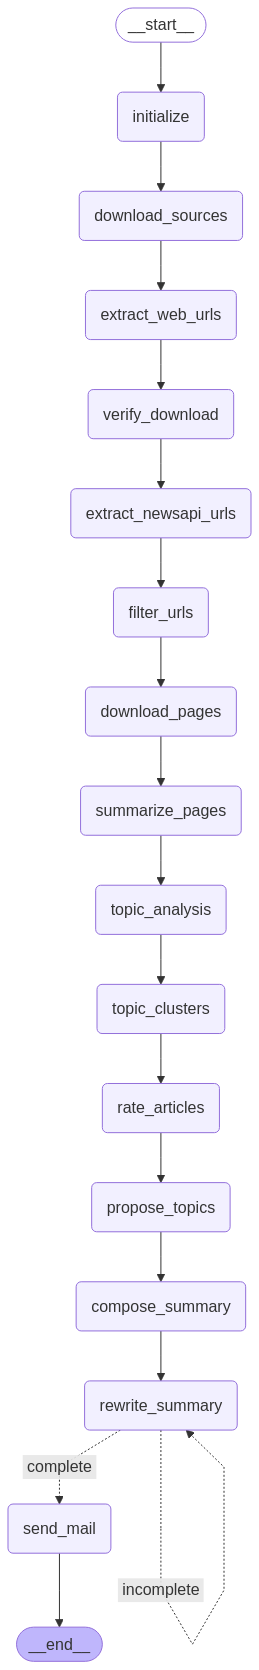

In [5]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
before_date = '2025-05-11 18:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [6]:
lg_state = lg_agent.initialize_config(lg_state)


2025-05-12 09:47:29,788 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-05-12 09:47:29,789 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-05-12 09:47:29,789 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-05-12 09:47:29,790 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-05-12 09:47:29,790 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-05-12 09:47:29,790 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly_AI.html
2025-05-12 09:47:29,790 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

In [7]:
lg_state = lg_agent.download_sources(lg_state)


2025-05-12 09:47:32,073 - AInewsbot - INFO - Web fetch disabled, using existing files in htmldata
2025-05-12 09:47:32,074 - AInewsbot - INFO - Found 16 previously downloaded files
2025-05-12 09:47:32,074 - AInewsbot - INFO - htmldata/Techmeme.html
2025-05-12 09:47:32,075 - AInewsbot - INFO - htmldata/Hacker_News_1.html
2025-05-12 09:47:32,075 - AInewsbot - INFO - htmldata/Reddit.html
2025-05-12 09:47:32,076 - AInewsbot - INFO - htmldata/HackerNoon.html
2025-05-12 09:47:32,076 - AInewsbot - INFO - htmldata/VentureBeat.html
2025-05-12 09:47:32,076 - AInewsbot - INFO - htmldata/Feedly_AI.html
2025-05-12 09:47:32,077 - AInewsbot - INFO - htmldata/The_Register.html
2025-05-12 09:47:32,077 - AInewsbot - INFO - htmldata/FT.html
2025-05-12 09:47:32,077 - AInewsbot - INFO - htmldata/Business_Insider.html
2025-05-12 09:47:32,077 - AInewsbot - INFO - htmldata/Washington_Post.html
2025-05-12 09:47:32,078 - AInewsbot - INFO - htmldata/New_York_Times.html
2025-05-12 09:47:32,078 - AInewsbot - INFO -

In [8]:
lg_state = lg_agent.extract_web_urls(lg_state)


2025-05-12 09:47:32,547 - AInewsbot - INFO - Parsing html files
2025-05-12 09:47:32,548 - AInewsbot - INFO - Ars Technica -> htmldata/Ars_Technica.html
2025-05-12 09:47:32,582 - AInewsbot - INFO - parse_file - found 168 raw links
2025-05-12 09:47:32,584 - AInewsbot - INFO - parse_file - found 35 filtered links
2025-05-12 09:47:32,584 - AInewsbot - INFO - 35 links found
2025-05-12 09:47:32,585 - AInewsbot - INFO - Bloomberg -> htmldata/Bloomberg.html
2025-05-12 09:47:32,609 - AInewsbot - INFO - parse_file - found 259 raw links
2025-05-12 09:47:32,613 - AInewsbot - INFO - parse_file - found 34 filtered links
2025-05-12 09:47:32,616 - AInewsbot - INFO - 34 links found
2025-05-12 09:47:32,616 - AInewsbot - INFO - Business Insider -> htmldata/Business_Insider.html
2025-05-12 09:47:32,636 - AInewsbot - INFO - parse_file - found 211 raw links
2025-05-12 09:47:32,638 - AInewsbot - INFO - parse_file - found 21 filtered links
2025-05-12 09:47:32,639 - AInewsbot - INFO - 21 links found
2025-05-12

In [9]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 16


,id
src,
Ars Technica,34
Bloomberg,27
Business Insider,21
FT,62
Feedly AI,34
Hacker News 1,25
Hacker News 2,19
HackerNoon,118
New York Times,19


number of missing sources 0


set()

In [10]:
lg_state = lg_agent.verify_download(lg_state)


2025-05-12 09:47:37,314 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


In [11]:
lg_state = lg_agent.extract_newsapi_urls(lg_state)


2025-05-12 09:47:37,744 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-05-11T09:47:37 from NewsAPI


In [12]:
# filter by headlines that we haven't seen and that look like AI
# we don't want to summarize all before filtering on headline
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


2025-05-12 09:47:38,170 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-05-11 18:00'
2025-05-12 09:47:38,858 - AInewsbot - INFO - URLs in orig_df: 910
2025-05-12 09:47:38,861 - AInewsbot - INFO - Existing URLs in DB: 257217
2025-05-12 09:47:38,921 - AInewsbot - INFO - New URLs in df filtered by URL: 291
2025-05-12 09:47:39,064 - AInewsbot - INFO - Existing src+title: 32
2025-05-12 09:47:39,064 - AInewsbot - INFO - New URLs in df filtered by src+title: 259
2025-05-12 09:47:39,080 - AInewsbot - INFO - Found 259 unique new headlines
2025-05-12 09:47:39,082 - AInewsbot - INFO - Found 256 unique cleaned new headlines
2025-05-12 09:47:42,098 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:47:56,603 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:47:56,635 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

,id
src,
Ars Technica,1
Bloomberg,5
Business Insider,3
FT,5
Feedly AI,27
Hacker News 1,4
Hacker News 2,4
HackerNoon,11
NewsAPI,24


In [13]:
lg_state = lg_agent.download_pages(lg_state)


2025-05-12 09:47:59,960 - AInewsbot - INFO - Queuing URLs for scraping
2025-05-12 09:47:59,965 - AInewsbot - INFO - Saving HTML files using async concurrency= 8
2025-05-12 09:48:00,282 - AInewsbot - INFO - Launching browser
2025-05-12 09:48:01,714 - AInewsbot - INFO - Launching workers
2025-05-12 09:48:01,715 - AInewsbot - INFO - Launching worker
2025-05-12 09:48:01,715 - AInewsbot - INFO - from queue: 0, https://www.techspot.com/news/107874-prompt-engineering-no-longer-job-but-skill.html , "Prompt engineering" is no longer a job, but a skill
2025-05-12 09:48:01,715 - AInewsbot - INFO - fetch_url(https://www.techspot.com/news/107874-prompt-engineering-no-longer-job-but-skill.html)
2025-05-12 09:48:01,715 - AInewsbot - INFO - File already exists: htmlpages/Prompt_engineering__is_no_longer_a_job__but_a_skill.html
2025-05-12 09:48:01,716 - AInewsbot - INFO - from queue: 1, https://www.blogger.com/comment/fullpage/post/26204193/8364173291896651584 , "Sophia's Seasons" -- A Family History P

2025-05-12 09:48:01,729 - AInewsbot - INFO - from queue: 14, https://www.bloomberg.com/news/articles/2025-05-12/amazon-backed-scale-ai-plans-middle-east-expansion-with-new-saudi-arabia-office , Amazon-Backed Scale AI Plans Middle East Expansion With New Saudi Arabia Office
2025-05-12 09:48:01,729 - AInewsbot - INFO - Skipping fetch for 14 https://www.bloomberg.com/news/articles/2025-05-12/amazon-backed-scale-ai-plans-middle-east-expansion-with-new-saudi-arabia-office Amazon-Backed Scale AI Plans Middle East Expansion With New Saudi Arabia Office
2025-05-12 09:48:01,729 - AInewsbot - INFO - from queue: 15, https://www.wired.com/story/the-metaverse-is-here-and-its-industrial/ , As the consumer metaverse falters, the World Economic Forum projects the industrial metaverse will reach $100B by 2030, led by platforms like Nvidia Omniverse
2025-05-12 09:48:01,730 - AInewsbot - INFO - fetch_url(https://www.wired.com/story/the-metaverse-is-here-and-its-industrial/)
2025-05-12 09:48:01,730 - AIne

2025-05-12 09:48:01,741 - AInewsbot - INFO - fetch_url(https://medium.com/enrique-dans/from-melody-to-machine-who-owns-the-future-of-creativity-4a0cda595b66)
2025-05-12 09:48:01,741 - AInewsbot - INFO - File already exists: htmlpages/From_melody_to_machine__who_owns_the_future_of_creativity.html
2025-05-12 09:48:01,741 - AInewsbot - INFO - from queue: 30, https://venturebeat.com/ai/from-silicon-to-sentience-the-legacy-guiding-ais-next-frontier-and-human-cognitive-migration/ , From silicon to sentience: The legacy guiding AIs next frontier and human cognitive migration
2025-05-12 09:48:01,742 - AInewsbot - INFO - fetch_url(https://venturebeat.com/ai/from-silicon-to-sentience-the-legacy-guiding-ais-next-frontier-and-human-cognitive-migration/)
2025-05-12 09:48:01,742 - AInewsbot - INFO - File already exists: htmlpages/From_silicon_to_sentience__The_legacy_guiding_AIs_next_frontier_and_human_cognitive_migration.html
2025-05-12 09:48:01,742 - AInewsbot - INFO - from queue: 31, https://hack

2025-05-12 09:48:01,749 - AInewsbot - INFO - File already exists: htmlpages/How_Yahoo_built_AI-driven_content_discovery_into_its_revamped_news_app.html
2025-05-12 09:48:01,749 - AInewsbot - INFO - from queue: 45, https://kirancodes.me/posts/log-how-to-prove-it-maths.html , How to (actually) prove it  New Frontiers of Mathematics and Computing in Lean
2025-05-12 09:48:01,749 - AInewsbot - INFO - fetch_url(https://kirancodes.me/posts/log-how-to-prove-it-maths.html)
2025-05-12 09:48:01,749 - AInewsbot - INFO - File already exists: htmlpages/How_to__actually__prove_it__New_Frontiers_of_Mathematics_and_Computing_in_Lean.html
2025-05-12 09:48:01,749 - AInewsbot - INFO - from queue: 46, https://www.geeky-gadgets.com/windsurf-ai-ios-app-development/ , How to Build iOS Apps in Record Time Using Windsurf AI
2025-05-12 09:48:01,750 - AInewsbot - INFO - fetch_url(https://www.geeky-gadgets.com/windsurf-ai-ios-app-development/)
2025-05-12 09:48:01,750 - AInewsbot - INFO - File already exists: htmlpa

2025-05-12 09:48:01,828 - AInewsbot - INFO - fetch_url(https://www.channelnewsasia.com/business/openai-negotiates-microsoft-new-funding-and-future-ipo-ft-reports-5122706)
2025-05-12 09:48:01,828 - AInewsbot - INFO - File already exists: htmlpages/OpenAI_negotiates_with_Microsoft_for_new_funding_and_future_IPO__FT_reports.html
2025-05-12 09:48:01,829 - AInewsbot - INFO - from queue: 61, https://www.ft.com/content/8d9e5149-7e4f-4886-a035-9d200204972a , OpenAI negotiates with Microsoft to unlock new funding and future IPO
2025-05-12 09:48:01,829 - AInewsbot - INFO - fetch_url(https://www.ft.com/content/8d9e5149-7e4f-4886-a035-9d200204972a)
2025-05-12 09:48:01,829 - AInewsbot - INFO - File already exists: htmlpages/OpenAI_negotiates_with_Microsoft_to_unlock_new_funding_and_future_IPO.html
2025-05-12 09:48:01,829 - AInewsbot - INFO - from queue: 62, https://www.bloomberg.com/news/articles/2025-05-11/openai-microsoft-in-talks-to-reset-high-stakes-partnership-ft , OpenAI, Microsoft in Talks t

2025-05-12 09:48:01,841 - AInewsbot - INFO - from queue: 75, https://financialpost.com/pmn/take-it-to-the-next-level-oil-and-gas-industry-players-embracing-ai-and-other-tech , Take it to the next level: Oil and gas industry players embracing AI and other tech
2025-05-12 09:48:01,841 - AInewsbot - INFO - fetch_url(https://financialpost.com/pmn/take-it-to-the-next-level-oil-and-gas-industry-players-embracing-ai-and-other-tech)
2025-05-12 09:48:01,841 - AInewsbot - INFO - File already exists: htmlpages/Take_it_to_the_next_level__Oil_and_gas_industry_players_embracing_AI_and_other_tech.html
2025-05-12 09:48:01,841 - AInewsbot - INFO - from queue: 76, https://siliconangle.com/2025/05/12/tensorstax-gets-5m-funding-automate-data-engineering-deterministic-ai-agents/ , TensorStax gets $5M in funding to automate data engineering with deterministic AI agents
2025-05-12 09:48:01,841 - AInewsbot - INFO - fetch_url(https://siliconangle.com/2025/05/12/tensorstax-gets-5m-funding-automate-data-engineer

2025-05-12 09:48:01,957 - AInewsbot - INFO - File already exists: htmlpages/Where_AI_Adds_Real_Value_in_Clinical_Development.html
2025-05-12 09:48:01,958 - AInewsbot - INFO - from queue: 91, https://www.techradar.com/computing/windows/windows-11-gets-more-ai-upgrades-we-didnt-ask-for-as-copilot-pops-up-on-the-desktop-and-microsoft-store , Windows 11 gets more AI upgrades we didnt ask for  as Copilot pops up on the desktop and Microsoft Store
2025-05-12 09:48:01,958 - AInewsbot - INFO - fetch_url(https://www.techradar.com/computing/windows/windows-11-gets-more-ai-upgrades-we-didnt-ask-for-as-copilot-pops-up-on-the-desktop-and-microsoft-store)
2025-05-12 09:48:01,958 - AInewsbot - INFO - File already exists: htmlpages/Windows_11_gets_more_AI_upgrades_we_didnt_ask_for__as_Copilot_pops_up_on_the_desktop_and_Microsoft_Store.html
2025-05-12 09:48:01,958 - AInewsbot - INFO - from queue: 92, https://hackernoon.com/windsurf-shakes-up-ai-coding-tool-market-with-generous-free-tier-and-gpt-41-acce

In [14]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


2025-05-12 09:48:21,292 - AInewsbot - INFO - Starting summarize
2025-05-12 09:48:21,294 - AInewsbot - INFO - Fetching summaries for all articles
2025-05-12 09:48:21,295 - AInewsbot - INFO - Attempting to fetch summaries for 95 articles
2025-05-12 09:48:21,305 - AInewsbot - INFO - clean_html - Page title: "Prompt engineering" is no longer a job, but a skill | TechSpot
Social card title: "Prompt engineering" is no longer a job, but a skill
Social card description: Just two years ago, prompt engineering was the talk of the tech world – a seemingly essential new job born from the rapid rise of artificial intelligence....

2025-05-12 09:48:21,438 - AInewsbot - INFO - Queuing 0: Page title: "Prompt engineering" is no longer a jo...
2025-05-12 09:48:21,442 - AInewsbot - INFO - clean_html - Page title: Post a Comment

2025-05-12 09:48:21,452 - AInewsbot - INFO - Queuing 1: Page title: Post a Comment
Comments on "Sophia's S...
2025-05-12 09:48:21,463 - AInewsbot - INFO - clean_html - Page title

2025-05-12 09:48:22,386 - AInewsbot - INFO - Queuing 17: Page title: Can AI Dream? Rethinking Consciousness...
2025-05-12 09:48:22,408 - AInewsbot - INFO - clean_html - Page title: ChatGPT says AI won't doom humanity — climate disasters will | Windows Central
Social card title: ChatGPT predicts the end of humanity — but AI isn't its first candidate
Social card description: OpenAI's chatbot doesn't think AI is a major threat to humanity, and we should focus more on a climate-induced collapse.

2025-05-12 09:48:22,449 - AInewsbot - INFO - Queuing 18: Page title: ChatGPT says AI won't doom humanity — ...
2025-05-12 09:48:22,458 - AInewsbot - INFO - clean_html - Page title: Chinese Tech Giant Wants to Translate Your Cat's Meows Using AI
Social card title: Chinese Tech Giant Wants to Translate Your Cat's Meows Using AI
Social card description: Chinese tech company Baidu is working on an artificial intelligence-based translation system that could tell you what your meowing cat is trying to t

2025-05-12 09:48:23,197 - AInewsbot - INFO - clean_html - Page title: Google’s AI image-to-video generator launches on Honor’s new phones | The Verge
Social card title: Google’s AI image-to-video generator launches on Honor’s new phones
Social card description: Honor 400 buyers will be the first to try Google’s effort at creating videos from images on a phone.

2025-05-12 09:48:23,231 - AInewsbot - INFO - Queuing 34: Page title: Google’s AI image-to-video generator l...
2025-05-12 09:48:23,244 - AInewsbot - INFO - clean_html - Page title: Subscribe to read
Social card title: How AI agents compare on routine work tasks
Social card description: The FT tested top apps from OpenAI, Anthropic, Google and more with requests to write emails, book travel and summarise the news

2025-05-12 09:48:23,261 - AInewsbot - INFO - Queuing 35: Page title: Subscribe to read
Social card title: H...
2025-05-12 09:48:23,268 - AInewsbot - INFO - clean_html - Page title: How AI could help safeguard Indigenous

2025-05-12 09:48:24,315 - AInewsbot - INFO - Queuing 51: Page title: INTELLECT-2 Release: The First Globall...
2025-05-12 09:48:24,334 - AInewsbot - INFO - clean_html - Page title: Is AI the future of America's foreign policy? Some experts think so | Georgia Public Broadcasting
Social card title: Is AI the future of America's foreign policy? Some experts think so
Social card description: Large language models like ChatGPT and DeepSeek are increasingly being looked at for their potential to help make decisions in high-stakes situations.

2025-05-12 09:48:24,353 - AInewsbot - INFO - Queuing 52: Page title: Is AI the future of America's foreign ...
2025-05-12 09:48:24,370 - AInewsbot - INFO - clean_html - Page title: Israeli quantum computing firm Classiq raises $110 million in private funding | Reuters
Social card title: Israeli quantum computing firm Classiq raises $110 million in private funding
Social card description: Israeli quantum computing startup Classiq has raised $110 million 

2025-05-12 09:48:25,419 - AInewsbot - INFO - Queuing 70: Page title: Scientists clear major roadblocks in m...
2025-05-12 09:48:25,433 - AInewsbot - INFO - clean_html - Page title: Singapore’s Vision for AI Safety Bridges the US-China Divide | WIRED
Social card title: Singapore’s Vision for AI Safety Bridges the US-China Divide
Social card description: In a rare moment of global consensus, AI researchers from the US, Europe, and Asia came together in Singapore to form a plan for researching AI risks.

2025-05-12 09:48:25,460 - AInewsbot - INFO - Queuing 71: Page title: Singapore’s Vision for AI Safety Bridg...
2025-05-12 09:48:25,461 - AInewsbot - INFO - No path for 72
2025-05-12 09:48:25,473 - AInewsbot - INFO - clean_html - Page title: SoundCloud latest company to hit trouble with AI clause in T&Cs - 9to5Mac
Social card title: SoundCloud latest company to hit trouble with AI clause in T&Cs - 9to5Mac
Social card description: SoundCloud is the latest company to run into trouble after q

2025-05-12 09:48:26,186 - AInewsbot - INFO - Queuing 90: Page title: Where AI Adds Real Value in Clinical D...
2025-05-12 09:48:26,210 - AInewsbot - INFO - clean_html - Page title: Windows 11 gets more AI upgrades we didn’t ask for – as Copilot pops up on the desktop and Microsoft Store | TechRadar
Social card title: Windows 11 gets more AI upgrades we didn’t ask for – as Copilot pops up on the desktop and Microsoft Store
Social card description: Upgrades, or more clutter? You’ll be the judge of that…

2025-05-12 09:48:26,251 - AInewsbot - INFO - Queuing 91: Page title: Windows 11 gets more AI upgrades we di...
2025-05-12 09:48:26,266 - AInewsbot - INFO - clean_html - Page title: Windsurf Shakes Up AI Coding Tool Market With Generous Free Tier and GPT-4.1 Access | HackerNoon
Social card title: Windsurf Shakes Up AI Coding Tool Market With Generous Free Tier and GPT-4.1 Access | HackerNoon
Social card description: Windsurf has rolled out a major revamp of their pricing and offering.

20

2025-05-12 09:48:29,732 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:48:29,742 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:48:29,749 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:48:29,804 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:48:29,829 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:48:29,845 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:48:29,967 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:48:30,021 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:48:30,172 - httpx 

2025-05-12 09:48:34,696 - AInewsbot - INFO - Summary for 7 (length 1529): • Artificial intelligence is increasingly threatening to disrupt major search engine companies, with new advancements potentially changing how users find information online.
• AMD's market position as a competitor to Nvidia is reported to be the strongest it has ever been, reflecting recent performance and technological developments.
• Leading CEOs have called for greater education and awareness around AI, underlining the growing importance of understanding and navigating AI's impacts in the tech sector.
2025-05-12 09:48:34,696 - AInewsbot - INFO - Summary for 8 (length 5821): • A critical failure in an AI triage system at a national healthcare provider deprioritized urgent patient cases due to the model prioritizing ticket volume over patient needs, prompting a complete reevaluation of the team's AI development approach.

• In response, the team adopted mandatory ethics reviews, implemented user feedback mechani

2025-05-12 09:48:34,700 - AInewsbot - INFO - Summary for 19 (length 3294): • Chinese tech company Baidu has filed a patent for an AI-based system designed to translate animal vocalizations, such as cat meows and dog barks, aiming to improve communication between humans and their pets.
• The system is "still in the research phase," according to a Baidu spokesperson, and whether it will succeed in accurately translating animal sounds is uncertain as scientists have yet to fully decipher animal communication.
• Baidu joins other organizations, such as the Earth Species Project and NatureLM, in using AI to decode animal languages, with global research efforts spanning birds, dolphins, elephants, crows, monkeys, and even whales.
2025-05-12 09:48:34,700 - AInewsbot - INFO - Summary for 20 (length 39422): • Researchers at Sakana AI have introduced the Continuous Thought Machine (CTM), a novel neural network architecture that incorporates neural timing and synchronization—key properties of bio

2025-05-12 09:48:34,703 - AInewsbot - INFO - Summary for 30 (length 11757): • The article discusses the ongoing "cognitive migration" brought about by AI advancements, with humans shifting from tasks now performed by machines to domains emphasizing creativity, ethical judgment, and emotional insight.

• IBM's 2015 declaration of the "Cognitive Era," led by CEO Ginni Rometty, marked a significant change in framing AI as collaborative "augmented intelligence" rather than a competitor, but also acknowledged the vulnerability of traditional cognitive labor to automation.

• The current AI-driven transition is happening far more rapidly than past industrial or digital revolutions and challenges individuals and institutions to redefine what makes human contribution unique as machines increasingly master tasks once considered exclusively human.
2025-05-12 09:48:34,703 - AInewsbot - INFO - Summary for 31 (length 5541): • Large Language Models like GPT are transforming how users interact with E

2025-05-12 09:48:34,707 - AInewsbot - INFO - Summary for 44 (length 28): no content
2025-05-12 09:48:34,707 - AInewsbot - INFO - Summary for 45 (length 10050): • Prominent mathematicians, including Terence Tao and Kevin Buzzard, are using the Lean theorem prover to formalize and verify new, advanced mathematical results, offering machine-checked proofs and unprecedented transparency into the proof-writing process.
• A new tool called Lean Blueprints is being used to plan and track the progress of formalizations, mapping definitions, lemmas, and theorems as nodes in a graph with color-coded statuses, providing insight into how mathematical proofs are constructed and evolve.
• Visualizations and data extracted from Lean Blueprint version histories of high-profile projects (such as the Polynomial Freiman Ruzsa conjecture, Kelley-Meka bound, Carleson's theorem, and Fermat's Last Theorem) reveal diverse patterns in proof development and collaboration, marking a shift toward mathematician-le

2025-05-12 09:48:34,708 - AInewsbot - INFO - Summary for 55 (length 4328): • Researchers at Carnegie Mellon University have developed LegoGPT, an AI model that generates physically buildable Lego designs from text prompts, constrained to a 20 x 20 x 20 grid and using eight basic brick types.  
• The system ensures physical stability by generating multiple structural variations and performing stability analysis to discard unstable designs, with the aim to inspire and speed up the brainstorming and prototyping process for creators.  
• Researcher Ava Pun stated, "We integrate physical laws and assembly constraints into generative models such as LLMs, enabling us to create objects that function in the real world... We see it being useful for inspiring new ideas and sketching out initial designs super fast."  
• The team plans to expand the system’s object categories, dimensions, and brick library in future work; Lego declined to comment on the research.
2025-05-12 09:48:34,708 - AInewsbot

2025-05-12 09:48:34,710 - AInewsbot - INFO - Summary for 68 (length 13703): • The article explains the use of the Fast Sweeping Method (FSM) for solving the Eikonal equation and constructing signed distance functions (SDFs) using JAX, highlighting its advantages for fast and reliable computation of wavefront and surface distance problems on grids.

• Benchmark comparisons show that JAX-compiled FSM code outperforms NumPy implementations on CPU, though C++ implementations (like skfmm) remain faster, with the tradeoff being Python's flexibility and ease of customization for domain-specific problems.

• The author attempted to parallelize FSM using JAX, referencing Hongkai Zhao's parallel sweeps method, but encountered limitations due to JAX's tracing requirements and inability to vmap certain variable-dependent computations.
2025-05-12 09:48:34,710 - AInewsbot - INFO - Summary for 69 (length 4651): • OpenAI CEO Sam Altman stated he does not want his newborn son to have an AI "best friend

2025-05-12 09:48:34,712 - AInewsbot - INFO - Summary for 82 (length 9208): • A close examination of OpenAI CEO Sam Altman’s kitchen revealed that he uses expensive “Drizzle” finishing olive oil for frying instead of the intended cheaper options, indicating wasteful spending habits.  
• Altman’s kitchen features a high-end Breville Oracle Touch coffee machine, which is known for reliability issues and unnecessary accessories, adding to operational inefficiency.  
• His choice of kitchen knife is a hybrid with inconsistent design elements, either a costly artisan piece or a low-quality mass-produced model, further suggesting questionable purchasing decisions.
2025-05-12 09:48:34,712 - AInewsbot - INFO - Summary for 83 (length 1840): no content
2025-05-12 09:48:34,712 - AInewsbot - INFO - Summary for 84 (length 969): • The United Arab Emirates is set to introduce artificial intelligence (AI) classes for children as young as four years old, as part of efforts to establish itself as a regio

2025-05-12 09:48:34,713 - AInewsbot - INFO - Summary for 94 (length 1353): no content
2025-05-12 09:48:34,714 - AInewsbot - INFO - Received 89 summaries


In [16]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


2025-05-12 09:48:55,624 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-12 09:49:17,733 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:20,851 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:21,904 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:21,941 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:23,390 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:23,403 - AInewsbot - INFO - 95 free-form topics extracted
2025-05-12 09:49:23,405 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-12 09:49:23,405 - AInewsbot - IN

2025-05-12 09:49:23,431 - AInewsbot - INFO - Canonical topic sports
2025-05-12 09:49:23,431 - AInewsbot - INFO - Canonical topic consciousness
2025-05-12 09:49:23,431 - AInewsbot - INFO - Canonical topic hollywood
2025-05-12 09:49:23,432 - AInewsbot - INFO - Canonical topic russia
2025-05-12 09:49:23,432 - AInewsbot - INFO - Canonical topic artist rights
2025-05-12 09:49:23,432 - AInewsbot - INFO - Canonical topic privacy
2025-05-12 09:49:23,432 - AInewsbot - INFO - Canonical topic opinion
2025-05-12 09:49:23,432 - AInewsbot - INFO - Canonical topic smart grid
2025-05-12 09:49:23,433 - AInewsbot - INFO - Canonical topic cybersecurity
2025-05-12 09:49:23,433 - AInewsbot - INFO - Canonical topic safety and alignment
2025-05-12 09:49:23,433 - AInewsbot - INFO - Canonical topic healthcare
2025-05-12 09:49:23,433 - AInewsbot - INFO - Canonical topic tv & film & movies
2025-05-12 09:49:23,433 - AInewsbot - INFO - Canonical topic ai advancements
2025-05-12 09:49:23,434 - AInewsbot - INFO - Ca

2025-05-12 09:49:35,269 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:35,276 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:35,283 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:35,312 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:35,313 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:35,321 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:35,358 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:35,368 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:35,386 - httpx 

2025-05-12 09:49:37,038 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:37,059 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:37,077 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:37,084 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:37,093 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:37,100 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:37,118 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:37,132 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:37,145 - httpx 

2025-05-12 09:49:38,401 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:38,410 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:38,422 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:38,425 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 503 Service Unavailable"
2025-05-12 09:49:38,429 - openai._base_client - INFO - Retrying request to /chat/completions in 0.790851 seconds
2025-05-12 09:49:38,436 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:38,436 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:38,456 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:38,500

2025-05-12 09:49:39,953 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:40,043 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:40,045 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:40,066 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:40,089 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:40,150 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:40,203 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:40,255 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:40,364 - httpx 

2025-05-12 09:49:42,202 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:42,218 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:42,223 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:42,259 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:42,265 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:42,275 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:42,297 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:42,329 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:42,334 - httpx 

2025-05-12 09:49:43,832 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:43,834 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:43,848 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:43,850 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:43,851 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:43,851 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:43,866 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:43,870 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:43,871 - httpx 

2025-05-12 09:49:44,761 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:44,781 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:44,783 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:44,875 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:44,890 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:44,899 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:44,901 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:44,982 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:44,992 - httpx 

2025-05-12 09:49:46,371 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:46,373 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:46,393 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:46,425 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:46,428 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:46,438 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:46,450 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:46,452 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:46,460 - httpx 

2025-05-12 09:49:48,203 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:48,228 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:48,232 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:48,234 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:48,266 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:48,299 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:48,341 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:48,343 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:49:48,410 - httpx 

2025-05-12 09:50:01,223 - AInewsbot - INFO - Queuing 9: ### <<<ARTICLE SUMMARY>>>
# AI technology helps re...
2025-05-12 09:50:01,223 - AInewsbot - INFO - Queuing 10: ### <<<ARTICLE SUMMARY>>>
# Agile Is Getting Noisy...
2025-05-12 09:50:01,223 - AInewsbot - INFO - Queuing 11: ### <<<ARTICLE SUMMARY>>>
# AirPods and Apple Watc...
2025-05-12 09:50:01,245 - AInewsbot - INFO - Queuing 12: ### <<<ARTICLE SUMMARY>>>
# AllTrails is the lates...
2025-05-12 09:50:01,245 - AInewsbot - INFO - Queuing 13: ### <<<ARTICLE SUMMARY>>>
# Almost Timely News:  H...
2025-05-12 09:50:01,245 - AInewsbot - INFO - Queuing 14: ### <<<ARTICLE SUMMARY>>>
# Amazon-Backed Scale AI...
2025-05-12 09:50:01,245 - AInewsbot - INFO - Queuing 15: ### <<<ARTICLE SUMMARY>>>
# As the consumer metave...
2025-05-12 09:50:01,245 - AInewsbot - INFO - Queuing 16: ### <<<ARTICLE SUMMARY>>>
# Blockchain Emerges as ...
2025-05-12 09:50:01,246 - AInewsbot - INFO - Queuing 17: ### <<<ARTICLE SUMMARY>>>
# Can AI Dream? Rethinki...
20

2025-05-12 09:50:01,254 - AInewsbot - INFO - Queuing 83: ### <<<ARTICLE SUMMARY>>>
# Tired of importing US ...
2025-05-12 09:50:01,254 - AInewsbot - INFO - Queuing 84: ### <<<ARTICLE SUMMARY>>>
# UAE to introduce AI cl...
2025-05-12 09:50:01,254 - AInewsbot - INFO - Queuing 85: ### <<<ARTICLE SUMMARY>>>
# US Copyright Office fo...
2025-05-12 09:50:01,255 - AInewsbot - INFO - Queuing 86: ### <<<ARTICLE SUMMARY>>>
# US Copyright Office: G...
2025-05-12 09:50:01,255 - AInewsbot - INFO - Queuing 87: ### <<<ARTICLE SUMMARY>>>
# Visual Studio Code 1.1...
2025-05-12 09:50:01,255 - AInewsbot - INFO - Queuing 88: ### <<<ARTICLE SUMMARY>>>
# Walgreens doubles down...
2025-05-12 09:50:01,255 - AInewsbot - INFO - Queuing 89: ### <<<ARTICLE SUMMARY>>>
# Wavefront Frontier Alg...
2025-05-12 09:50:01,255 - AInewsbot - INFO - Queuing 90: ### <<<ARTICLE SUMMARY>>>
# Where AI Adds Real Val...
2025-05-12 09:50:01,255 - AInewsbot - INFO - Queuing 91: ### <<<ARTICLE SUMMARY>>>
# Windows 11 gets more A...
2

async_langchain: 0, {'input_text': '### <<<ARTICLE SUMMARY>>>\n# "Prompt engineering" is no longer a job, but a skill\n\n• The role of "prompt engineering" as a standalone job has largely disappeared, becoming an expected skill for anyone working with AI rather than a separate position, as companies now often use AI tools to generate prompts themselves.\n\n• Industry experts note that the AI job market is shifting toward roles requiring deeper technical expertise, such as machine learning engineers, with prompt engineering responsibilities being folded into broader job descriptions rather than listed as dedicated positions.\n\n• The initial hype around prompt engineering, which was valued at $75.5 million in North America in 2023, has faded as demand moves toward advisory and consulting roles, and as employers seek candidates who can implement and optimize AI rather than simply prompt it.\n### <<<END>>>\n### <<<CANDIDATE TOPICS>>>\nAI Adoption, AI Advancements, AI Job Market, AI Tools,

2025-05-12 09:50:01,931 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:02,012 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:02,035 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:02,062 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 11 response: items=['Apple AI Cameras', 'AirPods', 'Apple Watch', 'Smart Glasses', 'Computer Vision', 'Semiconductor Chips', 'AI Advancements']
async_langchain: 86 response: items=['Generative AI', 'Intellectual Property', 'US Copyright Office', 'Fair Use']
async_langchain: 54 response: items=['AI Chatbot', 'Customer Service', 'Human Support', 'Jobs & Careers', 'Klarna Customer Service', 'Remote Model', 'Quality Assurance']
async_langchain: 81 response: items=['AI In Insurance', 'Insurance Claims', 'Healthcare', 'Legal Issues', 'Society & Culture']


2025-05-12 09:50:02,352 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:02,410 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:02,420 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:02,486 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 57 response: items=[]
async_langchain: 61 response: items=[]
async_langchain: 3 response: items=[]
async_langchain: 83 response: items=[]


2025-05-12 09:50:02,562 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:02,644 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 94 response: items=[]
async_langchain: 32 response: items=['Funding', 'Venture Capital']


2025-05-12 09:50:02,944 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:02,946 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:02,982 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:02,998 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,046 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,056 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,076 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,083 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,093 - httpx 

async_langchain: 35 response: items=[]
async_langchain: 74 response: items=[]
async_langchain: 75 response: items=[]
async_langchain: 39 response: items=[]
async_langchain: 42 response: items=[]
async_langchain: 14 response: items=['Amazon Backing', 'Middle East Expansion', 'Saudi Arabia', 'Scale AI']
async_langchain: 72 response: items=['Investment Opportunities', 'Venture Capital', 'OpenAI']
async_langchain: 5 response: items=['AI Drug Firm', 'Hong Kong', 'IPO', 'Investment Opportunities', 'Funding', 'Healthcare']
async_langchain: 44 response: items=[]


2025-05-12 09:50:03,206 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,209 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,211 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,236 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,286 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,302 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,420 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 0 response: items=['AI Job Market', 'Machine Learning Engineering', 'Prompt Engineering', 'Consulting Roles', 'AI Tools']
async_langchain: 1 response: items=[]
async_langchain: 7 response: items=['AI Disruption', 'AMD', 'Education', 'Search Engines', 'Nvidia']
async_langchain: 64 response: items=['AI Implications', 'Education Reform', 'Critical Thinking', 'Learning Cultures', 'Hannah Arendt']
async_langchain: 38 response: items=['AI In Gaming', 'Candy Crush Saga', 'Game Development', 'Player Engagement', 'Content Automation', 'AI Adoption']
async_langchain: 60 response: items=['AI Funding', 'IPO Negotiations', 'Technology Partnerships', 'Microsoft', 'OpenAI']


2025-05-12 09:50:03,460 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,470 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,488 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,495 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,496 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,498 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,505 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,509 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,528 - httpx 

async_langchain: 82 response: items=['Sam Altman', 'CEO Lifestyle', 'Kitchen Analysis', 'Purchasing Habits', 'Products']
async_langchain: 21 response: items=['Generative AI', 'E-Commerce Catalog Management', 'Image Generation Technologies', 'Large Language Models', 'Product Description Automation', 'Retail Challenges']
async_langchain: 91 response: items=['AI Upgrades', 'Copilot AI', 'Microsoft', 'Windows 11', 'User Experience']
async_langchain: 62 response: items=['Partnership Negotiations', 'Mergers and Acquisitions', 'OpenAI', 'Microsoft', 'Deals']
async_langchain: 69 response: items=['AI Companionship', 'Child Safety', 'Ethics', 'Microsoft Copilot', 'Sam Altman', 'Privacy', 'Tech Ethics']
async_langchain: 25 response: items=['Blockchain AI Integration', 'Cryptocurrency', 'Ethereum Price Predictions', 'Investment Opportunities', 'Ruvi AI Cryptocurrency', 'Supply And Demand Dynamics']
async_langchain: 65 response: items=['AI Influence', 'Ethical Challenges', 'Human Dignity', 'Social 

2025-05-12 09:50:03,648 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,659 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,667 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,683 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,684 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,696 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,701 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,734 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,736 - httpx 

async_langchain: 50 response: items=['AI Adoption', 'Corporate India Risk Index', 'Cybersecurity', 'Risk Management', 'Sustainability', 'India']
async_langchain: 59 response: items=['ChatGPT Performance', 'OpenAI Quality Decline', 'Technical Issues', 'Model Rollback', 'User Feedback', 'Generative AI']
async_langchain: 19 response: items=['AI Advancements', 'Animal Communication', 'Baidu AI Patent', 'Pet Technology', 'Translating Vocalizations', 'Research Phase']
async_langchain: 55 response: items=['AI In Design', 'Generative AI', 'LegoGPT', 'Physical Stability', 'Rapid Prototyping']
async_langchain: 29 response: items=['Generative AI Impact', 'Copyright Concerns', 'Artist Rights', 'Music Industry', 'Technological Progress', 'Policy and Regulation']
async_langchain: 53 response: items=['Classiq Funding', 'Investment Opportunities', 'Quantum Computing', 'Software for Quantum Applications', 'Enterprise Partnerships', 'Venture Capital']
async_langchain: 27 response: items=['Ruvi AI Crypto

2025-05-12 09:50:03,889 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,909 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,930 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,945 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:03,947 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:04,034 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:04,059 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 93 response: items=['Large Language Models', 'Multi-Head Attention', 'Self-Attention', 'Transformers', 'GPT-3', 'AI Advancements']
async_langchain: 24 response: items=['AI-Driven Fraud', 'Deepfake Technology', 'Identity Verification', 'Online Scams', 'Society & Culture']
async_langchain: 71 response: items=['AI Safety', 'Global Collaboration', 'International Cooperation', 'Singapore Blueprint', 'AI Risks']
async_langchain: 28 response: items=['Answer Engine Optimization', 'AI Marketing', 'AI Chatbot Impact', 'Content Optimization', 'Generative AI', 'Venture Capital', 'Search Engine Evolution']
async_langchain: 70 response: items=['AI Advancements', 'Integration Challenges', 'Photonic Microchips', 'Scalability', 'Lightelligence', 'Generative AI', 'Hardware']
async_langchain: 67 response: items=['Generative AI', 'Marketing Strategies', 'Retraining Teams', 'Organizational Challenges', 'Revenue Growth']
async_langchain: 13 response: items=['AI In Advertising', 'Ethical AI 

2025-05-12 09:50:04,130 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:04,142 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:04,144 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:04,159 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:04,166 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:04,168 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:04,181 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:04,183 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:04,204 - httpx 

async_langchain: 79 response: items=['AI Model Training', 'Copyright Enforcement', 'Fair Use', 'Intellectual Property', 'Legal Issues', 'Policy And Regulation', 'US Copyright Office']
async_langchain: 31 response: items=['AI-Assisted Productivity', 'Generative AI', 'Gpt In Excel', 'Large Language Models', 'Formula Optimization', 'User Interaction Improvement']
async_langchain: 4 response: items=['Foresight AI Model', 'NHS Data', 'Data Privacy', 'Ethical Concerns', 'Healthcare Predictions', 'Legal Issues', 'Policy and Regulation']
async_langchain: 73 response: items=['AI Terms and Conditions', 'Artist Rights', 'Legal Issues', 'SoundCloud', 'T&C Backlash', 'User Content']
async_langchain: 90 response: items=['AI Governance', 'AI in Clinical Trials', 'Data Harmonization', 'Data Privacy', 'Patient Recruitment', 'Safety and Alignment', 'Quantum Computing']
async_langchain: 76 response: items=['AI Automation', 'Data Engineering', 'Deterministic AI', 'Funding', 'TensorStax', 'Venture Capital'

2025-05-12 09:50:04,365 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:04,387 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:04,411 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:04,412 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:04,444 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:04,508 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 58 response: items=['AI Adoption', 'Digital Innovation', 'Oil And Gas Technology', 'Generative AI', 'Robotics In Industry', 'Drones', 'Operational Efficiency']
async_langchain: 77 response: items=['AI Deployment Challenges', 'Memory Efficiency', 'Scaling Issues', 'State Space Models', 'Transformers']
async_langchain: 92 response: items=['AI Coding Tools', 'Developer Community', 'OpenAI Acquisition', 'Pricing Strategy', 'Windsurf', 'Generative AI', 'Mergers And Acquisitions']
async_langchain: 9 response: items=['AI Pet Reunification', 'AI Advancements', 'Photo Matching', 'Lost Pets Technology', 'Petco Love Lost', 'Shelter Data', 'User Experience']
async_langchain: 46 response: items=['AI Coding Tools', 'iOS App Development', 'OpenAI Acquisition', 'Rapid Prototyping', 'User Experience', 'Windsurf AI']
async_langchain: 52 response: items=['AI In Foreign Policy', 'AI Model Training', 'Model Biases', 'Negotiation Tools', 'Diplomacy Technology', 'Pentagon-Funded Research', '

2025-05-12 09:50:05,569 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:05,584 - AInewsbot - INFO - Received 95 responses
2025-05-12 09:50:05,588 - AInewsbot - INFO - End topic analysis


async_langchain: 87 response: items=['AI-Assisted Coding', 'Development Tools', 'Node.js Updates', 'Visual Studio Code', 'Testing', 'Programming Enhancements']


In [17]:
lg_state = lg_agent.topic_clusters(lg_state)


2025-05-12 09:50:05,600 - AInewsbot - INFO - Fetching embeddings for 95 headlines
2025-05-12 09:50:06,833 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-05-12 09:50:07,513 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-05-12 09:50:07,531 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-05-12 09:50:08,804 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-12 09:50:12,270 - AInewsbot - INFO - Cluster with DBSCAN
2025-05-12 09:50:12,367 - AInewsbot - INFO - Found 7 clusters


,title_topic_str
0,"Oil and gas industry players embracing AI and other tech (Topics: AI Adoption, Digital Innovation, Oil And Gas Technology, Generative AI, Robotics In Industry, Drones, Operational Efficiency)"
1,"'Take it to the next level': Oil and gas industry players embracing AI and other tech (Topics: AI In Oil And Gas, Generative AI, Automation, Cybersecurity, Robots, Drones, Economics)"
2,Take it to the next level: Oil and gas industry players embracing AI and other tech (Topics: )
3,"How India aims to become a regional data center hub, leveraging its low energy pricing and AI-skilled workforce; power supply constraints pose a major challenge (Financial Times) (Topics: )"


2025-05-12 09:50:13,495 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:13,519 - AInewsbot - INFO - I dub this cluster: AI and Tech in Energy Sector


,title_topic_str
4,"How AI is changing your doctors appointments (Topics: AI in Healthcare, Appointment Scheduling, Autonomous AI Applications, Patient Engagement, Administrative Efficiency, AI Advancements, Automation)"
5,"A look at Foresight, an AI model trained on anonymized NHS data from 57M people in England, which could help predict diseases or forecast hospitalization rates (Topics: Foresight AI Model, NHS Data, Data Privacy, Ethical Concerns, Healthcare Predictions, Legal Issues, Policy and Regulation)"
6,"Where AI Adds Real Value in Clinical Development (Topics: AI Governance, AI in Clinical Trials, Data Harmonization, Data Privacy, Patient Recruitment, Safety and Alignment, Quantum Computing)"


2025-05-12 09:50:14,580 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:14,589 - AInewsbot - INFO - I dub this cluster: AI Transforming Healthcare Practices


,title_topic_str
7,"How Tokenizer Choices Shape Hidden Risks in Popular Language Models (Topics: Tokenizers, Large Language Models, Under-Trained Tokens, AI Model Training, Model Training Data)"
8,"Intellect-2 Release: The First 32B Model Trained Through Globally Distributed RL (Topics: Decentralized Reinforcement Learning, Intellect-2, AI Model Training, Open Source Research, Reinforcement Learning, Language Models, Verifiable Tasks)"
9,"How Many Glitch Tokens Hide in Popular LLMs? Revelations from Large-Scale Testing (Topics: Glitch Tokens, Large Language Models, LLM Testing, Token Frequency, Under-Trained Tokens)"
10,byLarge Models (dot tech)@largemodels (Topics: )
11,"Writing an LLM from scratch, part 13 attention heads are dumb (Topics: Large Language Models, Multi-Head Attention, Self-Attention, Transformers, GPT-3, AI Advancements)"


2025-05-12 09:50:15,418 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:15,435 - AInewsbot - INFO - I dub this cluster: Advancements and Challenges in Large Language Models


,title_topic_str
12,"LegoGPT is here to make your blocky dreams come true (Topics: AI In Design, Generative AI, LegoGPT, Physical Stability, Rapid Prototyping)"
13,"LegoGPT is here to make your blocky dreams come trueAs long as those fit into a 20 x 20 x 20 grid and can be built from 8 basic bricksAI + ML1 hr|6 (Topics: AI Advancements, AI Design Constraints, Generative AI, Physically Buildable Designs, Early-Stage Design, Legogpt, Prompt Engineering)"
14,"The tinkerers who opened up a fancy coffee maker to AI brewing (Topics: AI Brewing, Generative AI, Coffee Recipes, Large Language Models, Fellow Aiden, Brandon Dixon, Lifestyle & Travel)"


2025-05-12 09:50:16,246 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:16,255 - AInewsbot - INFO - I dub this cluster: Generative AI Innovations in Design


,title_topic_str
15,Sources: OpenAI is negotiating with Microsoft to enable a future IPO; Microsoft is offering to cut its equity stake for access to OpenAI's tech beyond 2030 (Topics: )
16,OpenAI negotiates with Microsoft to unlock new funding and future IPO (Topics: )
17,"OpenAI negotiates with Microsoft for new funding and future IPO, FT reports (Topics: AI Funding, IPO Negotiations, Technology Partnerships, Microsoft, OpenAI)"


2025-05-12 09:50:17,386 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:17,393 - AInewsbot - INFO - I dub this cluster: OpenAI-Microsoft IPO Negotiations


,title_topic_str
18,"Rewiring marketing mindsets for the generative AI revolution (Topics: Generative AI, Marketing Strategies, Retraining Teams, Organizational Challenges, Revenue Growth)"
19,"Almost Timely News: How To Make a 30 Second Spot with AI (2025-05-11) (Topics: AI In Advertising, Ethical AI Use, Legal Considerations, Generative AI, Creative Tools, Subject Matter Expertise)"
20,"Council Post: Leveraging Generative AI In E-Commerce For Catalog Enrichment (Topics: Generative AI, E-Commerce Catalog Management, Image Generation Technologies, Large Language Models, Product Description Automation, Retail Challenges)"


2025-05-12 09:50:18,251 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:18,259 - AInewsbot - INFO - I dub this cluster: Generative AI Transforming Marketing


,title_topic_str
21,"SoundCloud latest company to hit trouble with AI clause in T&Cs (Topics: AI Terms and Conditions, Artist Rights, Legal Issues, SoundCloud, T&C Backlash, User Content)"
22,"From melody to machine: who owns the future of creativity? (Topics: Generative AI Impact, Copyright Concerns, Artist Rights, Music Industry, Technological Progress, Policy and Regulation)"
23,"The US Copyright Office has thoughts on how AI is trained. Big Tech may not like it. (Topics: AI Model Training, Copyright Enforcement, Fair Use, Intellectual Property, Legal Issues, Policy And Regulation, US Copyright Office)"
24,"US Copyright Office found AI companies breach copyright. Its boss was fired (Topics: AI Copyright, Generative AI Litigation, Fair Use, Intellectual Property, Policy And Regulation, Us Copyright Office, Shira Perlmutter)"


2025-05-12 09:50:19,090 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:19,096 - AInewsbot - INFO - I dub this cluster: AI Copyright and Artist Rights Disputes
2025-05-12 09:50:19,107 - AInewsbot - INFO - ['AI and Tech in Energy Sector', 'AI Transforming Healthcare Practices', 'Advancements and Challenges in Large Language Models', 'Generative AI Innovations in Design', 'OpenAI-Microsoft IPO Negotiations', 'Generative AI Transforming Marketing', 'AI Copyright and Artist Rights Disputes']


In [18]:
lg_state = lg_agent.rate_articles(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
aidf


2025-05-12 09:50:19,131 - AInewsbot - INFO - Calculating article rating for 95 articles
2025-05-12 09:50:19,131 - AInewsbot - INFO - Starting low_quality filter
2025-05-12 09:50:24,732 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:26,021 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:26,034 - AInewsbot - INFO - low quality articles: {0: 72, 1: 23}
2025-05-12 09:50:26,035 - AInewsbot - INFO - Starting on_topic filter
2025-05-12 09:50:32,650 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:35,184 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:50:35,193 - AInewsbot - INFO - on topic articles: {1: 81, 0: 14}
2025-05-12 09:50:35,194 - AInewsbot - INFO - Starting importance filter
2025-05-12 09:50:38,247 - httpx - INFO - HTTP Reques

[(22, 79), (12, 44), (16, 76), (19, 48), (56, 70), (24, 86), (7, 30), (17, 74), (50, 65), (71, 85), (18, 90), (23, 89), (9, 80), (73, 91), (52, 72), (54, 62), (27, 46), (49, 75), (78, 87), (1, 94), (10, 77), (0, 43), (40, 63), (83, 92), (69, 84), (33, 35), (25, 28), (34, 61), (15, 39), (21, 47), (55, 81), (37, 82), (64, 66), (36, 42), (4, 57), (26, 93), (13, 14), (20, 60), (53, 68), (6, 51), (5, 45), (41, 67), (32, 59), (31, 58), (3, 8), (38, 88), (11, 29)]


2025-05-12 09:51:08,061 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:51:08,580 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:51:09,043 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:51:09,590 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:51:10,317 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:51:11,153 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:51:11,660 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:51:12,109 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:51:12,832 - httpx 

[(51, 82), (7, 40), (53, 59), (54, 66), (52, 71), (69, 86), (46, 70), (1, 3), (27, 35), (18, 39), (25, 43), (19, 92), (28, 37), (10, 47), (6, 83), (57, 68), (76, 84), (16, 58), (12, 34), (49, 81), (22, 29), (2, 91), (78, 85), (20, 36), (63, 77), (8, 89), (9, 62), (30, 32), (26, 55), (61, 65), (48, 60), (44, 93), (38, 45), (17, 87), (56, 90), (74, 88), (80, 94), (21, 67), (5, 31), (42, 75), (41, 73), (11, 15), (50, 72), (0, 79), (4, 24), (33, 64), (13, 23)]


2025-05-12 09:51:36,841 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:51:37,256 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:51:37,715 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:51:38,161 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:51:40,429 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:51:40,918 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:51:41,425 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:51:42,098 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:51:42,576 - httpx 

[(24, 78), (10, 58), (50, 89), (4, 68), (40, 44), (32, 87), (8, 61), (16, 60), (48, 85), (3, 41), (54, 65), (0, 2), (29, 73), (56, 80), (22, 47), (66, 69), (20, 34), (55, 76), (57, 83), (7, 53), (26, 42), (79, 88), (35, 38), (12, 31), (52, 67), (17, 64), (15, 36), (11, 62), (23, 91), (37, 70), (21, 93), (9, 49), (46, 77), (14, 82), (33, 90), (25, 59), (28, 71), (30, 63), (19, 94), (74, 92), (13, 45), (5, 81), (6, 75), (1, 84), (51, 86), (27, 39), (43, 72)]


2025-05-12 09:52:08,439 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:52:10,069 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:52:10,574 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:52:11,061 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:52:11,917 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:52:12,629 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:52:13,516 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:52:14,327 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:52:15,771 - httpx 

[(9, 46), (4, 21), (12, 28), (38, 93), (36, 54), (35, 86), (39, 48), (24, 56), (45, 55), (27, 77), (49, 85), (0, 53), (69, 83), (57, 94), (13, 33), (19, 61), (50, 90), (23, 52), (29, 92), (25, 76), (71, 82), (18, 47), (10, 64), (84, 87), (14, 20), (6, 30), (44, 65), (16, 75), (8, 81), (22, 78), (79, 80), (5, 17), (31, 67), (37, 58), (11, 89), (2, 62), (7, 59), (3, 66), (1, 72), (51, 91), (43, 63), (41, 70), (32, 34), (40, 88), (42, 68), (26, 73), (60, 74)]


2025-05-12 09:52:42,057 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:52:42,602 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:52:43,080 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:52:43,742 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:52:44,223 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:52:44,943 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:52:45,416 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:52:45,834 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:52:46,391 - httpx 

[(90, 93), (10, 52), (53, 87), (85, 91), (13, 69), (54, 79), (18, 62), (7, 34), (16, 81), (37, 74), (80, 84), (32, 63), (15, 46), (45, 77), (8, 39), (49, 64), (3, 61), (1, 38), (33, 73), (14, 58), (17, 22), (23, 26), (24, 30), (6, 82), (5, 83), (71, 78), (44, 76), (59, 67), (41, 94), (40, 50), (27, 68), (2, 55), (28, 48), (31, 86), (4, 66), (20, 65), (47, 75), (29, 36), (88, 89), (35, 43), (12, 92), (21, 60), (0, 56), (25, 70), (11, 57), (19, 72), (42, 51)]


2025-05-12 09:53:11,837 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:53:12,438 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:53:13,155 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:53:13,653 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:53:14,171 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:53:14,648 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:53:15,222 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:53:15,928 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:53:16,650 - httpx 

[(39, 59), (77, 92), (64, 68), (45, 69), (1, 21), (50, 57), (28, 30), (71, 91), (15, 84), (12, 74), (73, 76), (13, 18), (0, 42), (7, 29), (2, 81), (11, 79), (26, 31), (20, 35), (61, 70), (5, 49), (53, 55), (3, 36), (17, 41), (34, 89), (27, 94), (23, 93), (4, 16), (10, 78), (24, 66), (6, 56), (32, 60), (43, 47), (65, 88), (52, 85), (58, 83), (46, 67), (22, 62), (37, 80), (63, 86), (82, 87), (8, 75), (33, 48), (19, 54), (38, 72), (25, 44), (9, 40), (14, 51)]


2025-05-12 09:53:39,953 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:53:40,550 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:53:41,310 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:53:41,993 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:53:42,599 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:53:43,173 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:53:43,666 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:53:44,206 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:53:44,810 - httpx 

[(23, 54), (63, 90), (65, 78), (87, 93), (43, 80), (14, 83), (10, 81), (0, 73), (40, 59), (58, 69), (27, 42), (15, 52), (3, 55), (30, 84), (29, 57), (32, 82), (28, 31), (4, 7), (48, 62), (39, 72), (13, 37), (9, 77), (5, 51), (6, 49), (35, 53), (1, 71), (2, 92), (21, 38), (20, 70), (24, 33), (12, 64), (36, 79), (67, 94), (68, 88), (26, 50), (41, 85), (76, 91), (47, 60), (11, 44), (17, 66), (45, 74), (86, 89), (34, 56), (16, 22), (19, 46), (25, 61), (8, 18)]


2025-05-12 09:54:21,984 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:54:23,533 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:54:24,065 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:54:25,749 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:54:26,230 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:54:26,758 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:54:28,098 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:54:28,648 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:54:29,095 - httpx 

[(52, 54), (31, 70), (2, 80), (11, 81), (79, 90), (53, 58), (33, 46), (49, 93), (55, 56), (74, 75), (21, 44), (20, 71), (34, 69), (85, 92), (13, 51), (28, 65), (19, 41), (14, 36), (45, 87), (23, 38), (15, 32), (22, 67), (0, 59), (37, 91), (77, 94), (3, 4), (26, 40), (6, 61), (47, 63), (30, 57), (82, 86), (10, 83), (12, 16), (42, 89), (27, 64), (60, 68), (7, 62), (29, 39), (25, 88), (1, 78), (8, 48), (24, 43), (50, 84), (9, 72), (5, 76), (18, 73), (35, 66)]


2025-05-12 09:55:03,142 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:55:03,622 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:55:04,056 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:55:04,504 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:55:05,016 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:55:05,523 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:55:06,030 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:55:06,672 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:55:07,144 - httpx 

[(55, 70), (1, 35), (40, 68), (2, 50), (48, 58), (0, 36), (13, 38), (51, 83), (14, 77), (16, 30), (41, 65), (57, 67), (8, 47), (49, 92), (26, 37), (52, 59), (29, 63), (42, 85), (64, 89), (44, 91), (15, 20), (19, 82), (62, 94), (24, 74), (6, 22), (23, 90), (7, 10), (5, 27), (45, 81), (21, 31), (72, 88), (39, 79), (69, 75), (53, 61), (80, 86), (12, 25), (54, 60), (18, 43), (32, 46), (17, 73), (11, 78), (28, 76), (9, 84), (3, 56), (71, 87), (33, 34), (66, 93)]


2025-05-12 09:55:39,126 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:55:40,820 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:55:41,343 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:55:42,165 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:55:42,655 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:55:43,081 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:55:52,679 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:55:54,407 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:55:55,412 - httpx 

[(13, 39), (67, 87), (9, 69), (38, 82), (50, 68), (47, 94), (86, 91), (7, 90), (22, 92), (20, 29), (32, 36), (30, 55), (25, 27), (59, 89), (6, 58), (19, 77), (1, 54), (17, 72), (14, 66), (18, 88), (57, 78), (34, 42), (74, 80), (46, 64), (8, 11), (12, 43), (37, 85), (56, 73), (45, 53), (0, 76), (10, 49), (4, 71), (70, 83), (40, 81), (33, 60), (41, 84), (5, 28), (15, 48), (21, 35), (23, 31), (16, 79), (26, 65), (52, 75), (3, 62), (24, 63), (61, 93), (2, 51)]


2025-05-12 09:56:32,281 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:56:32,753 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:56:33,464 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:56:34,204 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:56:34,775 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:56:35,231 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:56:35,723 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:56:36,224 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:56:36,694 - httpx 

[(27, 33), (23, 78), (17, 35), (72, 89), (50, 66), (71, 94), (39, 82), (49, 57), (7, 74), (6, 31), (91, 92), (59, 70), (3, 30), (62, 63), (0, 87), (5, 77), (15, 19), (9, 34), (29, 81), (41, 83), (42, 80), (53, 88), (16, 90), (10, 86), (46, 48), (36, 76), (28, 73), (40, 45), (1, 14), (20, 26), (52, 58), (56, 84), (11, 51), (22, 65), (2, 54), (25, 47), (4, 85), (55, 93), (8, 37), (38, 61), (13, 68), (21, 64), (32, 43), (24, 44), (12, 69), (60, 75), (67, 79)]


2025-05-12 09:56:58,012 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:56:58,496 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:56:59,018 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:56:59,563 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:57:00,001 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:57:00,646 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:57:01,134 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:57:01,687 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:57:02,166 - httpx 

[(37, 40), (21, 46), (57, 59), (80, 89), (32, 72), (63, 65), (69, 81), (41, 78), (7, 47), (10, 38), (2, 11), (13, 74), (4, 6), (20, 24), (35, 54), (30, 91), (3, 75), (76, 92), (28, 51), (39, 90), (18, 29), (50, 71), (9, 60), (27, 34), (55, 82), (19, 22), (52, 77), (26, 87), (48, 66), (12, 15), (1, 56), (64, 93), (33, 88), (58, 67), (16, 44), (23, 94), (49, 84), (73, 85), (31, 61), (14, 25), (0, 17), (8, 36), (42, 62), (5, 53), (45, 86), (43, 83), (68, 79)]


2025-05-12 09:57:25,388 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:57:26,041 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:57:26,509 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:57:27,020 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:57:27,531 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:57:28,083 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:57:28,622 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:57:29,339 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:57:30,010 - httpx 

[(11, 69), (42, 64), (18, 25), (5, 58), (54, 78), (8, 76), (45, 51), (23, 24), (29, 77), (2, 44), (38, 49), (12, 40), (21, 56), (87, 92), (68, 75), (55, 62), (33, 91), (7, 48), (22, 86), (46, 65), (15, 71), (59, 84), (3, 85), (47, 80), (31, 66), (32, 52), (60, 73), (34, 36), (1, 16), (14, 53), (39, 70), (67, 89), (61, 81), (17, 50), (0, 90), (27, 88), (19, 35), (30, 79), (41, 72), (6, 63), (28, 94), (43, 74), (10, 93), (13, 82), (9, 20), (4, 83), (26, 57)]


2025-05-12 09:57:57,860 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:57:58,354 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:57:59,031 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:57:59,577 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:58:00,105 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:58:00,571 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:58:01,308 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:58:01,808 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:58:03,541 - httpx 

[(5, 74), (14, 86), (0, 60), (18, 94), (6, 78), (23, 80), (91, 93), (42, 67), (2, 69), (20, 84), (31, 38), (59, 72), (27, 58), (63, 71), (26, 85), (70, 88), (12, 87), (15, 89), (41, 68), (66, 81), (45, 90), (10, 46), (7, 43), (24, 64), (40, 82), (33, 54), (25, 29), (49, 51), (53, 75), (8, 83), (11, 56), (28, 79), (35, 62), (16, 47), (50, 61), (22, 55), (9, 65), (36, 92), (32, 73), (17, 48), (19, 76), (3, 39), (1, 34), (37, 52), (21, 30), (4, 44), (57, 77)]


2025-05-12 09:58:30,687 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:58:31,143 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:58:31,801 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:58:32,677 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:58:33,146 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:58:33,711 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:58:34,159 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:58:35,062 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:58:35,530 - httpx 

,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,sort_order,cluster,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating
0,0,https://biztoc.com/x/559f4ccea3b68c69,NewsAPI,Oil and gas industry players embracing AI and ...,True,https://biztoc.com/x/559f4ccea3b68c69,biztoc.com,biztoc.com,0,htmlpages/Oil_and_gas_industry_players_embraci...,...,10,0,AI and Tech in Energy Sector,0,1,0,982.406746,-0.177128,1.105510,2.016946
1,1,https://toronto.citynews.ca/2025/05/11/take-it...,NewsAPI,'Take it to the next level': Oil and gas indus...,True,https://toronto.citynews.ca/2025/05/11/take-it...,toronto.citynews.ca,toronto.citynews.ca,0,htmlpages/Take_it_to_the_next_level___Oil_and_...,...,17,0,AI and Tech in Energy Sector,0,1,1,1126.581628,1.274421,1.770778,4.407989
2,2,https://financialpost.com/pmn/take-it-to-the-n...,NewsAPI,Take it to the next level: Oil and gas industr...,True,https://financialpost.com/pmn/take-it-to-the-n...,financialpost.com,financialpost.com,2,htmlpages/Take_it_to_the_next_level__Oil_and_g...,...,34,0,AI and Tech in Energy Sector,1,0,0,888.123502,-1.126370,1.431364,1.868179
3,4,https://www.fastcompany.com/91329022/how-ai-is...,Feedly AI,How AI is changing your doctors appointments,True,https://www.fastcompany.com/91329022/how-ai-is...,www.fastcompany.com,Fast Company,2,htmlpages/How_AI_is_changing_your_doctors_appo...,...,14,1,AI Transforming Healthcare Practices,0,1,1,1018.831724,0.189597,1.747179,5.841977
4,5,https://www.newscientist.com/article/2479302-c...,Techmeme,"A look at Foresight, an AI model trained on an...",True,https://www.newscientist.com/article/2479302-c...,www.newscientist.com,New Scientist,2,htmlpages/A_look_at_Foresight__an_AI_model_tra...,...,21,1,AI Transforming Healthcare Practices,0,1,1,1121.074370,1.218974,1.828595,6.438082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,88,https://biztoc.com/x/90261cd4d8425421,NewsAPI,"AI Threatens To Disrupt Search Giants, Nvidia ...",True,https://biztoc.com/x/90261cd4d8425421,biztoc.com,biztoc.com,0,htmlpages/AI_Threatens_To_Disrupt_Search_Giant...,...,86,999,,0,1,0,1069.309957,0.697811,1.184407,2.533313
82,90,https://hackernoon.com/visual-studio-code-1100...,HackerNoon,Visual Studio Code 1.100: AI Gets Personal!,True,https://hackernoon.com/visual-studio-code-1100...,hackernoon.com,Hacker Noon,2,htmlpages/Visual_Studio_Code_1.100__AI_Gets_Pe...,...,89,999,,0,1,1,1053.868141,0.542343,1.650210,5.921382
83,91,https://www.techradar.com/health-fitness/fitne...,Feedly AI,AllTrails is the latest app with an AI-powered...,True,https://www.techradar.com/health-fitness/fitne...,www.techradar.com,TechRadar,1,htmlpages/AllTrails_is_the_latest_app_with_an_...,...,90,999,,0,1,0,929.992847,-0.704830,1.726483,3.374068
84,92,https://www.businessinsider.com/seo-aeo-ai-cha...,Business Insider,Forget SEO. The hot new thing is 'AEO.' Here a...,True,https://www.businessinsider.com/seo-aeo-ai-cha...,www.businessinsider.com,Business Insider,2,htmlpages/Forget_SEO._The_hot_new_thing_is__AE...,...,91,999,,0,1,1,1083.756911,0.843263,1.763128,6.184760


In [19]:
# gemini flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state)


2025-05-12 09:59:06,733 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-12 09:59:06,734 - AInewsbot - INFO - Initial cluster topics: 
AI and Tech in Energy Sector
AI Transforming Healthcare Practices
Advancements and Challenges in Large Language Models
Generative AI Innovations in Design
OpenAI-Microsoft IPO Negotiations
Generative AI Transforming Marketing
AI Copyright and Artist Rights Disputes
2025-05-12 09:59:43,863 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 09:59:43,908 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
AI and Tech in Energy Sector
AI Transforming Healthcare Practices
Advancements and Challenges in Large Language Models
Generative AI Innovations in Design
OpenAI-Microsoft IPO Negotiations
Generative AI Transforming Marketing
AI Copyright and Artist Rights Disputes
AI Chips Middle E

In [20]:
# compose and rewrite summary
# o3 is best but expensive
# o3 has high STEM comprehension
# gpt-4.1 probably best, has good complex flows
# gpt 4.1-mini is supposed to still be good at complex flows but maybe not as good at comprehension
# uses structured output with JSON schema to ensure proper structure and formatting
# https://cookbook.openai.com/examples/partners/model_selection_guide/model_selection_guide#appendices
MAX_EDITS=2

lg_state = lg_agent.compose_summary(lg_state)
display(Markdown(lg_state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break
    lg_state = lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))


2025-05-12 10:00:47,844 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-12 10:02:26,511 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-12 10:02:26,610 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


## Healthcare AI

- AI is streamlining healthcare administration by automating appointment scheduling, referrals, and prescription refills, improving efficiency and patient access. - [Fast Company](https://www.fastcompany.com/91329022/how-ai-is-changing-doctors-appointments-ai-and-doctors-appointments)
- Researchers at University College London trained the Foresight AI model on 57 million de-identified NHS records to predict diseases and hospitalization rates, raising privacy concerns. - [New Scientist](https://www.newscientist.com/article/2479302-concerns-raised-over-ai-trained-on-57-million-nhs-medical-records/)
- AI is enhancing clinical trials by automating patient recruitment, data harmonization, and real-time safety monitoring, reducing timelines and costs under increased regulatory scrutiny. - [www.biospace.com](https://www.biospace.com/drug-development/where-ai-adds-real-value-in-clinical-development)
- Walgreens is expanding robotic micro-fulfillment centers to automate prescription dispensing, cutting costs and freeing pharmacists for patient care while planning to serve over 5,000 stores. - [CNBC](https://www.cnbc.com/2025/05/11/walgreens-doubles-down-on-robots-to-fill-prescriptions-amid-turnaround.html)

## AI Model Innovations

- INTELLECT-2 is a 32B parameter language model trained via fully asynchronous decentralized reinforcement learning, open-sourced to accelerate distributed AI research. - [www.primeintellect.ai](https://www.primeintellect.ai/blog/intellect-2-release)
- Continuous Thought Machines introduce neural timing and synchronization into AI models, improving reasoning, adaptability, and memory across diverse tasks through neuron activation history. - [pub.sakana.ai](https://pub.sakana.ai/ctm/)
- State Space Models like Mamba offer linear input scaling and reduced memory usage over Transformers, improving latency and efficiency in long-form data processing. - [Hacker Noon](https://hackernoon.com/the-ai-industrys-obsession-with-transformers-might-finally-be-waning)

## AI Hardware & Chips

- Two Nature studies showcase progress in photonic microchips, demonstrating scalable, low-latency AI processing with over 16,000 components and electronic integration solutions. - [Live Science](https://www.livescience.com/technology/computing/scientists-clear-major-roadblocks-in-mission-to-build-powerful-ai-photonic-chips)
- Elon Musk's xAI Colossus supercomputer has grown to 200,000 Nvidia GPUs drawing 150MW, with plans to scale to one million GPUs and 300MW power usage. - [ExtremeTech](https://www.extremetech.com/computing/elon-musks-xai-colossus-supercomputer-is-on-its-way-to-1-million-gpus)
- Apple plans to embed tiny AI cameras in AirPods and Apple Watch by 2027 for environmental sensing, with production possibly starting in 2026 alongside smart glasses development. - [MacRumors](https://www.macrumors.com/2025/05/12/airpods-apple-watch-tiny-ai-cameras-in-2027/)

## AI in Geopolitics & Policy

- The Trump administration is using US-made AI chips as leverage in the Middle East, negotiating strategic alliances with Gulf states over data center partnerships. - [The New York Times](https://www.nytimes.com/2025/05/12/business/economy/for-trump-its-a-new-era-of-deal-making-with-techs-most-coveted-commodity.html)
- The UAE will offer AI education starting at age four to build a regional tech hub, aiming to improve past educational performance and meet future workforce needs. - [Financial Times](https://www.ft.com/content/d6f54a83-cdee-46d0-9555-95ff45fbfaab)
- Singapore launched a global AI safety blueprint after consulting researchers from the US, China, and Europe, emphasizing cooperative risk mitigation over competition. - [Wired](https://www.wired.com/story/singapore-ai-safety-global-consensus/)
- The US Copyright Office report warns that using copyrighted works for AI training may not qualify as fair use, challenging big tech's legal assumptions. - [Business Insider](https://www.businessinsider.com/ai-training-copyright-laws-big-tech-fair-use-openai-meta-2025-5)
- Pentagon-funded researchers are testing AI models for diplomacy and peacekeeping, revealing biases in proposals and limitations in replicating human negotiation dynamics. - [Georgia Public Broadcasting](https://www.gpb.org/news/2025/05/12/ai-the-future-of-americas-foreign-policy-some-experts-think-so)

## Generative AI in Marketing & E-commerce

- E-commerce retailers use LLMs to automate product descriptions and image generation, boosting catalog engagement while addressing quality and brand consistency challenges. - [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/12/leveraging-generative-ai-in-e-commerce-for-catalog-enrichment/)
- Answer Engine Optimization optimizes content for AI chatbots rather than search engines, shifting focus from keywords to query clusters to influence chatbot responses. - [Business Insider](https://www.businessinsider.com/seo-aeo-ai-chatbots-search-startups-chatgpt-openai-google-2025-5)
- Marketing leaders stress that mindset and change management, not just AI tools, drive revenue gains, with companies retraining teams and redefining KPIs for personalization. - [Marketing Dive](https://www.marketingdive.com/spons/rewiring-marketing-mindsets-for-the-generative-ai-revolution/747425/)

## AI Tools & Productivity

- Visual Studio Code 1.100 adds personalized AI instructions, reusable prompts, faster agent mode, and improved multi-window support for coding workflows. - [Hacker Noon](https://hackernoon.com/visual-studio-code-1100-ai-gets-personal)
- GPT integration in Excel provides conversational guidance for formula creation, error troubleshooting, and screenshot analysis to enhance spreadsheet productivity. - [Hacker Noon](https://hackernoon.com/gpt-is-changing-the-way-we-use-excel-forever)
- Windows 11 adds Copilot context menu and Store integration for AI actions, with some features limited to Copilot+ PCs equipped with NPUs. - [TechRadar](https://www.techradar.com/computing/windows/windows-11-gets-more-ai-upgrades-we-didnt-ask-for-as-copilot-pops-up-on-the-desktop-and-microsoft-store)
- Microsoft reports 60% of companies piloting 365 Copilot but only 16% in full rollout, citing ROI, governance, and integration challenges in scaling adoption. - [The Register](https://www.theregister.com/2025/05/12/m365_copilot_qa_pilot/)

## Consumer & Lifestyle AI

- LegoGPT generates physically buildable Lego designs from text prompts within a 20×20×20 grid, performing stability checks to ensure real-world assembly. - [The Register](https://go.theregister.com/feed/www.theregister.com/2025/05/12/legogpt/)
- Candy Crush Saga uses AI to generate and update thousands of puzzle levels weekly, enhancing player engagement without integrating chatbots into gameplay. - [ABC News](https://abcnews.go.com/Technology/wireStory/candy-crush-ai-players-coming-back-puzzles-121683988)
- Honor's new phones include a Google Veo 2–powered image-to-video generator in the Gallery app, creating short videos from images without text prompts. - [The Verge](https://www.theverge.com/news/664812/google-honor-ai-image-to-video-gemini)
- Fred Fitness’s AI-powered gym uses data-driven wristbands and touchscreen equipment for customized training plans while keeping trainers involved for guidance. - [CNET](https://www.cnet.com/health/fitness/i-tried-first-full-scale-ai-powered-gym-is-it-future-fitness/#ftag=COS-05-10aaa2h)

## AI Ethics & Risks

- An AI triage system misprioritized urgent medical cases, prompting ethics reviews, feedback mechanisms, and human-in-loop checks that reduced biases and operational risks. - [Hacker Noon](https://hackernoon.com/ai-triage-failure-when-moving-fast-becomes-a-risk)
- Researchers are developing AI authentication using behavioral and emotional analysis to verify users, reducing password reliance but raising privacy and data protection concerns. - [Hacker Noon](https://hackernoon.com/ai-might-soon-watch-your-login-attempts-the-blade-runner-way)
- Increasing AI-driven fraud and deepfakes have led individuals to adopt rigorous identity verification methods, such as background checks and authentication tests, fueled by online paranoia. - [Wired](https://www.wired.com/story/paranoia-social-engineering-real-fake/)
- Sam Altman expressed concern about AI companions for children, cautioning on age verification challenges as companies like Microsoft evolve Copilot into personal AI friends. - [Windows Central](https://www.windowscentral.com/software-apps/sam-altman-son-ai-bestie-microsoft-copilot-companion)

## AI Investment & Expansion

- Amazon-backed Scale AI will open a new office in Saudi Arabia to expand data labeling and AI services across the Middle East region. - [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/amazon-backed-scale-ai-plans-middle-east-expansion-with-new-saudi-arabia-office)
- Quantum computing firm Classiq secured \\$110 million in Series C funding, bringing total investment to \\$173 million for its quantum application software stack. - [Reuters](https://www.reuters.com/world/middle-east/israeli-quantum-computing-firm-classiq-raises-110-million-private-funding-2025-05-12/)
- SoftBank's Stargate venture with OpenAI faces U.S. tariff concerns, delaying AI data center investments and prompting contractual renegotiations. - [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/softbank-stargate-venture-with-openai-hits-snags-on-tariff-fears)
- AI drug development company METiS is exploring a \\$200 million Hong Kong IPO to fund expansion of its computational drug discovery platform. - [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/ai-drug-firm-metis-is-said-consider-200-million-hong-kong-ipo)
- A Saudi investment firm backed by Golub launched a U.S.-based AI fund to strengthen tech ties between the Middle East and American investors. - [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-12/golub-backed-saudi-firm-starts-ai-fund-to-drive-us-mideast-ties)

## Other News

- AI tools like translation apps and conversational assistants are being developed to revitalize Indigenous languages while emphasizing data sovereignty and community involvement. - [The Conversation](https://theconversation.com/how-ai-could-help-safeguard-indigenous-languages-255359)
- An agentic cooking AI uses instruction-following LLMs to guide users step-by-step through recipes, adapting instructions based on user input and context. - [Hacker Noon](https://hackernoon.com/i-built-an-agentic-ai-that-takes-the-struggle-out-of-cooking)
- Drawing on Hannah Arendt's philosophy, the article argues AI advances require rethinking education to prioritize critical thinking, responsibility, and collective learning cultures. - [The Conversation](https://theconversation.com/philosopher-hannah-arendt-provokes-us-to-rethink-what-education-is-for-in-the-era-of-ai-247316)
- Agile teams find that AI tools for meeting summaries and backlog suggestions can introduce noise and clutter, highlighting the need for selective and purposeful automation. - [Hacker Noon](https://hackernoon.com/agile-is-getting-noisy-are-ai-tools-speeding-us-up-or-just-creating-more-work)

2025-05-12 10:02:26,615 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-12 10:03:47,498 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Impacts Medicine, Models, Chips, and Policy

## Doctor Bots
- AI is streamlining healthcare administration by automating appointment scheduling, referrals, and prescription refills, improving efficiency and patient access. [Fast Company](https://www.fastcompany.com/91329022/how-ai-is-changing-doctors-appointments-ai-and-doctors-appointments)
- University College London researchers trained Foresight AI on 57 million de-identified NHS records to predict diseases and hospitalization rates, raising privacy concerns. [New Scientist](https://www.newscientist.com/article/2479302-concerns-raised-over-ai-trained-on-57-million-nhs-medical-records/)
- AI is enhancing clinical trials by automating patient recruitment, data harmonization, and real-time safety monitoring, reducing timelines and costs under increased regulatory scrutiny. [Biospace](https://www.biospace.com/drug-development/where-ai-adds-real-value-in-clinical-development)
- Walgreens is expanding robotic micro-fulfillment centers to automate prescription dispensing, cutting costs and freeing pharmacists for patient care, planning over 5,000 stores. [CNBC](https://www.cnbc.com/2025/05/11/walgreens-doubles-down-on-robots-to-fill-prescriptions-amid-turnaround.html)

## Model Mechanics
- INTELLECT-2 is a 32 billion-parameter language model trained via asynchronous decentralized reinforcement learning and open-sourced to accelerate distributed AI research. [PrimeIntellect](https://www.primeintellect.ai/blog/intellect-2-release)
- Continuous Thought Machines introduce neural timing and synchronization into AI models to improve reasoning, adaptability, and memory across diverse tasks. [Sakana](https://pub.sakana.ai/ctm/)
- State Space Models like Mamba offer linear input scaling and reduced memory usage over Transformers to improve latency and efficiency in long-form data processing. [Hacker Noon](https://hackernoon.com/the-ai-industrys-obsession-with-transformers-might-finally-be-waning)

## Silicon Showdown
- Recent studies demonstrate photonic microchips with over 16,000 components and electronic integration solutions for scalable, low-latency AI processing. [Live Science](https://www.livescience.com/technology/computing/scientists-clear-major-roadblocks-in-mission-to-build-powerful-ai-photonic-chips)
- Elon Musk's xAI Colossus supercomputer expanded to 200,000 Nvidia GPUs drawing 150 MW, with plans to reach one million GPUs and 300 MW. [ExtremeTech](https://www.extremetech.com/computing/elon-musks-xai-colossus-supercomputer-is-on-its-way-to-1-million-gpus)
- Apple plans to embed tiny AI cameras in AirPods and Apple Watch by 2027 for environmental sensing, potentially starting production in 2026 alongside smart glasses. [MacRumors](https://www.macrumors.com/2025/05/12/airpods-apple-watch-tiny-ai-cameras-in-2027/)

## Policy Play
- The Trump administration is using US-made AI chips to negotiate strategic alliances and data center partnerships in the Middle East. [The New York Times](https://www.nytimes.com/2025/05/12/business/economy/for-trump-its-a-new-era-of-deal-making-with-techs-most-coveted-commodity.html)
- The UAE will offer AI education starting at age four to build a regional tech hub and address future workforce needs. [Financial Times](https://www.ft.com/content/d6f54a83-cdee-46d0-9555-95ff45fbfaab)
- Singapore launched a global AI safety blueprint after consulting researchers from the US, China, and Europe to emphasize cooperative risk mitigation. [Wired](https://www.wired.com/story/singapore-ai-safety-global-consensus/)
- The US Copyright Office warns that using copyrighted works for AI training may not qualify as fair use, challenging big tech's legal assumptions. [Business Insider](https://www.businessinsider.com/ai-training-copyright-laws-big-tech-fair-use-openai-meta-2025-5)
- Pentagon-funded researchers are testing AI models for diplomacy and peacekeeping, revealing biases and limitations in replicating human negotiation dynamics. [GPB](https://www.gpb.org/news/2025/05/12/ai-the-future-of-americas-foreign-policy-some-experts-think-so)

## Marketing Matrix
- E-commerce retailers use large language models to automate product descriptions and image generation, boosting catalog engagement while addressing quality and consistency challenges. [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/12/leveraging-generative-ai-in-e-commerce-for-catalog-enrichment/)
- Answer Engine Optimization shifts focus from keywords to query clusters to optimize content for AI chatbots over search engines. [Business Insider](https://www.businessinsider.com/seo-aeo-ai-chatbots-search-startups-chatgpt-openai-google-2025-5)

## Workflow Wizards
- Visual Studio Code 1.100 adds personalized AI instructions, reusable prompts, faster agent mode, and improved multi-window support for coding workflows. [Hacker Noon](https://hackernoon.com/visual-studio-code-1100-ai-gets-personal)
- GPT integration in Excel offers conversational guidance for formula creation, error troubleshooting, and screenshot analysis to enhance spreadsheet productivity. [Hacker Noon](https://hackernoon.com/gpt-is-changing-the-way-we-use-excel-forever)
- Windows 11 adds Copilot context menu and Store integration for AI actions, with some features limited to Copilot+ PCs equipped with NPUs. [TechRadar](https://www.techradar.com/computing/windows/windows-11-gets-more-ai-upgrades-we-didnt-ask-for-as-copilot-pops-up-on-the-desktop-and-microsoft-store)
- Microsoft reports 60% of companies piloting 365 Copilot but only 16% in full rollout, citing ROI, governance, and integration challenges. [The Register](https://www.theregister.com/2025/05/12/m365_copilot_qa_pilot/)

## Risky Business
- An AI triage system misprioritized urgent medical cases, prompting ethics reviews, feedback mechanisms, and human-in-loop checks to reduce biases and operational risks. [Hacker Noon](https://hackernoon.com/ai-triage-failure-when-moving-fast-becomes-a-risk)
- Researchers are developing AI authentication using behavioral and emotional analysis to verify users, reducing password reliance but raising privacy and data protection concerns. [Hacker Noon](https://hackernoon.com/ai-might-soon-watch-your-login-attempts-the-blade-runner-way)
- Increasing AI-driven fraud and deepfakes have led individuals to adopt rigorous identity verification methods, such as background checks and authentication tests. [Wired](https://www.wired.com/story/paranoia-social-engineering-real-fake/)
- Sam Altman cautioned about age verification challenges for AI companions for children as companies evolve Copilot into personal AI friends. [Windows Central](https://www.windowscentral.com/software-apps/sam-altman-son-ai-bestie-microsoft-copilot-companion)



2025-05-12 10:03:47,519 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-12 10:05:21,384 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI’s Roundup: From MedBots to MegaChips

## Doctor Droids
- AI automates healthcare administration tasks like appointment scheduling, referrals, and prescription refills, improving efficiency and patient access. [Fast Company](https://www.fastcompany.com/91329022/how-ai-is-changing-doctors-appointments-ai-and-doctors-appointments)
- Researchers trained Foresight AI on 57 million anonymized NHS records to predict diseases and hospitalization rates, raising privacy concerns. [New Scientist](https://www.newscientist.com/article/2479302-concerns-raised-over-ai-trained-on-57-million-nhs-medical-records/)
- AI automates patient recruitment, data harmonization, and real-time safety monitoring in clinical trials, reducing timelines and costs under regulatory scrutiny. [Biospace](https://www.biospace.com/drug-development/where-ai-adds-real-value-in-clinical-development)
- Walgreens is rolling out robotic micro-fulfillment centers to automate prescription dispensing in over 5,000 stores to cut costs and reassign pharmacists to patient care. [CNBC](https://www.cnbc.com/2025/05/11/walgreens-doubles-down-on-robots-to-fill-prescriptions-amid-turnaround.html)

## Model Mechanics
- INTELLECT-2 is a 32 billion-parameter open-source language model trained via decentralized asynchronous reinforcement learning to accelerate distributed AI research. [PrimeIntellect](https://www.primeintellect.ai/blog/intellect-2-release)
- Continuous Thought Machines introduce neural timing and synchronization into AI models to improve reasoning, adaptability, and memory across diverse tasks. [Sakana](https://pub.sakana.ai/ctm/)
- State Space Models like Mamba offer linear input scaling and reduced memory usage over Transformers to improve latency and efficiency in long-form data processing. [Hacker Noon](https://hackernoon.com/the-ai-industrys-obsession-with-transformers-might-finally-be-waning)

## Silicon Smackdown
- Researchers built photonic microchips with over 16,000 components and integrated electronics to enable scalable, low-latency AI processing. [Live Science](https://www.livescience.com/technology/computing/scientists-clear-major-roadblocks-in-mission-to-build-powerful-ai-photonic-chips)
- xAI’s Colossus supercomputer uses 200,000 Nvidia GPUs drawing 150 MW, aiming for one million GPUs and 300 MW power. [ExtremeTech](https://www.extremetech.com/computing/elon-musks-xai-colossus-supercomputer-is-on-its-way-to-1-million-gpus)
- Apple plans to embed miniature AI cameras in AirPods and Apple Watch by 2027, with production possibly starting in 2026 alongside smart glasses. [MacRumors](https://www.macrumors.com/2025/05/12/airpods-apple-watch-tiny-ai-cameras-in-2027/)

## Policy Pivots
- The Trump administration is using US-made AI chips to negotiate strategic alliances and data center partnerships in the Middle East. [The New York Times](https://www.nytimes.com/2025/05/12/business/economy/for-trump-its-a-new-era-of-deal-making-with-techs-most-coveted-commodity.html)
- The UAE will introduce AI education starting at age four to develop a regional tech hub and address future workforce needs. [Financial Times](https://www.ft.com/content/d6f54a83-cdee-46d0-9555-95ff45fbfaab)
- Singapore launched a global AI safety blueprint after consulting researchers from the US, China, and Europe to coordinate risk mitigation. [Wired](https://www.wired.com/story/singapore-ai-safety-global-consensus/)
- The US Copyright Office warns that using copyrighted works for AI training may not qualify as fair use, challenging big tech's legal assumptions. [Business Insider](https://www.businessinsider.com/ai-training-copyright-laws-big-tech-fair-use-openai-meta-2025-5)
- Pentagon-funded researchers are testing AI models for diplomacy and peacekeeping, revealing biases and limitations in replicating human negotiations. [GPB](https://www.gpb.org/news/2025/05/12/ai-the-future-of-americas-foreign-policy-some-experts-think-so)

## Marketing Matrix
- E-commerce retailers use large language models to automate product descriptions and image generation, boosting catalog engagement while addressing quality and consistency challenges. [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/12/leveraging-generative-ai-in-e-commerce-for-catalog-enrichment/)
- Answer engine optimization shifts focus from keywords to query clusters to optimize content for AI chatbots over traditional search engines. [Business Insider](https://www.businessinsider.com/seo-aeo-ai-chatbots-search-startups-chatgpt-openai-google-2025-5)

## Workflow Wizards
- Visual Studio Code 1.100 adds personalized AI instructions, reusable prompts, faster agent mode, and multi-window support for coding. [Hacker Noon](https://hackernoon.com/visual-studio-code-1100-ai-gets-personal)
- GPT in Excel provides conversational guidance for formula creation, error troubleshooting, and screenshot analysis to enhance spreadsheet productivity. [Hacker Noon](https://hackernoon.com/gpt-is-changing-the-way-we-use-excel-forever)
- Windows 11 adds Copilot context menu and Microsoft Store integration for AI actions, with some features limited to Copilot+ PCs with NPUs. [TechRadar](https://www.techradar.com/computing/windows/windows-11-gets-more-ai-upgrades-we-didnt-ask-for-as-copilot-pops-up-on-the-desktop-and-microsoft-store)
- Microsoft reports 60% of companies piloting 365 Copilot but only 16% in full rollout, citing ROI, governance, and integration challenges. [The Register](https://www.theregister.com/2025/05/12/m365_copilot_qa_pilot/)

## Risky Business
- An AI triage system misprioritized urgent medical cases, prompting ethics reviews, feedback mechanisms, and human-in-loop checks to reduce biases. [Hacker Noon](https://hackernoon.com/ai-triage-failure-when-moving-fast-becomes-a-risk)
- Researchers are developing AI authentication using behavioral and emotional analysis to verify users, reducing password reliance but raising privacy concerns. [Hacker Noon](https://hackernoon.com/ai-might-soon-watch-your-login-attempts-the-blade-runner-way)
- Increasing AI-driven fraud and deepfakes lead individuals to adopt rigorous identity verification methods like background checks and authentication tests. [Wired](https://www.wired.com/story/paranoia-social-engineering-real-fake/)
- Sam Altman cautioned about age verification challenges for AI companions aimed at children as companies evolve Copilot into personal AI friends. [Windows Central](https://www.windowscentral.com/software-apps/sam-altman-son-ai-bestie-microsoft-copilot-companion)

2025-05-12 10:05:21,427 - AInewsbot - INFO - Sending summary email
2025-05-12 10:05:21,441 - AInewsbot - INFO - Email subject AI’s Roundup: From MedBots to MegaChips
2025-05-12 10:05:21,441 - AInewsbot - INFO - Email length 7113


# AI’s Roundup: From MedBots to MegaChips

## Doctor Droids
- AI automates healthcare administration tasks like appointment scheduling, referrals, and prescription refills, improving efficiency and patient access. [Fast Company](https://www.fastcompany.com/91329022/how-ai-is-changing-doctors-appointments-ai-and-doctors-appointments)
- Researchers trained Foresight AI on 57 million anonymized NHS records to predict diseases and hospitalization rates, raising privacy concerns. [New Scientist](https://www.newscientist.com/article/2479302-concerns-raised-over-ai-trained-on-57-million-nhs-medical-records/)
- AI automates patient recruitment, data harmonization, and real-time safety monitoring in clinical trials, reducing timelines and costs under regulatory scrutiny. [Biospace](https://www.biospace.com/drug-development/where-ai-adds-real-value-in-clinical-development)
- Walgreens is rolling out robotic micro-fulfillment centers to automate prescription dispensing in over 5,000 stores to cut costs and reassign pharmacists to patient care. [CNBC](https://www.cnbc.com/2025/05/11/walgreens-doubles-down-on-robots-to-fill-prescriptions-amid-turnaround.html)

## Model Mechanics
- INTELLECT-2 is a 32 billion-parameter open-source language model trained via decentralized asynchronous reinforcement learning to accelerate distributed AI research. [PrimeIntellect](https://www.primeintellect.ai/blog/intellect-2-release)
- Continuous Thought Machines introduce neural timing and synchronization into AI models to improve reasoning, adaptability, and memory across diverse tasks. [Sakana](https://pub.sakana.ai/ctm/)
- State Space Models like Mamba offer linear input scaling and reduced memory usage over Transformers to improve latency and efficiency in long-form data processing. [Hacker Noon](https://hackernoon.com/the-ai-industrys-obsession-with-transformers-might-finally-be-waning)

## Silicon Smackdown
- Researchers built photonic microchips with over 16,000 components and integrated electronics to enable scalable, low-latency AI processing. [Live Science](https://www.livescience.com/technology/computing/scientists-clear-major-roadblocks-in-mission-to-build-powerful-ai-photonic-chips)
- xAI’s Colossus supercomputer uses 200,000 Nvidia GPUs drawing 150 MW, aiming for one million GPUs and 300 MW power. [ExtremeTech](https://www.extremetech.com/computing/elon-musks-xai-colossus-supercomputer-is-on-its-way-to-1-million-gpus)
- Apple plans to embed miniature AI cameras in AirPods and Apple Watch by 2027, with production possibly starting in 2026 alongside smart glasses. [MacRumors](https://www.macrumors.com/2025/05/12/airpods-apple-watch-tiny-ai-cameras-in-2027/)

## Policy Pivots
- The Trump administration is using US-made AI chips to negotiate strategic alliances and data center partnerships in the Middle East. [The New York Times](https://www.nytimes.com/2025/05/12/business/economy/for-trump-its-a-new-era-of-deal-making-with-techs-most-coveted-commodity.html)
- The UAE will introduce AI education starting at age four to develop a regional tech hub and address future workforce needs. [Financial Times](https://www.ft.com/content/d6f54a83-cdee-46d0-9555-95ff45fbfaab)
- Singapore launched a global AI safety blueprint after consulting researchers from the US, China, and Europe to coordinate risk mitigation. [Wired](https://www.wired.com/story/singapore-ai-safety-global-consensus/)
- The US Copyright Office warns that using copyrighted works for AI training may not qualify as fair use, challenging big tech's legal assumptions. [Business Insider](https://www.businessinsider.com/ai-training-copyright-laws-big-tech-fair-use-openai-meta-2025-5)
- Pentagon-funded researchers are testing AI models for diplomacy and peacekeeping, revealing biases and limitations in replicating human negotiations. [GPB](https://www.gpb.org/news/2025/05/12/ai-the-future-of-americas-foreign-policy-some-experts-think-so)

## Marketing Matrix
- E-commerce retailers use large language models to automate product descriptions and image generation, boosting catalog engagement while addressing quality and consistency challenges. [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/12/leveraging-generative-ai-in-e-commerce-for-catalog-enrichment/)
- Answer engine optimization shifts focus from keywords to query clusters to optimize content for AI chatbots over traditional search engines. [Business Insider](https://www.businessinsider.com/seo-aeo-ai-chatbots-search-startups-chatgpt-openai-google-2025-5)

## Workflow Wizards
- Visual Studio Code 1.100 adds personalized AI instructions, reusable prompts, faster agent mode, and multi-window support for coding. [Hacker Noon](https://hackernoon.com/visual-studio-code-1100-ai-gets-personal)
- GPT in Excel provides conversational guidance for formula creation, error troubleshooting, and screenshot analysis to enhance spreadsheet productivity. [Hacker Noon](https://hackernoon.com/gpt-is-changing-the-way-we-use-excel-forever)
- Windows 11 adds Copilot context menu and Microsoft Store integration for AI actions, with some features limited to Copilot+ PCs with NPUs. [TechRadar](https://www.techradar.com/computing/windows/windows-11-gets-more-ai-upgrades-we-didnt-ask-for-as-copilot-pops-up-on-the-desktop-and-microsoft-store)
- Microsoft reports 60% of companies piloting 365 Copilot but only 16% in full rollout, citing ROI, governance, and integration challenges. [The Register](https://www.theregister.com/2025/05/12/m365_copilot_qa_pilot/)

## Risky Business
- An AI triage system misprioritized urgent medical cases, prompting ethics reviews, feedback mechanisms, and human-in-loop checks to reduce biases. [Hacker Noon](https://hackernoon.com/ai-triage-failure-when-moving-fast-becomes-a-risk)
- Researchers are developing AI authentication using behavioral and emotional analysis to verify users, reducing password reliance but raising privacy concerns. [Hacker Noon](https://hackernoon.com/ai-might-soon-watch-your-login-attempts-the-blade-runner-way)
- Increasing AI-driven fraud and deepfakes lead individuals to adopt rigorous identity verification methods like background checks and authentication tests. [Wired](https://www.wired.com/story/paranoia-social-engineering-real-fake/)
- Sam Altman cautioned about age verification challenges for AI companions aimed at children as companies evolve Copilot into personal AI friends. [Windows Central](https://www.windowscentral.com/software-apps/sam-altman-son-ai-bestie-microsoft-copilot-companion)

In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [ ]:
with open('aidf.pkl', 'wb') as f:
    pickle.dump(lg_agent.state["AIdf"], f)

In [ ]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)

lg_state


In [ ]:
with open('aidf.pkl', 'rb') as f:
    lg_state['AIdf'] = pickle.load(f)

lg_state


In [ ]:
lg_agent.state = lg_state


In [ ]:
aidf = pd.DataFrame(lg_agent.state["AIdf"]) 
aidf.sort_values("elo_z", ascending=False)

In [ ]:
aidf.to_pickle("aidf.pkl")


In [15]:
aidf = pd.DataFrame(lg_state['AIdf'])
aidf['summary']


0     • The role of "prompt engineering" as a standa...
1                                            no content
2     • Imperial Oil has integrated robots, drones, ...
3                                            no content
4     • Researchers at University College London hav...
                            ...                        
90    • AI is currently delivering tangible value in...
91    • Microsoft is expanding Copilot AI integratio...
92    • In April 2025, Windsurf (formerly Codeium) r...
93    • The article explains the inner workings of s...
94                                           no content
Name: summary, Length: 95, dtype: object

# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


In [ ]:
# train dimensionality reduction model, cluster and chart silhouette scores

import pandas as pd
import numpy as np
from openai import OpenAI
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Get embeddings
client = OpenAI()
summaries = df['summary'].tolist()
response = client.embeddings.create(input=summaries, model='text-embedding-3-large')
embeddings = np.array([e.model_dump()['embedding'] for e in response.data])

# 2. Try a range of UMAP output dimensions
dims_to_try = [5, 10, 15, 20, 30, 40, 50]
scores = []
best_score = -1
best_dim = None

for n_dim in dims_to_try:
    reducer = umap.UMAP(n_components=n_dim, random_state=42)
    reduced = reducer.fit_transform(embeddings)
    # 3. Cluster with DBSCAN (tune eps/min_samples as needed)
    labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(reduced)
    # Ignore noise points for silhouette
    mask = labels != -1
    if np.sum(mask) > 1 and len(set(labels[mask])) > 1:
        score = silhouette_score(reduced[mask], labels[mask])
    else:
        score = -1
    scores.append(score)
    if score > best_score:
        best_score = score
        best_dim = n_dim

# 4. Plot silhouette score vs. UMAP dimensions
plt.plot(dims_to_try, scores, marker='o')
plt.xlabel('UMAP output dimensions')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score vs. UMAP Dimensions')
plt.show()

print(f"Best UMAP dimension: {best_dim} (Silhouette Score: {best_score:.3f})")

# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))


In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
from pathlib import Path
from playwright.sync_api import sync_playwright

PROFILE_DIR = Path.home() / ".playwright_profiles" / "nytimes_firefox"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)  # make sure it exists

FIREFOX_PROFILE_PATH = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'

with async_playwright() as p:
    # ⬇️ one context *per* run – but data stays on disk
    context = p.firefox.launch_persistent_context(
        user_data_dir=FIREFOX_PROFILE_PATH,   # <— key line
        headless=False,                   # watch it the first time so you can log in
        viewport={"width": 1280, "height": 800},
        accept_downloads=True,
    )
    page = context.new_page()
    page.goto("https://www.nytimes.com/")
    # 👉 First run: click “Log in” and complete the flow manually.
    # 👉 Later runs: cookies are already there, you’ll be signed in automatically.

    # …do your scraping…
    context.close()